# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import KFold
import plotly.graph_objects as go
import pickle
from itertools import permutations
import random

BATCH_SIZE = 32
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [5]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [6]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def eval_model_3d_interactive(model: torch.nn.Module, 
                                         data_loader: torch.utils.data.DataLoader, 
                                         scaler,
                                         device: torch.device = 'cpu',
                                         verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        number_of_points = 20

        # Interactive Plot with Plotly
        trace_gt = go.Scatter3d(
            x=y_true_real[:number_of_points, 0],
            y=y_true_real[:number_of_points, 1],
            z=y_true_real[:number_of_points, 2],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name='Ground Truth'
        )

        trace_pred = go.Scatter3d(
            x=y_pred_real[:number_of_points, 0],
            y=y_pred_real[:number_of_points, 1],
            z=y_pred_real[:number_of_points, 2],
            mode='markers',
            marker=dict(size=5, color='red'),
            name='Predicted'
        )

        lines = []
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            lines.append(go.Scatter3d(
                x=[gt[0], pred[0]],
                y=[gt[1], pred[1]],
                z=[gt[2], pred[2]],
                mode='lines',
                line=dict(color='gray', width=1),
                showlegend=False
            ))

        # Combine all traces
        fig_plotly = go.Figure(data=[trace_gt, trace_pred] + lines)

        # Set layout
        fig_plotly.update_layout(
            title=f'Interactive Plot<br>Mean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
            ),
            legend=dict(x=0, y=1),
        )

        # Show the interactive plot
        #fig_plotly.show()

        # Static Plot with Matplotlib
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=50
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=50
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Static Plot\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()

        # Show the static plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item()
    }

In [7]:
def eval_model_3d(model: torch.nn.Module, 
                  data_loader: torch.utils.data.DataLoader, 
                  scaler,
                  device: torch.device = 'cpu',
                  verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        number_of_points = 20

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=100
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=100
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()
        ax.grid(True)

        # Show the plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item()
    }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [8]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [9]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()


parent_dir = os.path.join(parent_dir, '..','..','..', 'Experiments') 

data_dir = os.path.join(parent_dir,'Experiment_Data.pkl')
with open(data_dir,'rb') as f:
    experiment_data = pickle.load(f)

random.seed(42)
random.shuffle(experiment_data)

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

In [10]:
print(len(experiment_data))

main_data = experiment_data[:int(0.9*len(experiment_data))]
holdout_data = experiment_data[int(0.9*len(experiment_data)):]

300


Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [11]:
output_len = len(experiment_data[0][0]['tag_pos'])

trial_arr = np.array(experiment_data[0][0]['path'])

input_len = trial_arr.shape[0] * trial_arr.shape[1] *2 # 2 since we are dealing with double antenna, len(experiment_data[0] could be 2,3 or 4 depending on the shuffle)

input_len,output_len

(3080, 3)

***

## Data Funcs

Η ```data_func_cv``` δέχεται σαν ορίσματα τον πίνακα δεδομένων και τον πίνακα των tags καθώς και τους δείκτες από τους οποίους ξεκινάει το subset του cross_validation, τα κανονικοποιεί και επιστρέφει τα datasets καθώς και τον scaler που χρησιμοποίησε.

In [13]:
def data_func_cv(X_train_raw,y_train, X_test_raw, y_test, batch_size=32):
    # Compute abs max PER FEATURE on training data
    for i in range(len(X_train_raw)):
        for j in range(X_train_raw.shape[2]):
            if (j+1)%4 == 0:
                X_train_raw[i, :,j] -= np.min(X_train_raw[i,:,j])        

    for i in range(len(X_test_raw)):
        for j in range(X_test_raw.shape[2]):
            if (j+1)%4 == 0:
                X_test_raw[i, :,j] -= np.min(X_test_raw[i,:,j]) 

    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


Η ```data_func_eval``` θα χρησιμοποιηθεί για το τελικό μοντέλο που θα προκύψει μετα το CV, κανονικοποιεί τα δεδομένα και επιστρέφει τα datasets και τον scaler.

In [14]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data

    for i in range(len(X_main)):
        for j in range(X_main.shape[2]):
            if (j+1)%4 == 0:
                X_main[i, :,j] -= np.min(X_main[i,:,j])        

    for i in range(len(X_holdout)):
        for j in range(X_holdout.shape[2]):
            if (j+1)%4 == 0:
                X_holdout[i, :,j] -= np.min(X_holdout[i,:,j])      
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [25]:
train = main_data

all_permutations_train = []
for sublist in train:
    sublist_permutations = list(permutations(sublist,2))
    all_permutations_train.append(sublist_permutations)

train_data = []
train_labels = []
for perms in all_permutations_train:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            train_data.append(paths)
            train_labels.append(perm[0]['tag_pos'])

train_data = np.array(train_data)
train_labels = np.array(train_labels)

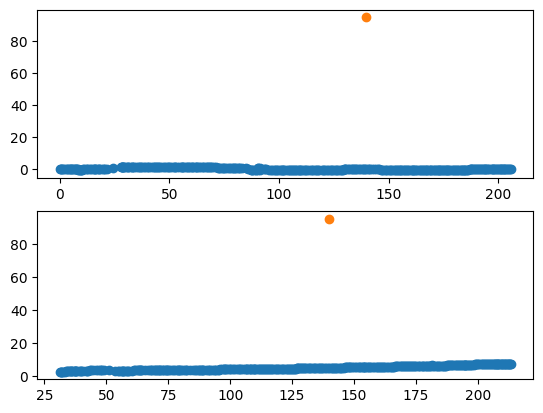

In [30]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(train_data[0,:,0], train_data[0,:,1])
ax1.scatter(train_labels[0, 0], train_labels[0,1])
ax2.scatter(train_data[0, :,4], train_data[0, :, 5])
ax2.scatter(train_labels[0, 0], train_labels[0,1])

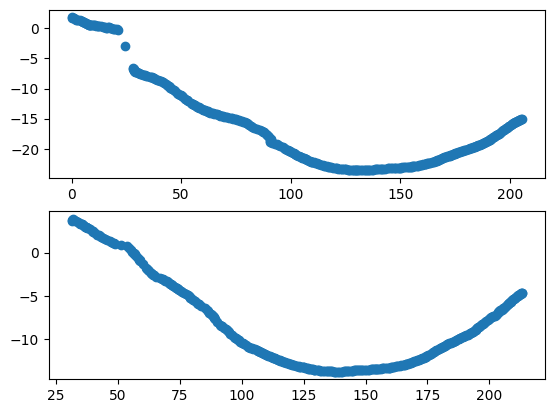

In [32]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(train_data[0,:,0], train_data[0,:,3])
#ax1.scatter(train_labels[0, 0], train_labels[0,1])
ax2.scatter(train_data[0, :,4], train_data[0, :, 7])
#ax2.scatter(train_labels[0, 0], train_labels[0,1])

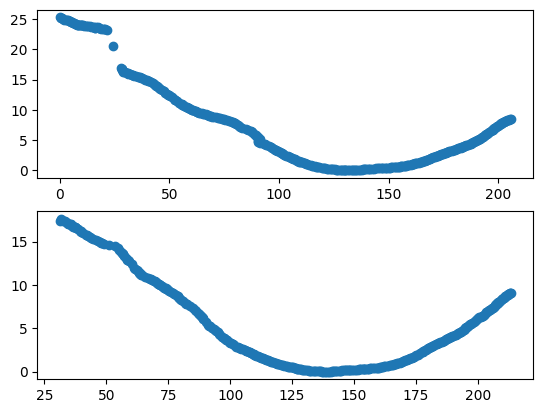

In [22]:
test = train_data
for i in range(len(test)):
    for j in range(test.shape[2]):
        if (j+1)%4 == 0:
            test[i, :,j] -= np.min(test[i,:,j])

fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(test[0,:,0], test[0,:,3])
ax2.scatter(test[0, :,4], test[0, :, 7])

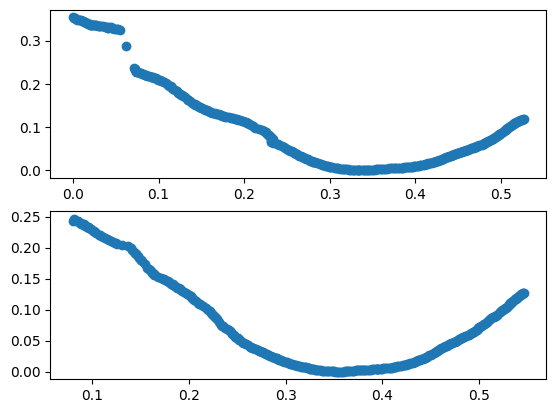

In [24]:
test2 = train_data
abs_max = np.abs(test2).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = test2 / abs_max

fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(X_train_norm[0,:,0], X_train_norm[0,:,3])
ax2.scatter(X_train_norm[0, :,4], X_train_norm[0, :, 7])

In [34]:
print("Train range:", X_train_norm.min(), X_train_norm.max())
print("Train std:", X_train_norm.std(axis=(0,1)))

Train range: -1.0 1.0
Train std: [0.19241452 0.18568788 0.24841466 0.11824194 0.19241452 0.18568788
 0.24841466 0.11824194]


***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [15]:
def cross_validation_dat(Main_Data,Holdout_Data, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(Main_Data)))):
        
        print(f"Fold {fold_idx + 1}")

        train = [Main_Data[i] for i in train_idx]
        test = [Main_Data[i] for i in val_idx]
        
        all_permutations_train = []
        for sublist in train:
            sublist_permutations = list(permutations(sublist,2))
            all_permutations_train.append(sublist_permutations)

        train_data = []
        train_labels = []
        for perms in all_permutations_train:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    train_data.append(paths)
                    train_labels.append(perm[0]['tag_pos'])

        train_data = np.array(train_data)
        train_labels = np.array(train_labels)
        all_permutations_test = []
        for sublist in test:
            sublist_permutations = list(permutations(sublist,2))
            all_permutations_test.append(sublist_permutations)
        
        test_data = []
        test_labels = []
        for perms in all_permutations_test:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    test_data.append(paths)
                    test_labels.append(perm[0]['tag_pos'])

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        train_loader, test_loader, _ = data_func_cv(train_data, train_labels, test_data, test_labels, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    all_permutations_main = []
    for sublist in Main_Data:
        sublist_permutations = list(permutations(sublist,2))
        all_permutations_main.append(sublist_permutations)
    
    main_data = []
    main_labels = []
    for perms in all_permutations_main:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                main_data.append(paths)
                main_labels.append(perm[0]['tag_pos'])

    main_data = np.array(main_data)
    main_labels = np.array(main_labels)

    all_permutations_holdout = []
    for sublist in Holdout_Data:
        sublist_permutations = list(permutations(sublist,2))
        all_permutations_holdout.append(sublist_permutations)
    
    holdout_data = []
    holdout_labels = []
    for perms in all_permutations_holdout:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                holdout_data.append(paths)
                holdout_labels.append(perm[0]['tag_pos'])
    
    holdout_data = np.array(holdout_data)
    holdout_labels = np.array(holdout_labels)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(main_data, holdout_data, main_labels, holdout_labels, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d_interactive(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

In [16]:
def cross_validation(X_main, y_main,X_holdout,y_holdout, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d_interactive(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [17]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 100

cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

Fold 1
[[[ 0.00000000e+00  0.00000000e+00  6.33000000e+01 ...  2.82594006e+00
    1.07300000e+02  1.73830659e+01]
  [ 2.79534530e-01 -5.18759007e-03  6.33000000e+01 ...  2.83630608e+00
    1.07300000e+02  1.74958610e+01]
  [ 6.13287505e-01 -1.11870794e-02  6.33000000e+01 ...  2.84667210e+00
    1.07300000e+02  1.76086560e+01]
  ...
  [ 2.04726092e+02 -3.25273173e-03  6.33000000e+01 ...  7.67119173e+00
    1.07300000e+02  9.01034306e+00]
  [ 2.05205070e+02 -1.77703797e-03  6.33000000e+01 ...  7.67970604e+00
    1.07300000e+02  9.03348184e+00]
  [ 2.05700139e+02  0.00000000e+00  6.33000000e+01 ...  7.68822035e+00
    1.07300000e+02  9.05662061e+00]]

 [[ 0.00000000e+00  0.00000000e+00  6.33000000e+01 ...  7.31900190e-01
    1.52800000e+02  3.39067125e+00]
  [ 2.79534530e-01 -5.18759007e-03  6.33000000e+01 ...  7.10818803e-01
    1.52800000e+02  3.34612219e+00]
  [ 6.13287505e-01 -1.11870794e-02  6.33000000e+01 ...  6.89737416e-01
    1.52800000e+02  3.30157313e+00]
  ...
  [ 2.04726092e+

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Fold 1
Epoch 0 | Loss train: 197.381257 | Loss test: 28.780819 | lr = 0.01
Epoch 10 | Loss train: 19.951018 | Loss test: 15.931942 | lr = 0.01
Epoch 20 | Loss train: 20.261603 | Loss test: 26.288238 | lr = 0.01
Epoch 30 | Loss train: 0.792390 | Loss test: 0.948991 | lr = 0.001
Epoch 40 | Loss train: 0.787661 | Loss test: 0.871157 | lr = 0.001
Epoch 50 | Loss train: 0.766027 | Loss test: 0.935339 | lr = 0.001
Epoch 60 | Loss train: 0.748961 | Loss test: 0.912101 | lr = 0.001
Epoch 70 | Loss train: 0.744791 | Loss test: 0.800340 | lr = 0.001
Epoch 80 | Loss train: 0.739783 | Loss test: 0.988425 | lr = 0.0001
Epoch 90 | Loss train: 0.522960 | Loss test: 0.692085 | lr = 0.0001
Epoch 100 | Loss train: 0.521255 | Loss test: 0.708798 | lr = 0.0001
Loaded best model from temp_model.pth


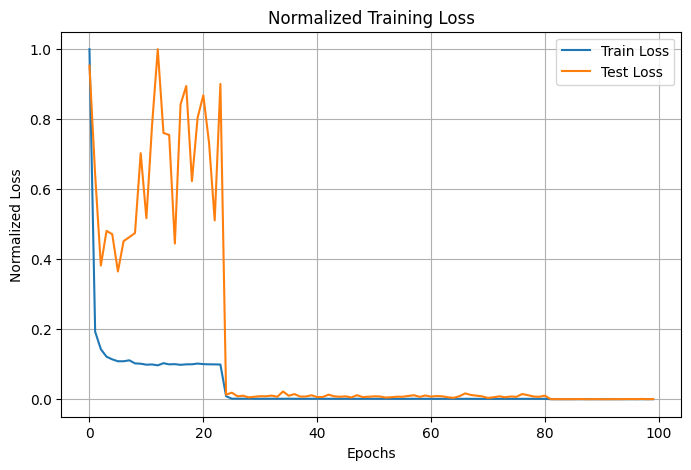

Fold 2
Epoch 0 | Loss train: 250.905111 | Loss test: 11.038140 | lr = 0.01
Epoch 10 | Loss train: 21.707618 | Loss test: 10.724863 | lr = 0.01
Epoch 20 | Loss train: 20.628592 | Loss test: 19.479408 | lr = 0.01
Early stopping at epoch 21
Loaded best model from temp_model.pth


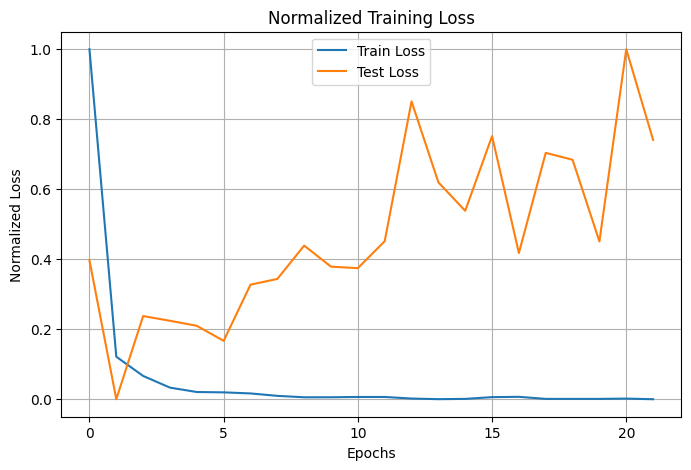

Fold 3
Epoch 0 | Loss train: 244.357101 | Loss test: 14.700272 | lr = 0.01
Epoch 10 | Loss train: 21.136477 | Loss test: 27.564861 | lr = 0.01
Epoch 20 | Loss train: 20.861832 | Loss test: 17.782828 | lr = 0.01
Early stopping at epoch 24
Loaded best model from temp_model.pth


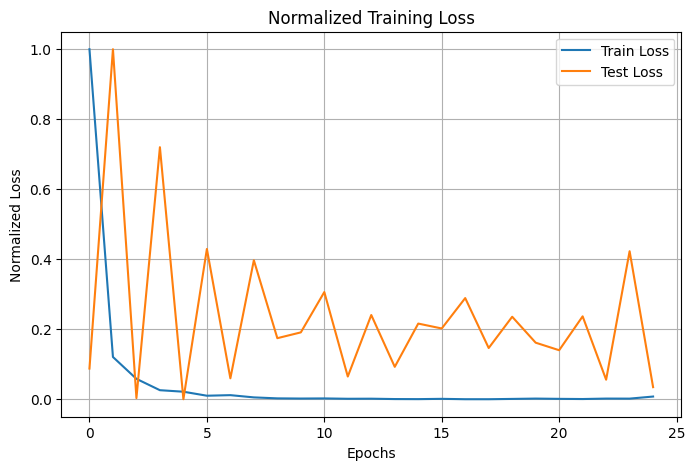

Fold 4
Epoch 0 | Loss train: 225.232187 | Loss test: 17.322783 | lr = 0.01
Epoch 10 | Loss train: 22.211697 | Loss test: 19.295745 | lr = 0.01
Epoch 20 | Loss train: 21.571807 | Loss test: 11.202685 | lr = 0.01
Early stopping at epoch 22
Loaded best model from temp_model.pth


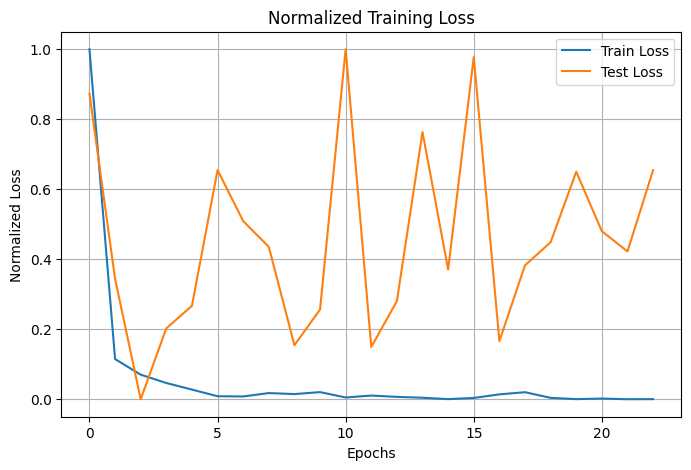

Fold 5
Epoch 0 | Loss train: 248.280313 | Loss test: 56.848997 | lr = 0.01
Epoch 10 | Loss train: 20.490403 | Loss test: 23.292040 | lr = 0.01
Epoch 20 | Loss train: 19.883719 | Loss test: 25.038583 | lr = 0.01
Early stopping at epoch 27
Loaded best model from temp_model.pth


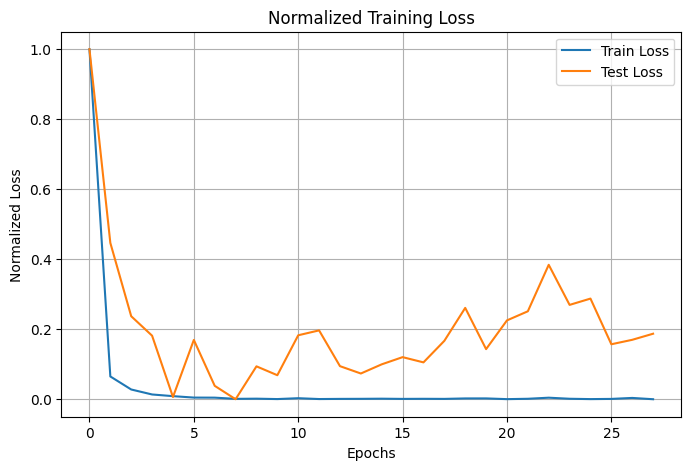

Cross-Validation finished with mean error across 5 subsets = 7.047886527265821, evaluating final model...
Epoch 0 | Loss train: 191.668512 | lr = 0.01
Epoch 10 | Loss train: 19.897113 | lr = 0.01
Epoch 20 | Loss train: 19.938867 | lr = 0.01
Epoch 30 | Loss train: 20.297215 | lr = 0.01
Epoch 40 | Loss train: 0.773134 | lr = 0.001
Epoch 50 | Loss train: 0.765564 | lr = 0.001
Epoch 60 | Loss train: 0.761024 | lr = 0.001
Epoch 70 | Loss train: 0.754071 | lr = 0.001
Epoch 80 | Loss train: 0.786550 | lr = 0.001
Epoch 90 | Loss train: 0.529615 | lr = 0.0001
Epoch 99 | Loss train: 0.528651 | lr = 0.0001


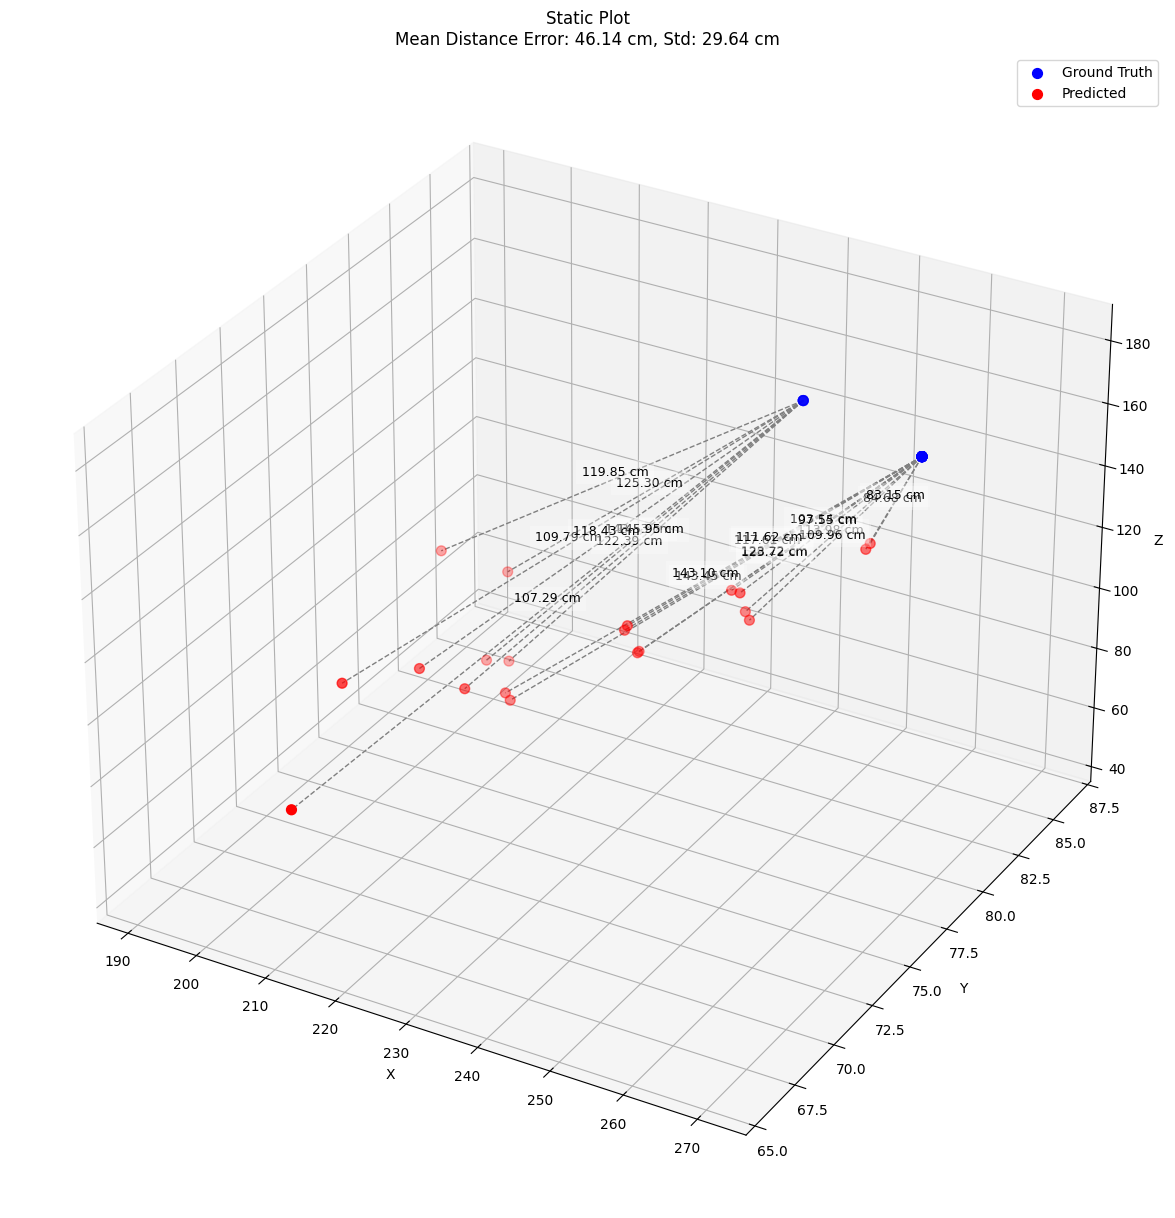

{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 46.143524169921875,
 'std': 29.640405654907227}

In [21]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100
cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Fold 1
Epoch 0 | Loss train: 0.872090 | Loss test: 0.977018 | lr = 0.01
Epoch 10 | Loss train: 0.695783 | Loss test: 0.775935 | lr = 0.01
Epoch 20 | Loss train: 0.648421 | Loss test: 0.752049 | lr = 0.01
Epoch 30 | Loss train: 0.600586 | Loss test: 0.724641 | lr = 0.01
Epoch 40 | Loss train: 0.583951 | Loss test: 0.726790 | lr = 0.01
Epoch 50 | Loss train: 0.597577 | Loss test: 0.716547 | lr = 0.01
Epoch 60 | Loss train: 0.556280 | Loss test: 0.765058 | lr = 0.01
Early stopping at epoch 64
Loaded best model from temp_model.pth


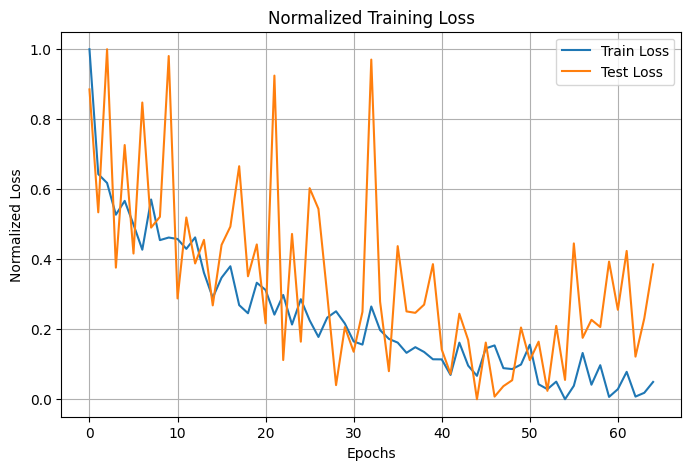

Fold 2
Epoch 0 | Loss train: 0.879916 | Loss test: 0.891981 | lr = 0.01
Epoch 10 | Loss train: 0.711018 | Loss test: 0.716187 | lr = 0.01
Epoch 20 | Loss train: 0.663920 | Loss test: 0.660776 | lr = 0.01
Epoch 30 | Loss train: 0.640044 | Loss test: 0.679404 | lr = 0.01
Early stopping at epoch 32
Loaded best model from temp_model.pth


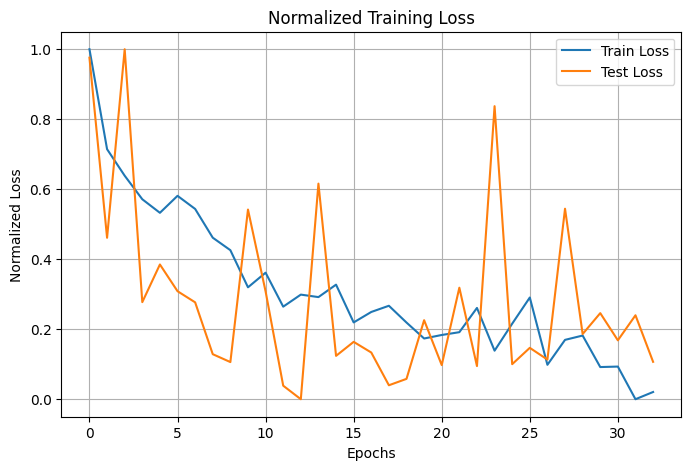

Fold 3
Epoch 0 | Loss train: 0.871440 | Loss test: 0.921924 | lr = 0.01
Epoch 10 | Loss train: 0.739259 | Loss test: 0.771454 | lr = 0.01
Epoch 20 | Loss train: 0.651992 | Loss test: 0.654928 | lr = 0.01
Epoch 30 | Loss train: 0.618297 | Loss test: 0.643852 | lr = 0.01
Epoch 40 | Loss train: 0.628647 | Loss test: 0.557655 | lr = 0.01
Epoch 50 | Loss train: 0.595254 | Loss test: 0.563453 | lr = 0.01
Epoch 60 | Loss train: 0.583398 | Loss test: 0.652465 | lr = 0.01
Epoch 70 | Loss train: 0.573423 | Loss test: 0.637841 | lr = 0.01
Epoch 80 | Loss train: 0.557781 | Loss test: 0.515127 | lr = 0.01
Epoch 90 | Loss train: 0.505071 | Loss test: 0.513798 | lr = 0.001
Epoch 100 | Loss train: 0.501317 | Loss test: 0.506412 | lr = 0.001
Loaded best model from temp_model.pth


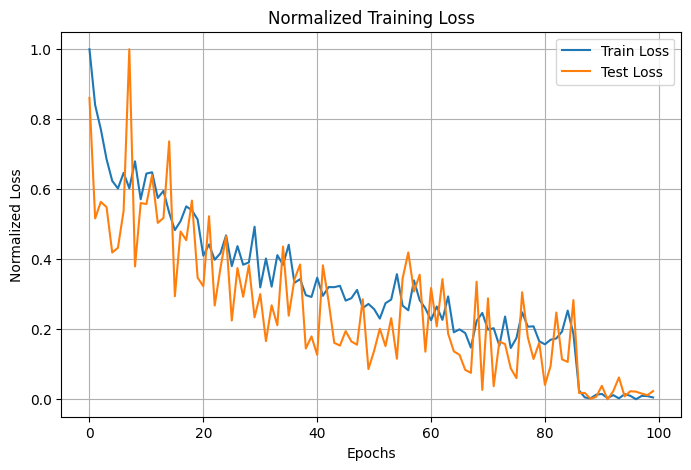

Fold 4
Epoch 0 | Loss train: 0.884273 | Loss test: 0.794075 | lr = 0.01
Epoch 10 | Loss train: 0.663156 | Loss test: 0.662633 | lr = 0.01
Epoch 20 | Loss train: 0.666404 | Loss test: 0.817897 | lr = 0.01
Epoch 30 | Loss train: 0.654447 | Loss test: 0.678040 | lr = 0.01
Epoch 40 | Loss train: 0.608074 | Loss test: 0.611406 | lr = 0.01
Epoch 50 | Loss train: 0.582524 | Loss test: 0.731865 | lr = 0.01
Epoch 60 | Loss train: 0.517207 | Loss test: 0.546231 | lr = 0.001
Epoch 70 | Loss train: 0.502591 | Loss test: 0.551456 | lr = 0.001
Epoch 80 | Loss train: 0.507547 | Loss test: 0.541262 | lr = 0.001
Epoch 90 | Loss train: 0.495183 | Loss test: 0.540329 | lr = 0.0001
Epoch 100 | Loss train: 0.498154 | Loss test: 0.543416 | lr = 0.0001
Loaded best model from temp_model.pth


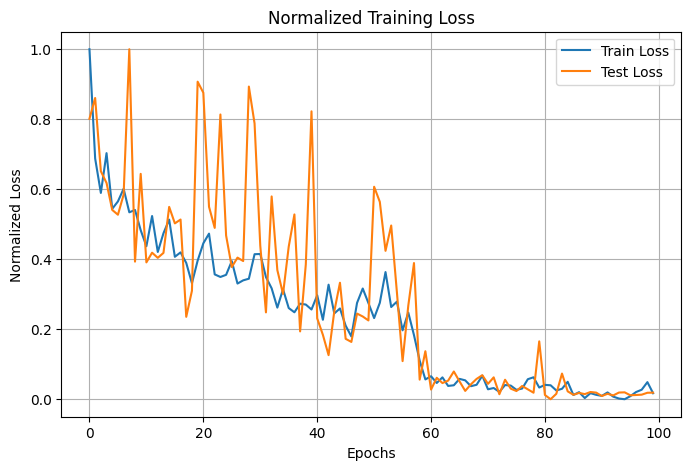

Fold 5
Epoch 0 | Loss train: 0.877007 | Loss test: 0.729307 | lr = 0.01
Epoch 10 | Loss train: 0.671586 | Loss test: 0.768358 | lr = 0.01
Epoch 20 | Loss train: 0.665205 | Loss test: 0.646886 | lr = 0.01
Epoch 30 | Loss train: 0.641257 | Loss test: 0.586762 | lr = 0.01
Epoch 40 | Loss train: 0.607083 | Loss test: 0.607821 | lr = 0.01
Epoch 50 | Loss train: 0.597510 | Loss test: 0.563707 | lr = 0.01
Epoch 60 | Loss train: 0.584180 | Loss test: 0.704666 | lr = 0.01
Early stopping at epoch 62
Loaded best model from temp_model.pth


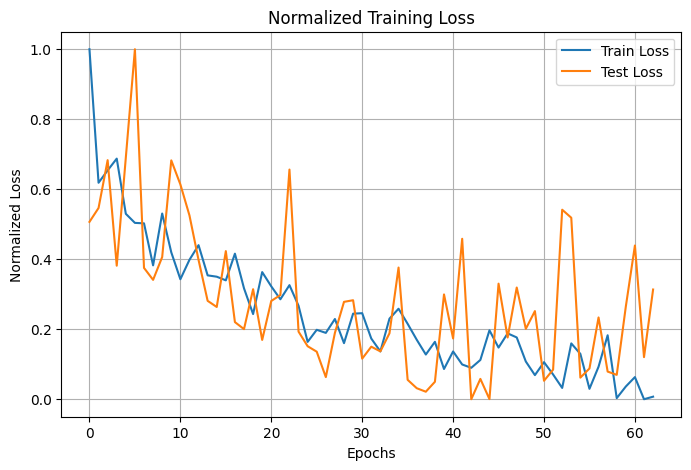

Cross-Validation finished with mean error across 5 subsets = 0.5781615612478482, evaluating final model...
Epoch 0 | Loss train: 0.835143 | lr = 0.01
Epoch 10 | Loss train: 0.694415 | lr = 0.01
Epoch 20 | Loss train: 0.629489 | lr = 0.01
Epoch 30 | Loss train: 0.623578 | lr = 0.01
Epoch 40 | Loss train: 0.587524 | lr = 0.01
Epoch 50 | Loss train: 0.574371 | lr = 0.01
Epoch 60 | Loss train: 0.580037 | lr = 0.01
Epoch 70 | Loss train: 0.560915 | lr = 0.01
Epoch 80 | Loss train: 0.536700 | lr = 0.01
Epoch 90 | Loss train: 0.542010 | lr = 0.01
Epoch 99 | Loss train: 0.484390 | lr = 0.001


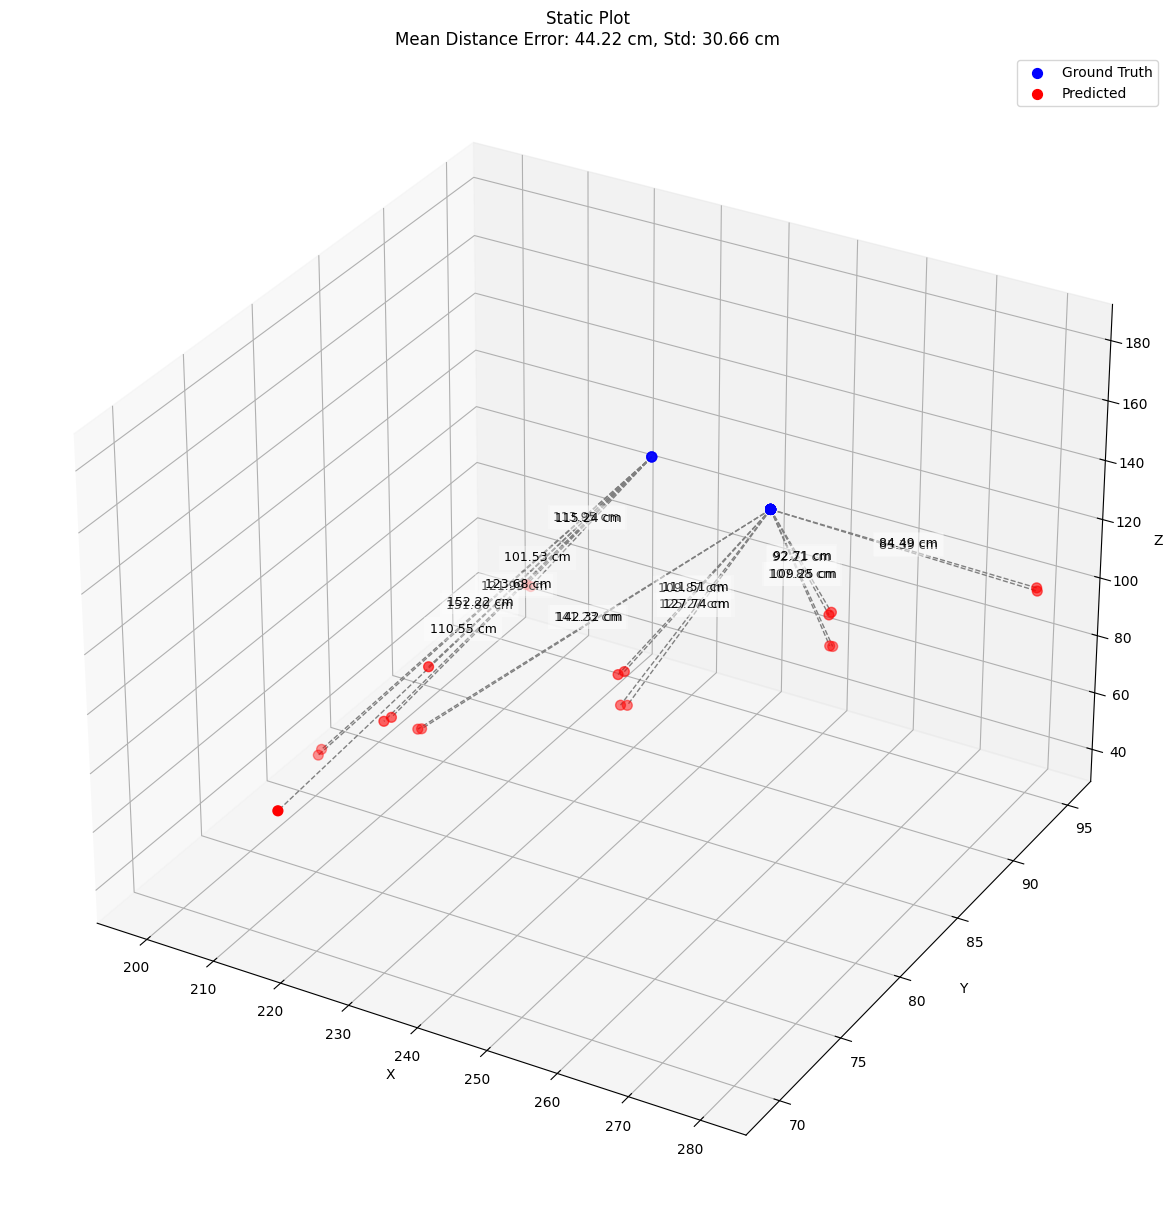

{'model_name': 'SimpleModel',
 'mean_distance_error_cm': 44.218658447265625,
 'std': 30.66211700439453}

In [22]:
loss_fn = nn.MSELoss()
optim = torch.optim.SGD
optimizer_params = {'lr':1e-2, 'momentum': 0.9}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 20, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 100

cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= SimpleModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [35]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 3.089100 | Loss test: 0.878575 | lr = 0.01
Epoch 10 | Loss train: 0.574776 | Loss test: 0.601017 | lr = 0.01
Epoch 20 | Loss train: 0.515217 | Loss test: 0.600726 | lr = 0.01
Epoch 30 | Loss train: 0.479944 | Loss test: 0.552834 | lr = 0.01
Epoch 40 | Loss train: 0.440686 | Loss test: 0.590125 | lr = 0.01
Epoch 50 | Loss train: 0.389643 | Loss test: 0.406271 | lr = 0.01
Epoch 60 | Loss train: 0.360272 | Loss test: 0.414739 | lr = 0.01
Epoch 70 | Loss train: 0.315056 | Loss test: 0.499334 | lr = 0.01
Epoch 80 | Loss train: 0.268604 | Loss test: 0.415315 | lr = 0.01
Epoch 90 | Loss train: 0.302926 | Loss test: 0.387413 | lr = 0.01
Epoch 100 | Loss train: 0.274517 | Loss test: 0.344474 | lr = 0.01
Epoch 110 | Loss train: 0.245655 | Loss test: 0.357786 | lr = 0.01
Epoch 120 | Loss train: 0.247327 | Loss test: 0.385877 | lr = 0.01
Epoch 130 | Loss train: 0.236489 | Loss test: 0.351590 | lr = 0.01
Epoch 140 | Loss train: 0.252329 | Loss test: 0.397878 | lr = 0.01

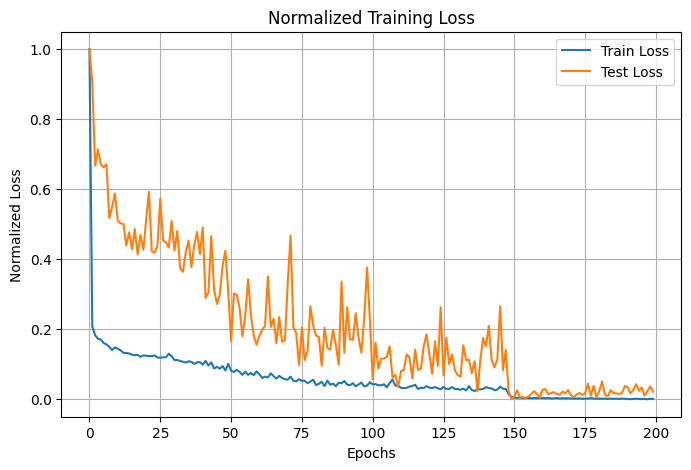

Fold 2
Epoch 0 | Loss train: 6.172161 | Loss test: 1.025376 | lr = 0.01
Epoch 10 | Loss train: 0.576261 | Loss test: 0.698795 | lr = 0.01
Epoch 20 | Loss train: 0.513449 | Loss test: 0.667299 | lr = 0.01
Epoch 30 | Loss train: 0.477275 | Loss test: 0.624872 | lr = 0.01
Epoch 40 | Loss train: 0.439568 | Loss test: 0.626273 | lr = 0.01
Epoch 50 | Loss train: 0.356911 | Loss test: 0.567896 | lr = 0.01
Epoch 60 | Loss train: 0.307677 | Loss test: 0.471127 | lr = 0.01
Epoch 70 | Loss train: 0.319201 | Loss test: 0.479508 | lr = 0.01
Epoch 80 | Loss train: 0.312060 | Loss test: 0.570664 | lr = 0.01
Epoch 90 | Loss train: 0.281068 | Loss test: 0.471228 | lr = 0.01
Epoch 100 | Loss train: 0.281813 | Loss test: 0.536639 | lr = 0.01
Epoch 110 | Loss train: 0.204957 | Loss test: 0.457567 | lr = 0.001
Epoch 120 | Loss train: 0.193985 | Loss test: 0.479539 | lr = 0.001
Epoch 130 | Loss train: 0.187015 | Loss test: 0.471898 | lr = 0.001
Epoch 140 | Loss train: 0.184435 | Loss test: 0.466574 | lr = 0

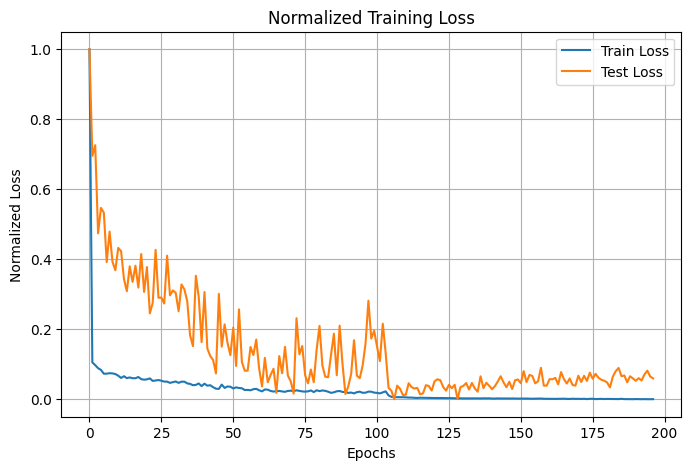

Cross-Validation finished with mean error across 2 subsets = 0.38117049286833526, evaluating final model...
Epoch 0 | Loss train: 1.812125 | lr = 0.01
Epoch 10 | Loss train: 0.516862 | lr = 0.01
Epoch 20 | Loss train: 0.504087 | lr = 0.01
Epoch 30 | Loss train: 0.437839 | lr = 0.01
Epoch 40 | Loss train: 0.344362 | lr = 0.01
Epoch 50 | Loss train: 0.312831 | lr = 0.01
Epoch 60 | Loss train: 0.326477 | lr = 0.01
Epoch 70 | Loss train: 0.319682 | lr = 0.01
Epoch 80 | Loss train: 0.284964 | lr = 0.01
Epoch 90 | Loss train: 0.279026 | lr = 0.01
Epoch 100 | Loss train: 0.292452 | lr = 0.01
Epoch 110 | Loss train: 0.198744 | lr = 0.001
Epoch 120 | Loss train: 0.197940 | lr = 0.001
Epoch 130 | Loss train: 0.196232 | lr = 0.001
Epoch 140 | Loss train: 0.194181 | lr = 0.001
Epoch 150 | Loss train: 0.191894 | lr = 0.001
Epoch 160 | Loss train: 0.189594 | lr = 0.001
Epoch 170 | Loss train: 0.179957 | lr = 0.0001
Epoch 180 | Loss train: 0.180229 | lr = 0.0001
Epoch 190 | Loss train: 0.180169 | lr 

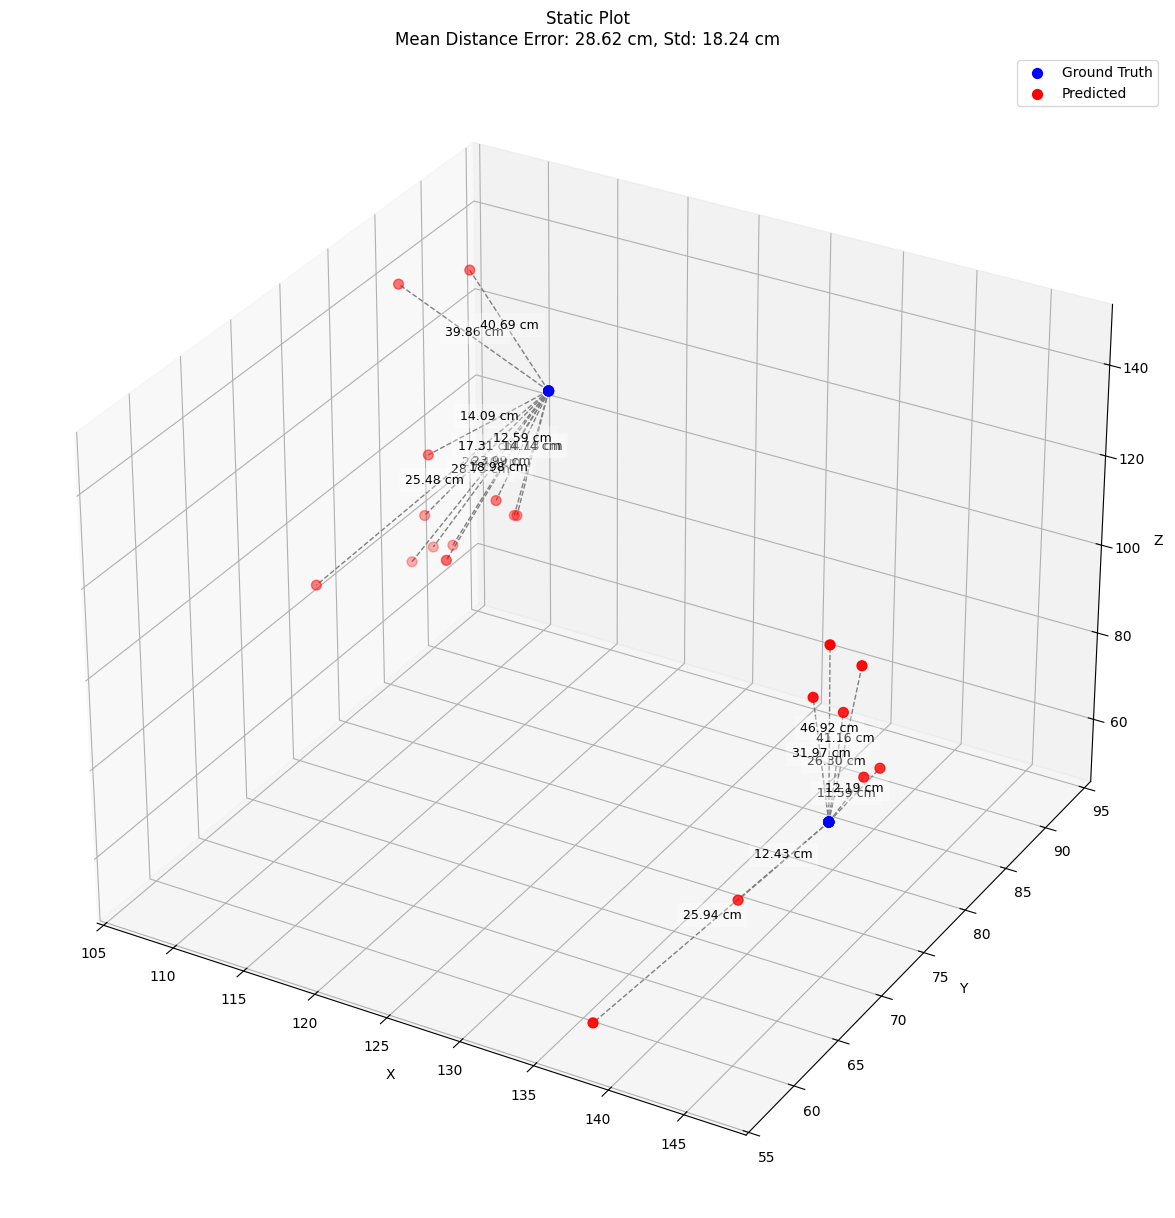

In [36]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 200

relu_model = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

In [25]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 29.963424682617188,
 'std': 20.76791763305664}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Fold 1
Epoch 0 | Loss train: 4.950228 | Loss test: 0.858442 | lr = 0.01
Epoch 10 | Loss train: 0.572654 | Loss test: 0.650856 | lr = 0.01
Epoch 20 | Loss train: 0.526147 | Loss test: 0.572094 | lr = 0.01
Epoch 30 | Loss train: 0.439693 | Loss test: 0.460043 | lr = 0.01
Epoch 40 | Loss train: 0.387071 | Loss test: 0.457717 | lr = 0.01
Epoch 50 | Loss train: 0.376120 | Loss test: 0.388513 | lr = 0.01
Epoch 60 | Loss train: 0.346528 | Loss test: 0.458062 | lr = 0.01
Epoch 70 | Loss train: 0.346472 | Loss test: 0.383555 | lr = 0.01
Epoch 80 | Loss train: 0.266442 | Loss test: 0.323198 | lr = 0.001
Epoch 90 | Loss train: 0.259487 | Loss test: 0.322267 | lr = 0.001
Epoch 100 | Loss train: 0.251216 | Loss test: 0.312714 | lr = 0.001
Epoch 110 | Loss train: 0.246325 | Loss test: 0.318095 | lr = 0.001
Epoch 120 | Loss train: 0.245753 | Loss test: 0.311724 | lr = 0.001
Epoch 130 | Loss train: 0.242906 | Loss test: 0.313082 | lr = 0.001
Epoch 140 | Loss train: 0.241601 | Loss test: 0.309301 | lr 

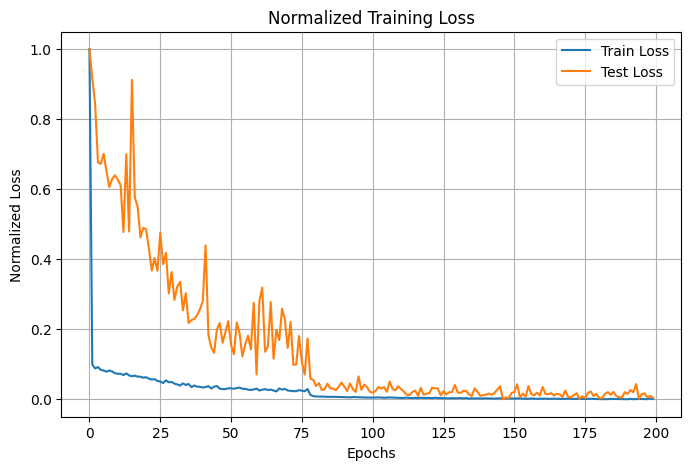

Fold 2
Epoch 0 | Loss train: 5.766928 | Loss test: 0.780031 | lr = 0.01
Epoch 10 | Loss train: 0.580553 | Loss test: 0.656053 | lr = 0.01
Epoch 20 | Loss train: 0.503908 | Loss test: 0.567680 | lr = 0.01
Epoch 30 | Loss train: 0.411675 | Loss test: 0.541830 | lr = 0.01
Epoch 40 | Loss train: 0.373839 | Loss test: 0.464712 | lr = 0.01
Epoch 50 | Loss train: 0.353363 | Loss test: 0.466325 | lr = 0.01
Epoch 60 | Loss train: 0.344479 | Loss test: 0.438232 | lr = 0.01
Epoch 70 | Loss train: 0.326288 | Loss test: 0.506592 | lr = 0.01
Epoch 80 | Loss train: 0.224295 | Loss test: 0.407361 | lr = 0.001
Epoch 90 | Loss train: 0.217878 | Loss test: 0.405029 | lr = 0.001
Epoch 100 | Loss train: 0.212107 | Loss test: 0.407991 | lr = 0.001
Epoch 110 | Loss train: 0.209533 | Loss test: 0.400597 | lr = 0.001
Epoch 120 | Loss train: 0.204796 | Loss test: 0.409467 | lr = 0.001
Epoch 130 | Loss train: 0.203538 | Loss test: 0.398038 | lr = 0.001
Epoch 140 | Loss train: 0.202166 | Loss test: 0.400097 | lr 

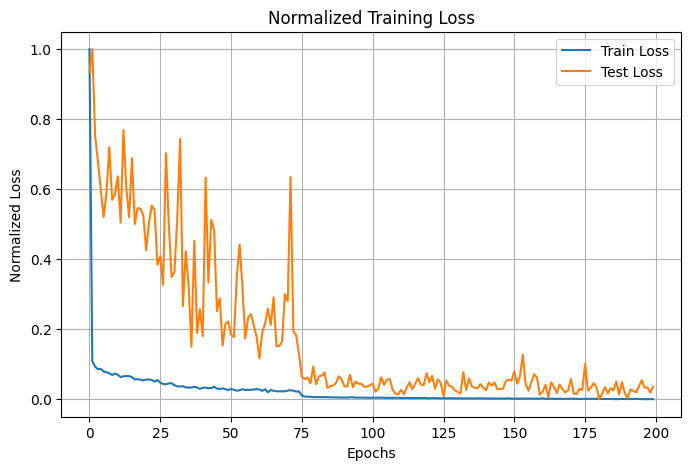

Fold 3
Epoch 0 | Loss train: 5.206923 | Loss test: 0.832343 | lr = 0.01
Epoch 10 | Loss train: 0.560727 | Loss test: 0.591523 | lr = 0.01
Epoch 20 | Loss train: 0.510894 | Loss test: 0.564393 | lr = 0.01
Epoch 30 | Loss train: 0.488574 | Loss test: 0.664039 | lr = 0.01
Epoch 40 | Loss train: 0.474070 | Loss test: 0.590801 | lr = 0.01
Epoch 50 | Loss train: 0.390969 | Loss test: 0.442574 | lr = 0.01
Epoch 60 | Loss train: 0.359106 | Loss test: 0.444505 | lr = 0.01
Epoch 70 | Loss train: 0.348064 | Loss test: 0.428159 | lr = 0.01
Epoch 80 | Loss train: 0.260252 | Loss test: 0.341486 | lr = 0.001
Epoch 90 | Loss train: 0.232165 | Loss test: 0.337047 | lr = 0.001
Epoch 100 | Loss train: 0.223600 | Loss test: 0.334445 | lr = 0.001
Epoch 110 | Loss train: 0.218227 | Loss test: 0.330390 | lr = 0.001
Epoch 120 | Loss train: 0.212246 | Loss test: 0.337303 | lr = 0.001
Epoch 130 | Loss train: 0.207399 | Loss test: 0.319353 | lr = 0.001
Epoch 140 | Loss train: 0.203964 | Loss test: 0.336223 | lr 

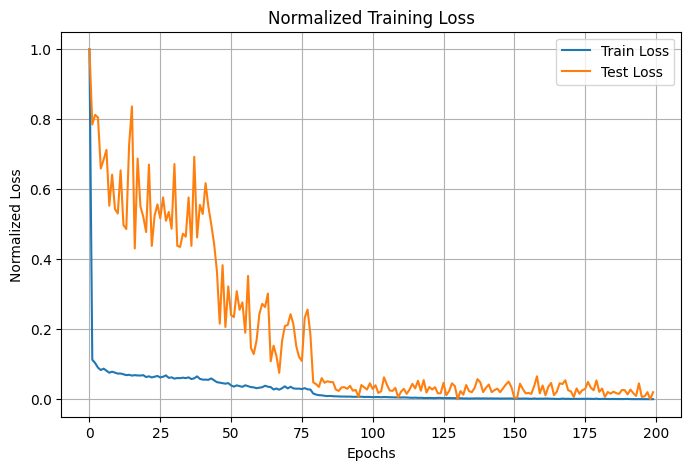

Fold 4
Epoch 0 | Loss train: 6.251143 | Loss test: 0.780498 | lr = 0.01
Epoch 10 | Loss train: 0.635098 | Loss test: 0.688235 | lr = 0.01
Epoch 20 | Loss train: 0.522990 | Loss test: 0.639826 | lr = 0.01
Epoch 30 | Loss train: 0.537050 | Loss test: 0.654858 | lr = 0.01
Epoch 40 | Loss train: 0.493324 | Loss test: 0.626514 | lr = 0.01
Epoch 50 | Loss train: 0.500699 | Loss test: 0.655083 | lr = 0.01
Epoch 60 | Loss train: 0.489505 | Loss test: 0.565474 | lr = 0.01
Epoch 70 | Loss train: 0.466826 | Loss test: 0.672585 | lr = 0.01
Epoch 80 | Loss train: 0.459200 | Loss test: 0.577376 | lr = 0.01
Epoch 90 | Loss train: 0.460436 | Loss test: 0.578770 | lr = 0.01
Epoch 100 | Loss train: 0.447452 | Loss test: 0.578740 | lr = 0.01
Epoch 110 | Loss train: 0.401958 | Loss test: 0.538234 | lr = 0.001
Epoch 120 | Loss train: 0.393622 | Loss test: 0.522043 | lr = 0.001
Epoch 130 | Loss train: 0.390934 | Loss test: 0.517566 | lr = 0.001
Epoch 140 | Loss train: 0.388089 | Loss test: 0.525565 | lr = 0

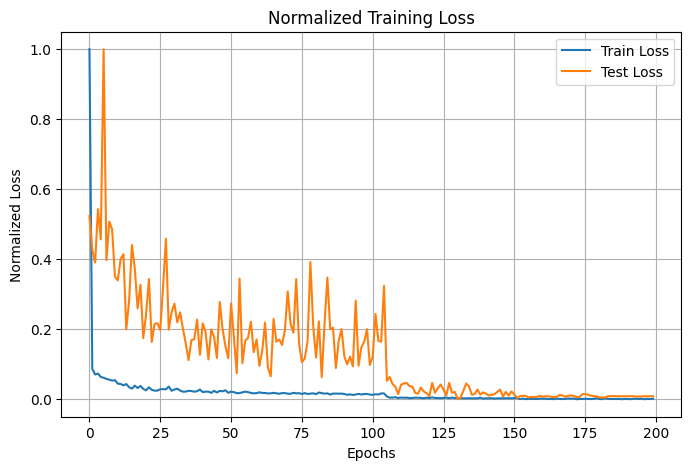

Fold 5
Epoch 0 | Loss train: 4.725591 | Loss test: 0.845613 | lr = 0.01
Epoch 10 | Loss train: 0.773569 | Loss test: 0.747231 | lr = 0.01
Epoch 20 | Loss train: 0.607625 | Loss test: 0.542185 | lr = 0.01
Epoch 30 | Loss train: 0.554425 | Loss test: 0.498302 | lr = 0.01
Epoch 40 | Loss train: 0.504801 | Loss test: 0.484067 | lr = 0.01
Epoch 50 | Loss train: 0.498089 | Loss test: 0.456597 | lr = 0.01
Epoch 60 | Loss train: 0.487802 | Loss test: 0.495576 | lr = 0.01
Epoch 70 | Loss train: 0.478731 | Loss test: 0.473548 | lr = 0.01
Epoch 80 | Loss train: 0.463513 | Loss test: 0.441091 | lr = 0.01
Epoch 90 | Loss train: 0.453948 | Loss test: 0.445265 | lr = 0.001
Epoch 100 | Loss train: 0.404508 | Loss test: 0.438860 | lr = 0.001
Epoch 110 | Loss train: 0.366228 | Loss test: 0.410323 | lr = 0.001
Epoch 120 | Loss train: 0.306978 | Loss test: 0.384744 | lr = 0.001
Epoch 130 | Loss train: 0.274905 | Loss test: 0.365977 | lr = 0.001
Epoch 140 | Loss train: 0.266758 | Loss test: 0.358383 | lr =

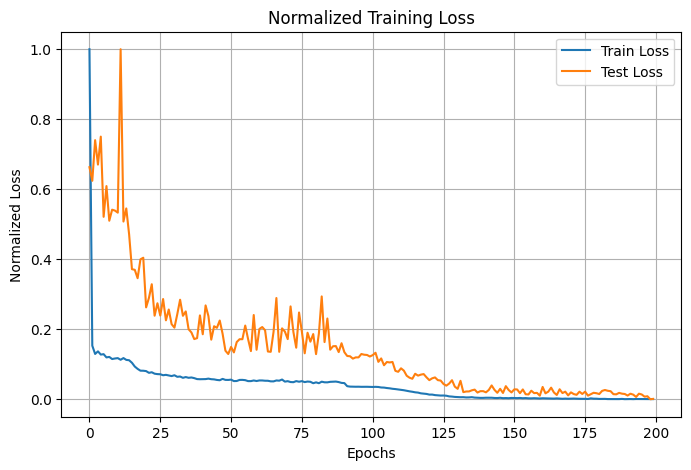

Cross-Validation finished with mean error across 5 subsets = 0.3743578855125677, evaluating final model...
Epoch 0 | Loss train: 4.269677 | lr = 0.01
Epoch 10 | Loss train: 0.505845 | lr = 0.01
Epoch 20 | Loss train: 0.408210 | lr = 0.01
Epoch 30 | Loss train: 0.352609 | lr = 0.01
Epoch 40 | Loss train: 0.343359 | lr = 0.01
Epoch 50 | Loss train: 0.320000 | lr = 0.01
Epoch 60 | Loss train: 0.311577 | lr = 0.01
Epoch 70 | Loss train: 0.211357 | lr = 0.001
Epoch 80 | Loss train: 0.202631 | lr = 0.001
Epoch 90 | Loss train: 0.200046 | lr = 0.001
Epoch 100 | Loss train: 0.194500 | lr = 0.001
Epoch 110 | Loss train: 0.192731 | lr = 0.001
Epoch 120 | Loss train: 0.186434 | lr = 0.001
Epoch 130 | Loss train: 0.178733 | lr = 0.001
Epoch 140 | Loss train: 0.174958 | lr = 0.001
Epoch 150 | Loss train: 0.170646 | lr = 0.001
Epoch 160 | Loss train: 0.168193 | lr = 0.001
Epoch 170 | Loss train: 0.166031 | lr = 0.001
Epoch 180 | Loss train: 0.166127 | lr = 0.001
Epoch 190 | Loss train: 0.160363 | lr

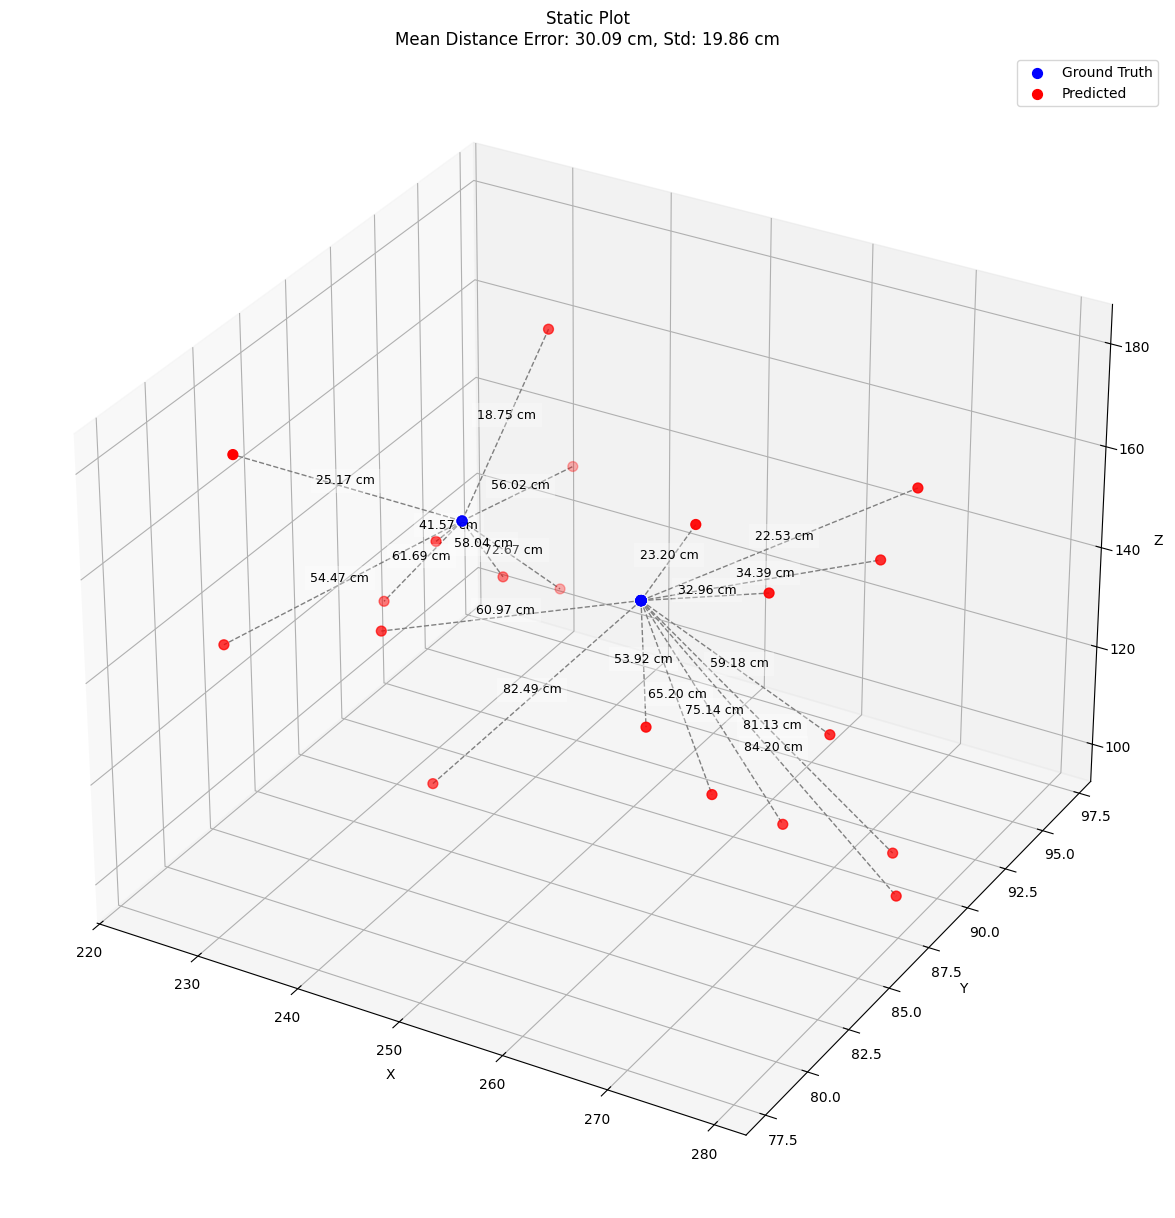

In [26]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_256 = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

In [27]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 30.0895938873291,
  'std': 19.86444664001465},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 29.963424682617188,
  'std': 20.76791763305664})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Fold 1
Epoch 0 | Loss train: 0.957595 | Loss test: 0.805449 | lr = 0.01
Epoch 10 | Loss train: 0.495200 | Loss test: 0.546741 | lr = 0.01
Epoch 20 | Loss train: 0.445505 | Loss test: 0.500302 | lr = 0.01
Epoch 30 | Loss train: 0.373270 | Loss test: 0.491804 | lr = 0.01
Epoch 40 | Loss train: 0.368781 | Loss test: 0.394174 | lr = 0.01
Epoch 50 | Loss train: 0.342301 | Loss test: 0.416791 | lr = 0.01
Epoch 60 | Loss train: 0.338621 | Loss test: 0.414549 | lr = 0.01
Epoch 70 | Loss train: 0.336886 | Loss test: 0.411639 | lr = 0.01
Epoch 80 | Loss train: 0.322259 | Loss test: 0.405901 | lr = 0.01
Epoch 90 | Loss train: 0.329021 | Loss test: 0.373580 | lr = 0.01
Epoch 100 | Loss train: 0.332408 | Loss test: 0.414549 | lr = 0.01
Epoch 110 | Loss train: 0.241071 | Loss test: 0.310267 | lr = 0.001
Epoch 120 | Loss train: 0.237473 | Loss test: 0.318628 | lr = 0.001
Epoch 130 | Loss train: 0.234629 | Loss test: 0.308731 | lr = 0.001
Epoch 140 | Loss train: 0.230033 | Loss test: 0.312018 | lr = 0

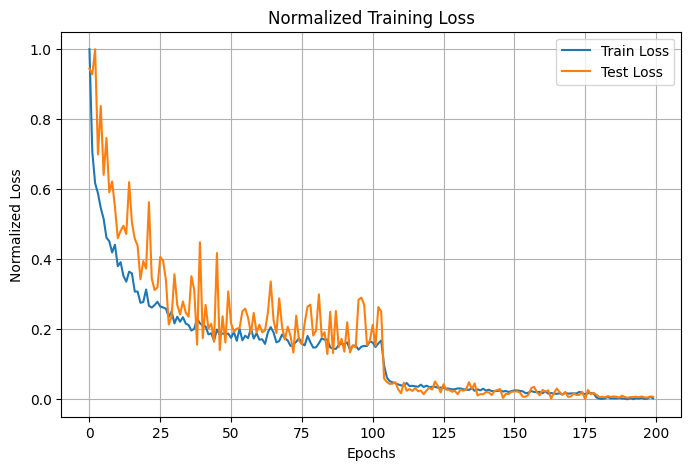

Fold 2
Epoch 0 | Loss train: 1.185010 | Loss test: 1.026316 | lr = 0.01
Epoch 10 | Loss train: 0.501917 | Loss test: 0.896948 | lr = 0.01
Epoch 20 | Loss train: 0.376880 | Loss test: 0.488896 | lr = 0.01
Epoch 30 | Loss train: 0.365836 | Loss test: 0.496680 | lr = 0.01
Epoch 40 | Loss train: 0.324415 | Loss test: 0.638118 | lr = 0.01
Epoch 50 | Loss train: 0.315704 | Loss test: 0.470968 | lr = 0.01
Epoch 60 | Loss train: 0.306374 | Loss test: 0.429131 | lr = 0.01
Epoch 70 | Loss train: 0.297873 | Loss test: 0.542415 | lr = 0.01
Epoch 80 | Loss train: 0.306009 | Loss test: 0.422851 | lr = 0.01
Epoch 90 | Loss train: 0.296178 | Loss test: 0.511729 | lr = 0.01
Epoch 100 | Loss train: 0.218866 | Loss test: 0.392988 | lr = 0.001
Epoch 110 | Loss train: 0.205510 | Loss test: 0.387387 | lr = 0.001
Epoch 120 | Loss train: 0.202904 | Loss test: 0.383372 | lr = 0.001
Epoch 130 | Loss train: 0.201695 | Loss test: 0.386712 | lr = 0.001
Epoch 140 | Loss train: 0.200603 | Loss test: 0.384133 | lr = 

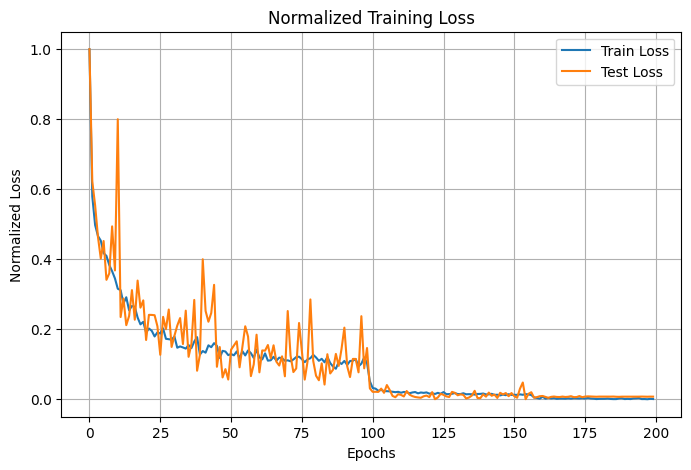

Fold 3
Epoch 0 | Loss train: 1.074959 | Loss test: 0.812425 | lr = 0.01
Epoch 10 | Loss train: 0.510549 | Loss test: 0.613553 | lr = 0.01
Epoch 20 | Loss train: 0.449308 | Loss test: 0.558190 | lr = 0.01
Epoch 30 | Loss train: 0.383961 | Loss test: 0.381333 | lr = 0.01
Epoch 40 | Loss train: 0.382896 | Loss test: 0.391888 | lr = 0.01
Epoch 50 | Loss train: 0.402334 | Loss test: 0.411650 | lr = 0.01
Epoch 60 | Loss train: 0.395403 | Loss test: 0.424756 | lr = 0.01
Epoch 70 | Loss train: 0.290906 | Loss test: 0.380000 | lr = 0.001
Epoch 80 | Loss train: 0.288971 | Loss test: 0.374779 | lr = 0.001
Epoch 90 | Loss train: 0.283157 | Loss test: 0.379335 | lr = 0.001
Epoch 100 | Loss train: 0.278758 | Loss test: 0.345441 | lr = 0.001
Epoch 110 | Loss train: 0.277701 | Loss test: 0.345826 | lr = 0.001
Epoch 120 | Loss train: 0.278082 | Loss test: 0.347784 | lr = 0.001
Epoch 130 | Loss train: 0.267003 | Loss test: 0.344701 | lr = 0.0001
Epoch 140 | Loss train: 0.265205 | Loss test: 0.341953 | l

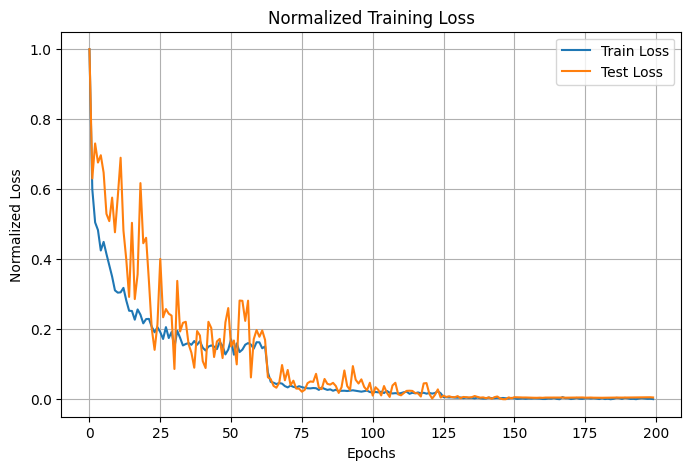

Fold 4
Epoch 0 | Loss train: 1.074589 | Loss test: 0.677316 | lr = 0.01
Epoch 10 | Loss train: 0.450727 | Loss test: 0.629817 | lr = 0.01
Epoch 20 | Loss train: 0.389269 | Loss test: 0.473935 | lr = 0.01
Epoch 30 | Loss train: 0.349009 | Loss test: 0.584739 | lr = 0.01
Epoch 40 | Loss train: 0.321707 | Loss test: 0.440855 | lr = 0.01
Epoch 50 | Loss train: 0.230802 | Loss test: 0.373201 | lr = 0.001
Epoch 60 | Loss train: 0.210456 | Loss test: 0.351433 | lr = 0.001
Epoch 70 | Loss train: 0.196941 | Loss test: 0.345577 | lr = 0.001
Epoch 80 | Loss train: 0.194060 | Loss test: 0.336897 | lr = 0.001
Epoch 90 | Loss train: 0.186031 | Loss test: 0.345974 | lr = 0.001
Epoch 100 | Loss train: 0.180809 | Loss test: 0.329407 | lr = 0.001
Epoch 110 | Loss train: 0.184925 | Loss test: 0.359309 | lr = 0.001
Epoch 120 | Loss train: 0.178111 | Loss test: 0.344809 | lr = 0.001
Epoch 130 | Loss train: 0.176813 | Loss test: 0.322760 | lr = 0.001
Epoch 140 | Loss train: 0.173004 | Loss test: 0.340960 | 

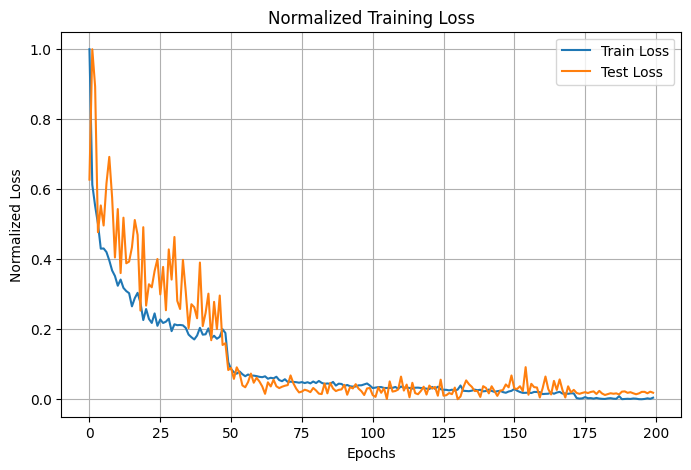

Fold 5
Epoch 0 | Loss train: 1.167665 | Loss test: 1.079209 | lr = 0.01
Epoch 10 | Loss train: 0.532592 | Loss test: 0.558332 | lr = 0.01
Epoch 20 | Loss train: 0.430382 | Loss test: 0.520091 | lr = 0.01
Epoch 30 | Loss train: 0.349147 | Loss test: 0.430291 | lr = 0.01
Epoch 40 | Loss train: 0.324515 | Loss test: 0.386761 | lr = 0.01
Epoch 50 | Loss train: 0.326263 | Loss test: 0.404869 | lr = 0.01
Epoch 60 | Loss train: 0.337812 | Loss test: 0.432933 | lr = 0.01
Epoch 70 | Loss train: 0.297875 | Loss test: 0.407024 | lr = 0.01
Epoch 80 | Loss train: 0.326165 | Loss test: 0.351815 | lr = 0.01
Epoch 90 | Loss train: 0.294605 | Loss test: 0.382912 | lr = 0.01
Epoch 100 | Loss train: 0.212012 | Loss test: 0.324304 | lr = 0.001
Epoch 110 | Loss train: 0.207388 | Loss test: 0.323208 | lr = 0.001
Epoch 120 | Loss train: 0.201915 | Loss test: 0.332929 | lr = 0.001
Epoch 130 | Loss train: 0.201594 | Loss test: 0.330591 | lr = 0.001
Epoch 140 | Loss train: 0.198081 | Loss test: 0.330822 | lr = 

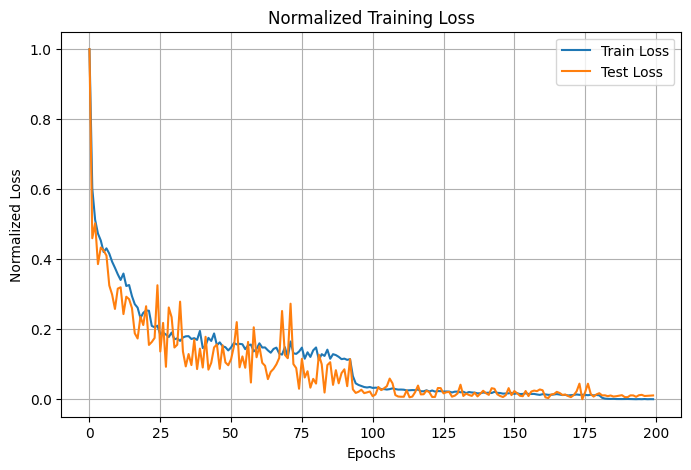

Cross-Validation finished with mean error across 5 subsets = 0.33229430352648104, evaluating final model...
Epoch 0 | Loss train: 1.065726 | lr = 0.01
Epoch 10 | Loss train: 0.498868 | lr = 0.01
Epoch 20 | Loss train: 0.409660 | lr = 0.01
Epoch 30 | Loss train: 0.376280 | lr = 0.01
Epoch 40 | Loss train: 0.351516 | lr = 0.01
Epoch 50 | Loss train: 0.352043 | lr = 0.01
Epoch 60 | Loss train: 0.315043 | lr = 0.01
Epoch 70 | Loss train: 0.306991 | lr = 0.01
Epoch 80 | Loss train: 0.320968 | lr = 0.01
Epoch 90 | Loss train: 0.223227 | lr = 0.001
Epoch 100 | Loss train: 0.215956 | lr = 0.001
Epoch 110 | Loss train: 0.214729 | lr = 0.001
Epoch 120 | Loss train: 0.213583 | lr = 0.001
Epoch 130 | Loss train: 0.210751 | lr = 0.001
Epoch 140 | Loss train: 0.200359 | lr = 0.0001
Epoch 150 | Loss train: 0.199849 | lr = 0.0001
Epoch 160 | Loss train: 0.199896 | lr = 0.0001
Epoch 170 | Loss train: 0.198710 | lr = 1e-05
Epoch 180 | Loss train: 0.198659 | lr = 1e-05
Epoch 190 | Loss train: 0.198544 | 

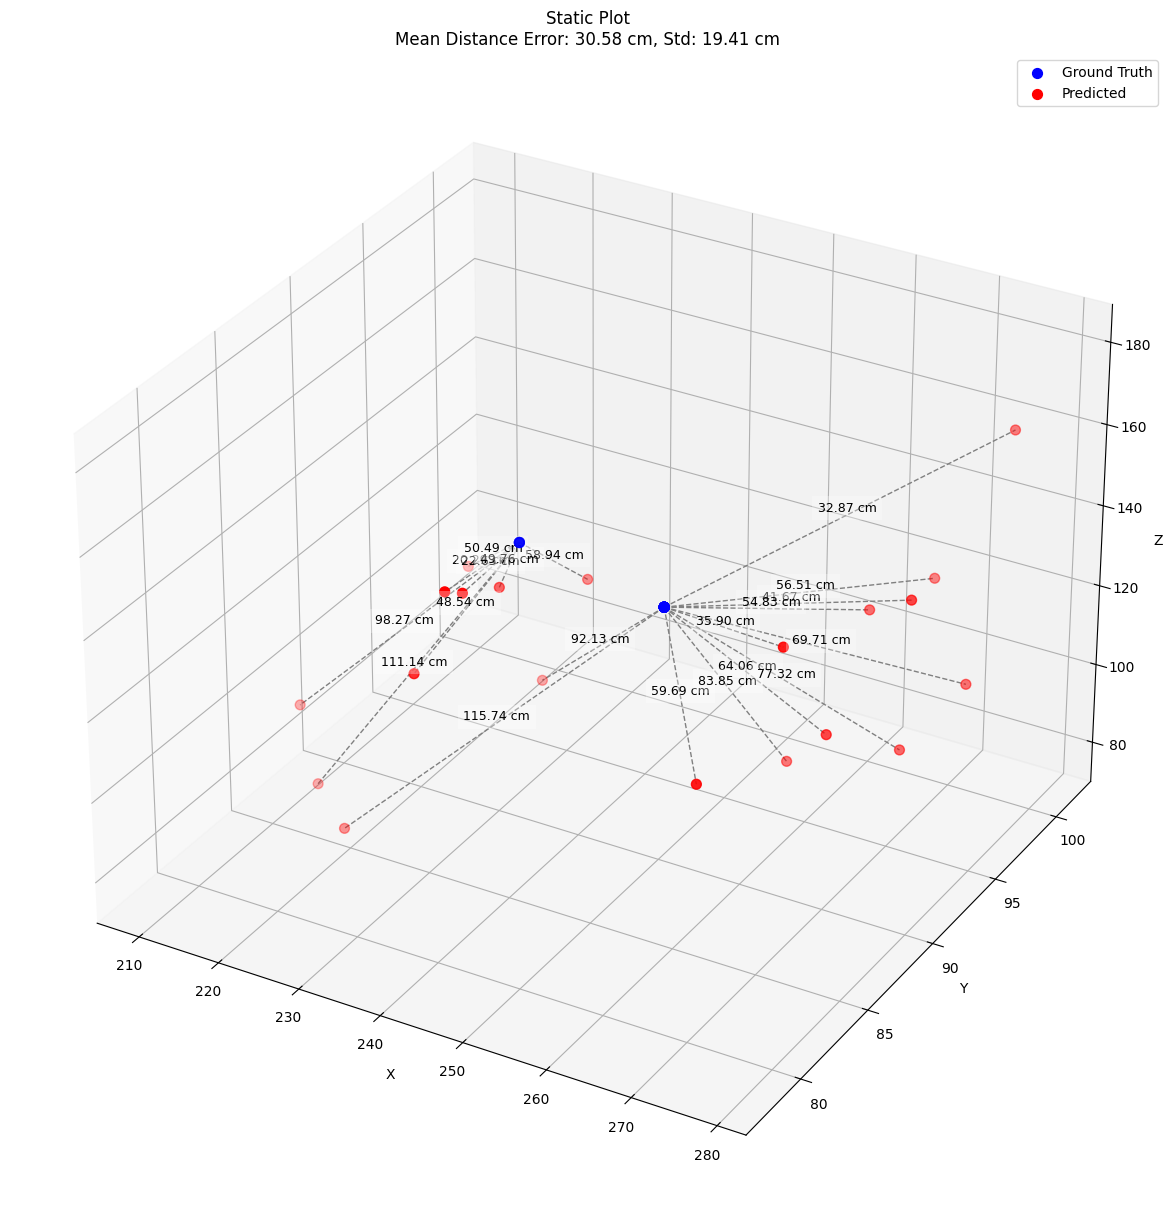

In [28]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

relu_model_64 = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= ReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

In [29]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 30.0895938873291,
  'std': 19.86444664001465},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 30.58211326599121,
  'std': 19.411802291870117},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 29.963424682617188,
  'std': 20.76791763305664})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [30]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 1.948511 | Loss test: 0.842307 | lr = 0.01
Epoch 10 | Loss train: 0.563047 | Loss test: 0.610453 | lr = 0.01
Epoch 20 | Loss train: 0.478211 | Loss test: 0.480704 | lr = 0.01
Epoch 30 | Loss train: 0.426115 | Loss test: 0.465268 | lr = 0.01
Epoch 40 | Loss train: 0.358799 | Loss test: 0.412082 | lr = 0.01
Epoch 50 | Loss train: 0.322829 | Loss test: 0.361769 | lr = 0.01
Epoch 60 | Loss train: 0.348118 | Loss test: 0.406181 | lr = 0.01
Epoch 70 | Loss train: 0.186538 | Loss test: 0.310985 | lr = 0.001
Epoch 80 | Loss train: 0.165302 | Loss test: 0.294946 | lr = 0.001
Epoch 90 | Loss train: 0.138287 | Loss test: 0.295706 | lr = 0.001
Epoch 100 | Loss train: 0.118852 | Loss test: 0.287131 | lr = 0.001
Epoch 110 | Loss train: 0.107808 | Loss test: 0.277828 | lr = 0.001
Epoch 120 | Loss train: 0.100133 | Loss test: 0.286121 | lr = 0.001
Epoch 130 | Loss train: 0.087687 | Loss test: 0.298532 | lr = 0.001
Epoch 140 | Loss train: 0.078823 | Loss test: 0.296221 | lr

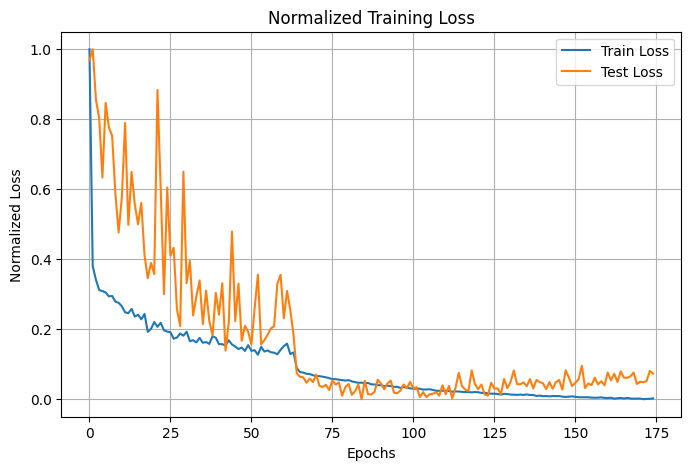

Fold 2
Epoch 0 | Loss train: 2.333905 | Loss test: 1.020229 | lr = 0.01
Epoch 10 | Loss train: 0.572321 | Loss test: 0.759838 | lr = 0.01
Epoch 20 | Loss train: 0.451550 | Loss test: 0.544585 | lr = 0.01
Epoch 30 | Loss train: 0.400872 | Loss test: 0.615656 | lr = 0.01
Epoch 40 | Loss train: 0.340027 | Loss test: 0.472663 | lr = 0.01
Epoch 50 | Loss train: 0.333702 | Loss test: 0.437953 | lr = 0.01
Epoch 60 | Loss train: 0.361654 | Loss test: 0.443327 | lr = 0.01
Epoch 70 | Loss train: 0.280119 | Loss test: 0.511791 | lr = 0.01
Epoch 80 | Loss train: 0.301092 | Loss test: 0.422478 | lr = 0.01
Epoch 90 | Loss train: 0.281905 | Loss test: 0.419704 | lr = 0.01
Epoch 100 | Loss train: 0.274257 | Loss test: 0.492366 | lr = 0.01
Epoch 110 | Loss train: 0.170958 | Loss test: 0.355419 | lr = 0.001
Epoch 120 | Loss train: 0.140777 | Loss test: 0.358794 | lr = 0.001
Epoch 130 | Loss train: 0.124308 | Loss test: 0.360089 | lr = 0.001
Epoch 140 | Loss train: 0.105676 | Loss test: 0.355480 | lr = 0

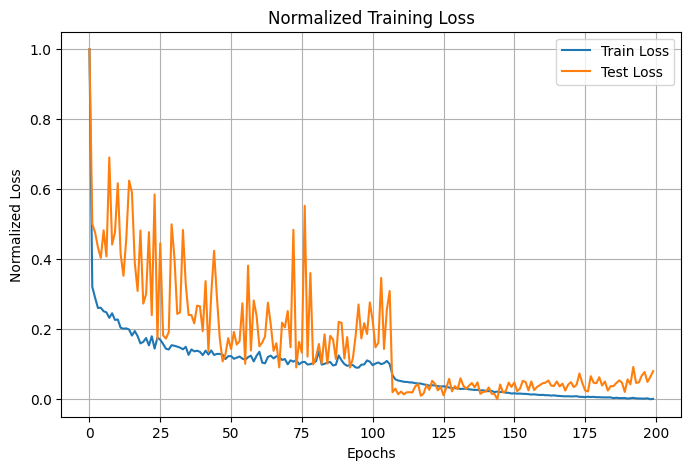

Fold 3
Epoch 0 | Loss train: 4.881317 | Loss test: 0.718244 | lr = 0.01
Epoch 10 | Loss train: 0.570311 | Loss test: 0.882428 | lr = 0.01
Epoch 20 | Loss train: 0.451652 | Loss test: 0.576263 | lr = 0.01
Epoch 30 | Loss train: 0.394410 | Loss test: 0.426214 | lr = 0.01
Epoch 40 | Loss train: 0.358473 | Loss test: 0.475779 | lr = 0.01
Epoch 50 | Loss train: 0.347267 | Loss test: 0.610697 | lr = 0.01
Epoch 60 | Loss train: 0.347384 | Loss test: 0.346568 | lr = 0.01
Epoch 70 | Loss train: 0.291541 | Loss test: 0.356416 | lr = 0.01
Epoch 80 | Loss train: 0.289294 | Loss test: 0.466872 | lr = 0.01
Epoch 90 | Loss train: 0.302429 | Loss test: 0.463301 | lr = 0.01
Epoch 100 | Loss train: 0.304858 | Loss test: 0.389491 | lr = 0.01
Epoch 110 | Loss train: 0.168189 | Loss test: 0.292994 | lr = 0.001
Epoch 120 | Loss train: 0.140296 | Loss test: 0.288477 | lr = 0.001
Epoch 130 | Loss train: 0.117347 | Loss test: 0.285225 | lr = 0.001
Epoch 140 | Loss train: 0.102547 | Loss test: 0.286120 | lr = 0

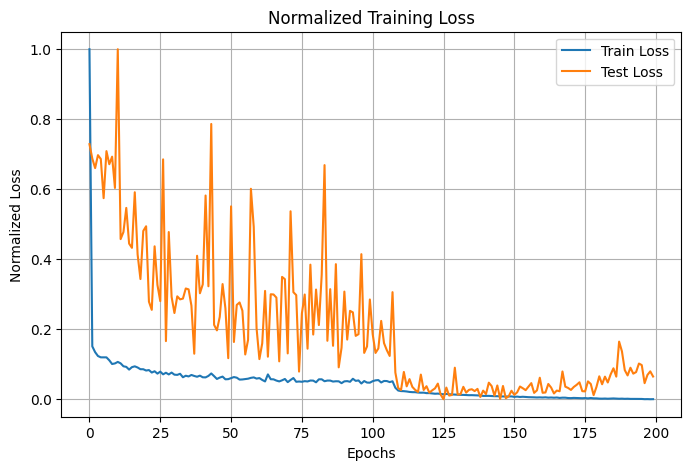

Fold 4
Epoch 0 | Loss train: 1.700064 | Loss test: 0.760953 | lr = 0.01
Epoch 10 | Loss train: 0.519851 | Loss test: 0.712802 | lr = 0.01
Epoch 20 | Loss train: 0.453647 | Loss test: 0.485427 | lr = 0.01
Epoch 30 | Loss train: 0.400177 | Loss test: 0.640971 | lr = 0.01
Epoch 40 | Loss train: 0.342650 | Loss test: 0.571812 | lr = 0.01
Epoch 50 | Loss train: 0.322457 | Loss test: 0.406543 | lr = 0.01
Epoch 60 | Loss train: 0.328776 | Loss test: 0.530737 | lr = 0.01
Epoch 70 | Loss train: 0.291798 | Loss test: 0.407619 | lr = 0.01
Epoch 80 | Loss train: 0.302280 | Loss test: 0.516095 | lr = 0.01
Epoch 90 | Loss train: 0.278293 | Loss test: 0.399266 | lr = 0.01
Epoch 100 | Loss train: 0.274129 | Loss test: 0.390160 | lr = 0.01
Epoch 110 | Loss train: 0.167908 | Loss test: 0.314582 | lr = 0.001
Epoch 120 | Loss train: 0.142061 | Loss test: 0.328784 | lr = 0.001
Epoch 130 | Loss train: 0.113986 | Loss test: 0.297485 | lr = 0.001
Epoch 140 | Loss train: 0.098399 | Loss test: 0.298889 | lr = 0

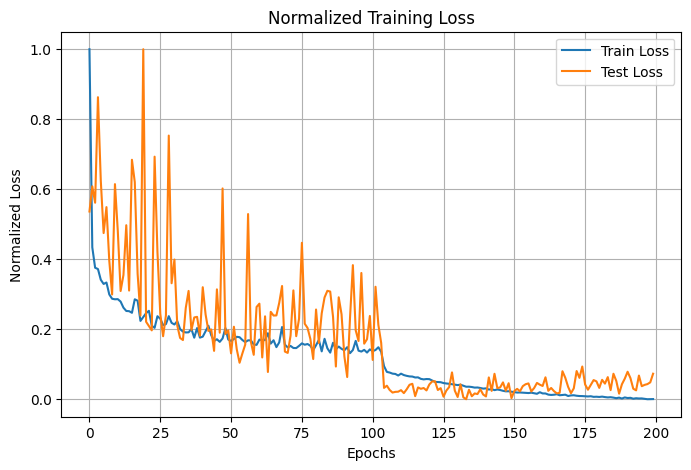

Fold 5
Epoch 0 | Loss train: 4.280498 | Loss test: 0.736787 | lr = 0.01
Epoch 10 | Loss train: 0.540757 | Loss test: 0.593117 | lr = 0.01
Epoch 20 | Loss train: 0.453729 | Loss test: 0.471251 | lr = 0.01
Epoch 30 | Loss train: 0.368635 | Loss test: 0.437124 | lr = 0.01
Epoch 40 | Loss train: 0.328532 | Loss test: 0.444520 | lr = 0.01
Epoch 50 | Loss train: 0.337132 | Loss test: 0.447871 | lr = 0.01
Epoch 60 | Loss train: 0.326219 | Loss test: 0.451182 | lr = 0.01
Epoch 70 | Loss train: 0.173004 | Loss test: 0.480852 | lr = 0.001
Epoch 80 | Loss train: 0.141760 | Loss test: 0.522907 | lr = 0.001
Epoch 90 | Loss train: 0.123685 | Loss test: 0.546148 | lr = 0.001
Epoch 100 | Loss train: 0.105908 | Loss test: 0.767840 | lr = 0.001
Epoch 110 | Loss train: 0.097433 | Loss test: 0.665978 | lr = 0.001
Epoch 120 | Loss train: 0.087164 | Loss test: 0.714570 | lr = 0.001
Early stopping at epoch 126
Loaded best model from temp_model.pth


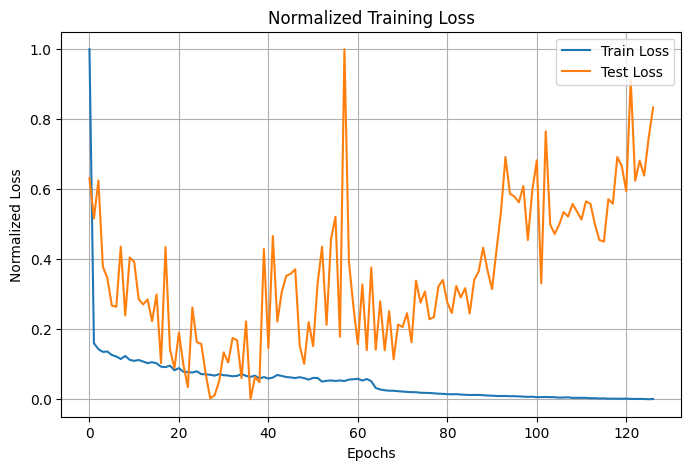

Cross-Validation finished with mean error across 5 subsets = 0.30707778261530966, evaluating final model...
Epoch 0 | Loss train: 1.801485 | lr = 0.01
Epoch 10 | Loss train: 0.524424 | lr = 0.01
Epoch 20 | Loss train: 0.418004 | lr = 0.01
Epoch 30 | Loss train: 0.397970 | lr = 0.01
Epoch 40 | Loss train: 0.345331 | lr = 0.01
Epoch 50 | Loss train: 0.356869 | lr = 0.01
Epoch 60 | Loss train: 0.337426 | lr = 0.001
Epoch 70 | Loss train: 0.176186 | lr = 0.001
Epoch 80 | Loss train: 0.148358 | lr = 0.001
Epoch 90 | Loss train: 0.121231 | lr = 0.001
Epoch 100 | Loss train: 0.107344 | lr = 0.001
Epoch 110 | Loss train: 0.094649 | lr = 0.001
Epoch 120 | Loss train: 0.086843 | lr = 0.001
Epoch 130 | Loss train: 0.080654 | lr = 0.001
Epoch 140 | Loss train: 0.073623 | lr = 0.001
Epoch 150 | Loss train: 0.068188 | lr = 0.001
Epoch 160 | Loss train: 0.066627 | lr = 0.001
Epoch 170 | Loss train: 0.060626 | lr = 0.001
Epoch 180 | Loss train: 0.059105 | lr = 0.001
Epoch 190 | Loss train: 0.053612 | 

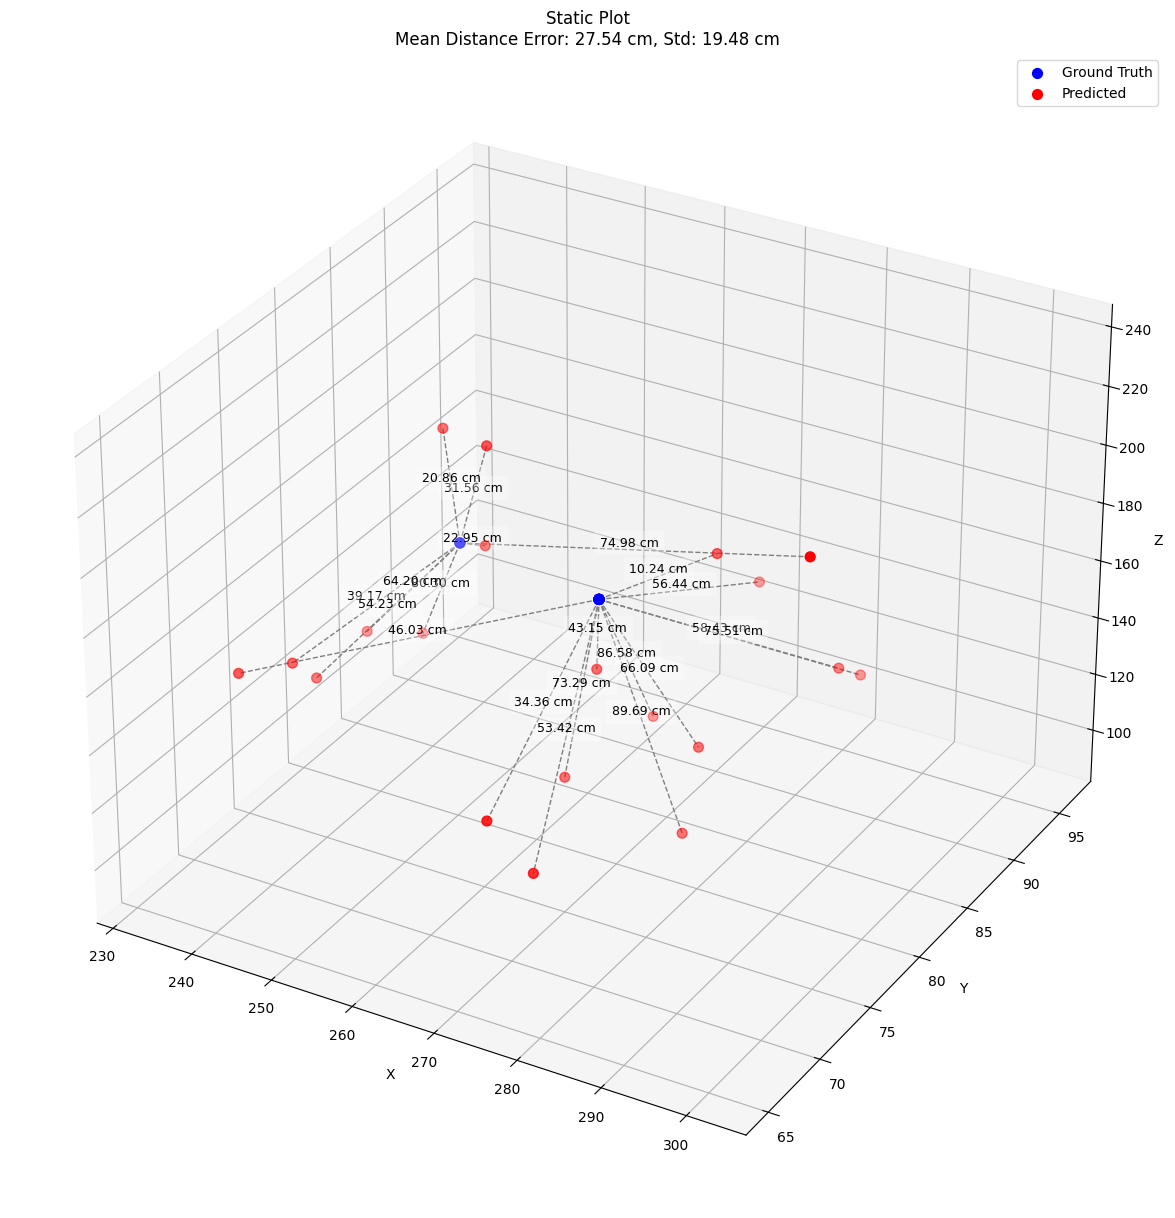

In [31]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= LeakyReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

In [32]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 27.5419864654541,
 'std': 19.47520637512207}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [33]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.982828 | Loss test: 0.992915 | lr = 0.01
Epoch 10 | Loss train: 0.859712 | Loss test: 0.968366 | lr = 0.01
Epoch 20 | Loss train: 0.845599 | Loss test: 0.939842 | lr = 0.01
Epoch 30 | Loss train: 0.820831 | Loss test: 0.926667 | lr = 0.01
Epoch 40 | Loss train: 0.760003 | Loss test: 0.890835 | lr = 0.001
Epoch 50 | Loss train: 0.727930 | Loss test: 0.902903 | lr = 0.001
Epoch 60 | Loss train: 0.720588 | Loss test: 0.881750 | lr = 0.001
Epoch 70 | Loss train: 0.722220 | Loss test: 0.884367 | lr = 0.001
Epoch 80 | Loss train: 0.714458 | Loss test: 0.879480 | lr = 0.001
Epoch 90 | Loss train: 0.713673 | Loss test: 0.856435 | lr = 0.001
Epoch 100 | Loss train: 0.707094 | Loss test: 0.864320 | lr = 0.001
Epoch 110 | Loss train: 0.699771 | Loss test: 0.868449 | lr = 0.001
Epoch 120 | Loss train: 0.696883 | Loss test: 0.879519 | lr = 0.001
Epoch 130 | Loss train: 0.697829 | Loss test: 0.851609 | lr = 0.001
Epoch 140 | Loss train: 0.684649 | Loss test: 0.857409 |

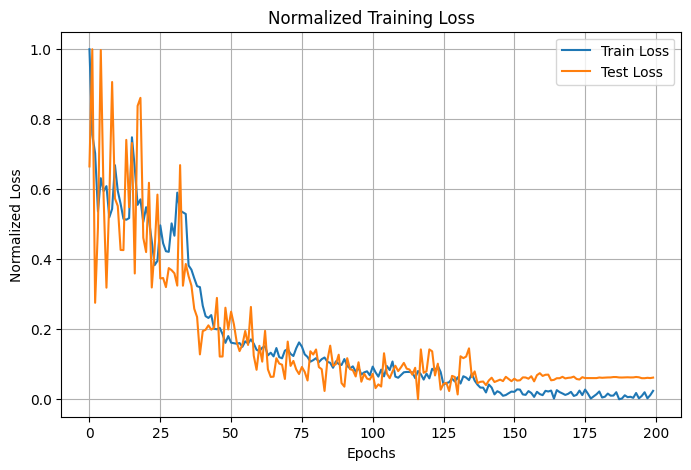

Fold 2
Epoch 0 | Loss train: 1.049724 | Loss test: 1.161374 | lr = 0.01
Epoch 10 | Loss train: 1.013439 | Loss test: 1.143065 | lr = 0.01
Epoch 20 | Loss train: 1.057690 | Loss test: 1.136541 | lr = 0.01
Epoch 30 | Loss train: 1.009461 | Loss test: 1.173879 | lr = 0.001
Epoch 40 | Loss train: 1.009685 | Loss test: 1.120603 | lr = 0.001
Epoch 50 | Loss train: 1.001872 | Loss test: 1.125107 | lr = 0.0001
Epoch 60 | Loss train: 0.995261 | Loss test: 1.125945 | lr = 0.0001
Epoch 70 | Loss train: 1.006198 | Loss test: 1.129539 | lr = 0.0001
Epoch 80 | Loss train: 1.002924 | Loss test: 1.127128 | lr = 1e-05
Epoch 90 | Loss train: 0.996874 | Loss test: 1.127058 | lr = 1e-05
Epoch 100 | Loss train: 1.000917 | Loss test: 1.127678 | lr = 1e-05
Early stopping at epoch 101
Loaded best model from temp_model.pth


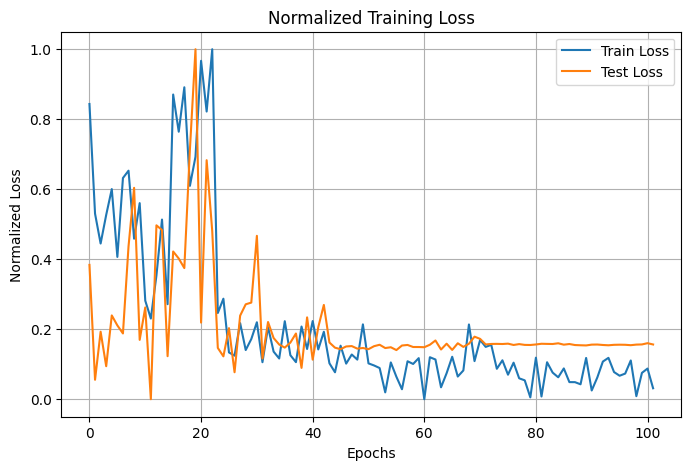

Fold 3
Epoch 0 | Loss train: 0.982911 | Loss test: 0.967318 | lr = 0.01
Epoch 10 | Loss train: 0.842921 | Loss test: 0.935365 | lr = 0.01
Epoch 20 | Loss train: 0.760848 | Loss test: 0.852737 | lr = 0.001
Epoch 30 | Loss train: 0.701191 | Loss test: 0.827726 | lr = 0.001
Epoch 40 | Loss train: 0.696133 | Loss test: 0.803254 | lr = 0.001
Epoch 50 | Loss train: 0.669085 | Loss test: 0.795728 | lr = 0.001
Epoch 60 | Loss train: 0.656220 | Loss test: 0.818430 | lr = 0.001
Epoch 70 | Loss train: 0.650401 | Loss test: 0.810386 | lr = 0.001
Epoch 80 | Loss train: 0.652469 | Loss test: 0.805889 | lr = 0.001
Epoch 90 | Loss train: 0.635188 | Loss test: 0.791044 | lr = 0.001
Epoch 100 | Loss train: 0.626506 | Loss test: 0.803139 | lr = 0.001
Epoch 110 | Loss train: 0.621283 | Loss test: 0.806833 | lr = 0.001
Epoch 120 | Loss train: 0.621111 | Loss test: 0.798219 | lr = 0.001
Epoch 130 | Loss train: 0.630670 | Loss test: 0.844816 | lr = 0.001
Epoch 140 | Loss train: 0.594933 | Loss test: 0.803245

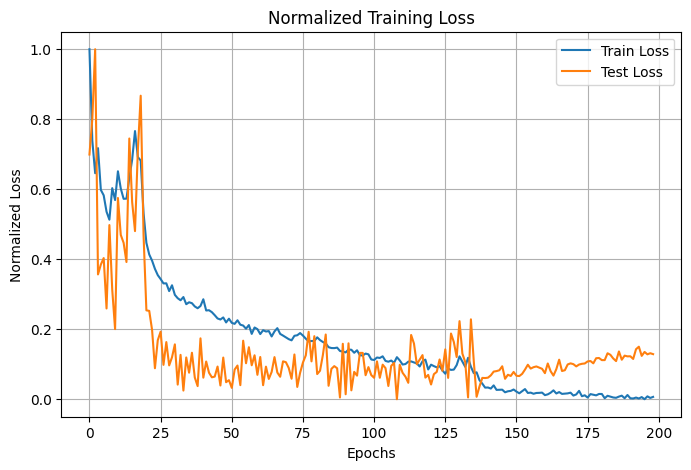

Fold 4
Epoch 0 | Loss train: 0.955156 | Loss test: 0.833773 | lr = 0.01
Epoch 10 | Loss train: 0.784190 | Loss test: 0.774895 | lr = 0.01
Epoch 20 | Loss train: 0.794617 | Loss test: 0.789490 | lr = 0.01
Epoch 30 | Loss train: 0.734276 | Loss test: 0.827757 | lr = 0.01
Epoch 40 | Loss train: 0.756618 | Loss test: 0.805830 | lr = 0.01
Epoch 50 | Loss train: 0.676437 | Loss test: 0.714362 | lr = 0.001
Epoch 60 | Loss train: 0.676334 | Loss test: 0.714855 | lr = 0.001
Epoch 70 | Loss train: 0.655638 | Loss test: 0.704388 | lr = 0.001
Epoch 80 | Loss train: 0.652603 | Loss test: 0.694017 | lr = 0.001
Epoch 90 | Loss train: 0.646216 | Loss test: 0.699986 | lr = 0.0001
Epoch 100 | Loss train: 0.643738 | Loss test: 0.702385 | lr = 0.0001
Epoch 110 | Loss train: 0.648064 | Loss test: 0.699842 | lr = 0.0001
Epoch 120 | Loss train: 0.643367 | Loss test: 0.702570 | lr = 1e-05
Epoch 130 | Loss train: 0.647043 | Loss test: 0.703365 | lr = 1e-05
Epoch 140 | Loss train: 0.641736 | Loss test: 0.702993

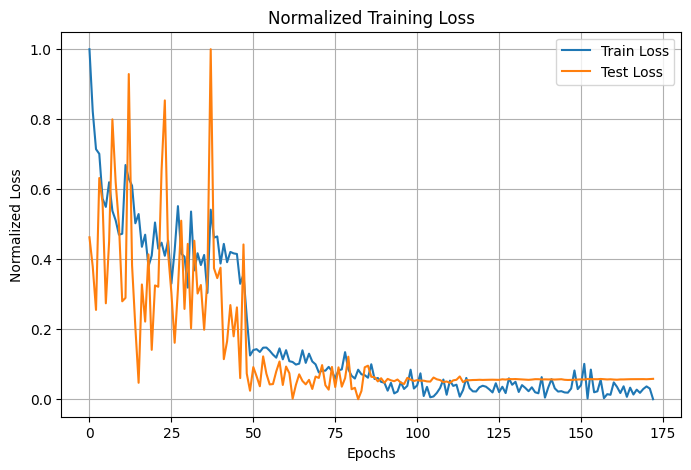

Fold 5
Epoch 0 | Loss train: 0.989116 | Loss test: 1.045000 | lr = 0.01
Epoch 10 | Loss train: 0.876091 | Loss test: 1.011313 | lr = 0.01
Epoch 20 | Loss train: 0.886741 | Loss test: 1.003243 | lr = 0.01
Epoch 30 | Loss train: 0.850242 | Loss test: 0.957600 | lr = 0.01
Epoch 40 | Loss train: 0.789700 | Loss test: 0.749512 | lr = 0.001
Epoch 50 | Loss train: 0.762826 | Loss test: 0.737066 | lr = 0.001
Epoch 60 | Loss train: 0.756725 | Loss test: 0.736281 | lr = 0.001
Epoch 70 | Loss train: 0.751399 | Loss test: 0.727411 | lr = 0.001
Epoch 80 | Loss train: 0.740653 | Loss test: 0.730019 | lr = 0.001
Epoch 90 | Loss train: 0.736355 | Loss test: 0.731967 | lr = 0.001
Epoch 100 | Loss train: 0.732687 | Loss test: 0.733561 | lr = 0.001
Epoch 110 | Loss train: 0.721232 | Loss test: 0.700979 | lr = 0.001
Epoch 120 | Loss train: 0.713582 | Loss test: 0.718365 | lr = 0.001
Epoch 130 | Loss train: 0.715336 | Loss test: 0.719728 | lr = 0.001
Epoch 140 | Loss train: 0.700369 | Loss test: 0.711526 |

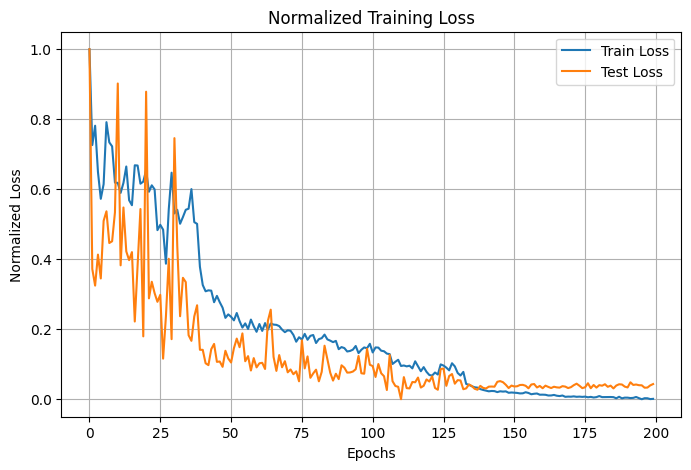

Cross-Validation finished with mean error across 5 subsets = 0.825079500788734, evaluating final model...
Epoch 0 | Loss train: 1.004496 | lr = 0.01
Epoch 10 | Loss train: 0.909605 | lr = 0.01
Epoch 20 | Loss train: 0.895361 | lr = 0.001
Epoch 30 | Loss train: 0.870571 | lr = 0.001
Epoch 40 | Loss train: 0.865036 | lr = 0.001
Epoch 50 | Loss train: 0.849357 | lr = 0.0001
Epoch 60 | Loss train: 0.831152 | lr = 0.0001
Epoch 70 | Loss train: 0.823182 | lr = 0.0001
Epoch 80 | Loss train: 0.819618 | lr = 0.0001
Epoch 90 | Loss train: 0.818638 | lr = 0.0001
Epoch 100 | Loss train: 0.818190 | lr = 0.0001
Epoch 110 | Loss train: 0.816277 | lr = 0.0001
Epoch 120 | Loss train: 0.815653 | lr = 0.0001
Epoch 130 | Loss train: 0.814731 | lr = 0.0001
Epoch 140 | Loss train: 0.814679 | lr = 0.0001
Epoch 150 | Loss train: 0.813904 | lr = 1e-05
Epoch 160 | Loss train: 0.813703 | lr = 1e-05
Epoch 170 | Loss train: 0.813977 | lr = 1e-05
Epoch 180 | Loss train: 0.813648 | lr = 1e-05
Epoch 190 | Loss train:

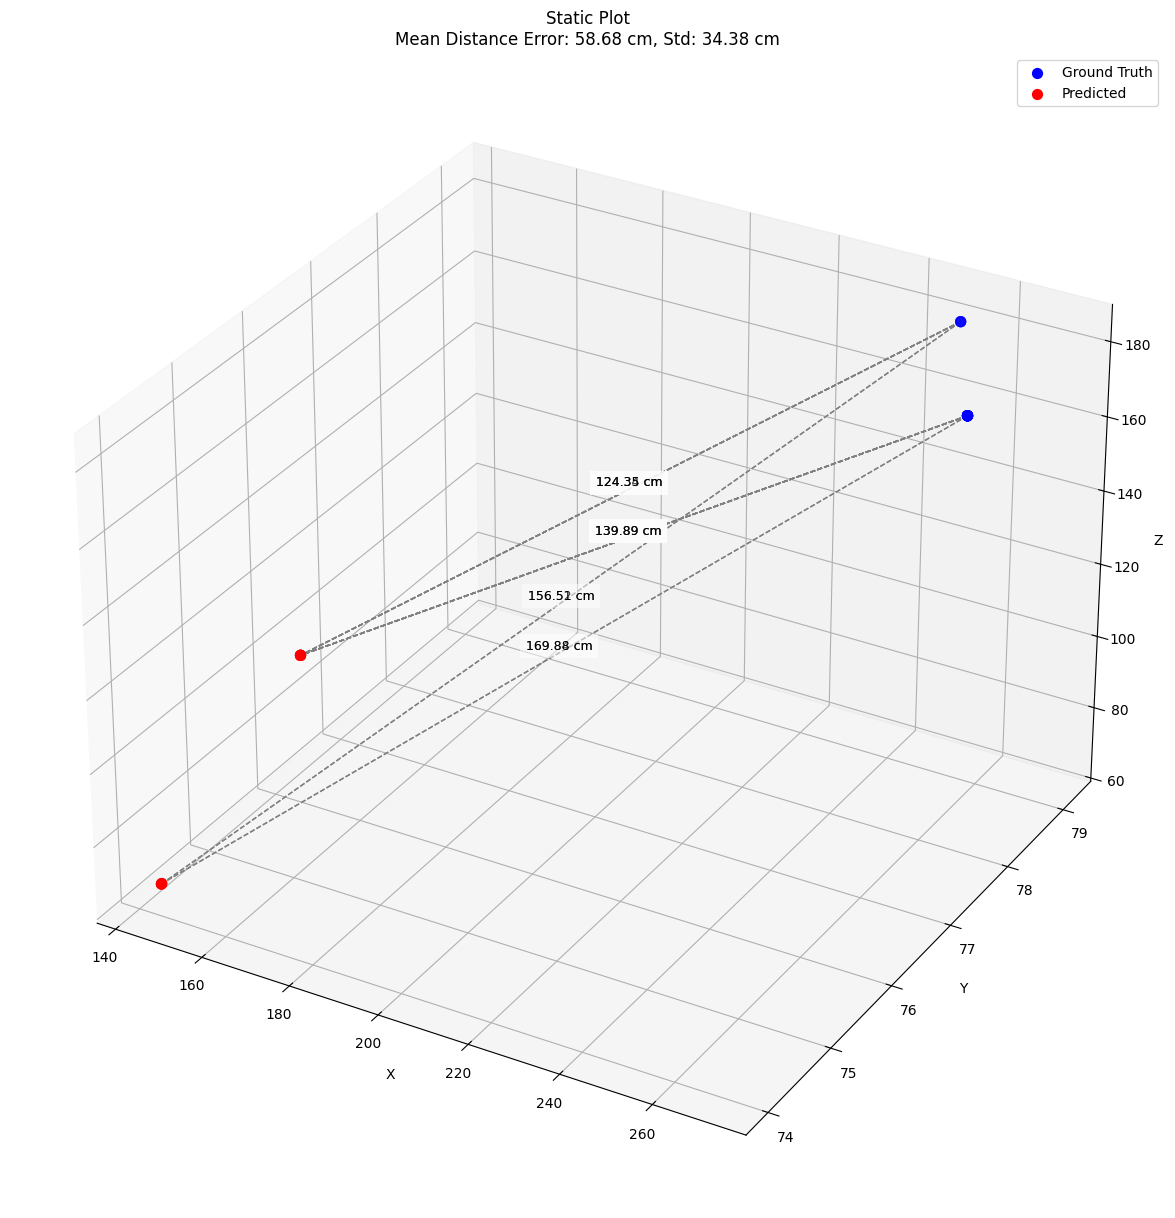

In [34]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

tanh_model = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= tanhModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [35]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.961900 | Loss test: 0.924434 | lr = 0.01
Epoch 10 | Loss train: 0.814818 | Loss test: 0.883939 | lr = 0.01
Epoch 20 | Loss train: 0.797296 | Loss test: 0.909591 | lr = 0.01
Epoch 30 | Loss train: 0.791146 | Loss test: 0.901260 | lr = 0.01
Epoch 40 | Loss train: 0.795285 | Loss test: 0.905294 | lr = 0.01
Epoch 50 | Loss train: 0.807722 | Loss test: 0.934139 | lr = 0.01
Epoch 60 | Loss train: 0.784317 | Loss test: 0.896251 | lr = 0.001
Epoch 70 | Loss train: 0.773850 | Loss test: 0.900245 | lr = 0.001
Epoch 80 | Loss train: 0.770121 | Loss test: 0.897555 | lr = 0.001
Epoch 90 | Loss train: 0.764213 | Loss test: 0.900706 | lr = 0.0001
Early stopping at epoch 96
Loaded best model from temp_model.pth


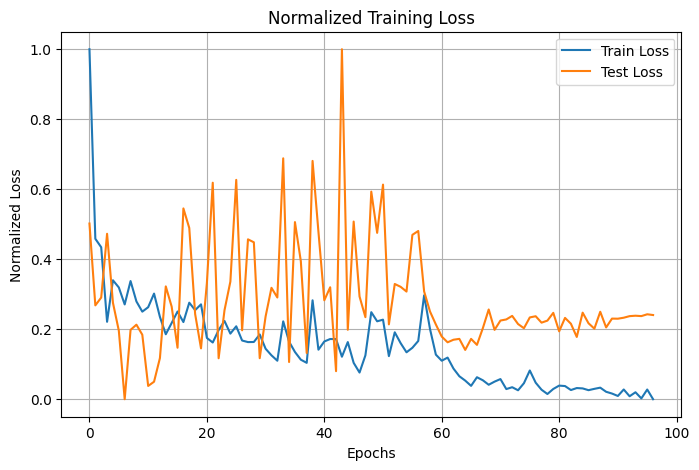

Fold 2
Epoch 0 | Loss train: 0.984708 | Loss test: 1.012333 | lr = 0.01
Epoch 10 | Loss train: 0.832476 | Loss test: 0.834677 | lr = 0.01
Epoch 20 | Loss train: 0.825353 | Loss test: 0.909848 | lr = 0.01
Epoch 30 | Loss train: 0.833795 | Loss test: 0.901023 | lr = 0.001
Epoch 40 | Loss train: 0.801698 | Loss test: 0.823507 | lr = 0.001
Epoch 50 | Loss train: 0.794326 | Loss test: 0.821580 | lr = 0.001
Epoch 60 | Loss train: 0.784306 | Loss test: 0.823072 | lr = 0.001
Epoch 70 | Loss train: 0.790451 | Loss test: 0.822562 | lr = 0.001
Epoch 80 | Loss train: 0.786649 | Loss test: 0.821965 | lr = 0.0001
Epoch 90 | Loss train: 0.781289 | Loss test: 0.822715 | lr = 0.0001
Epoch 100 | Loss train: 0.784574 | Loss test: 0.821936 | lr = 1e-05
Epoch 110 | Loss train: 0.780784 | Loss test: 0.821847 | lr = 1e-05
Epoch 120 | Loss train: 0.782306 | Loss test: 0.821930 | lr = 1e-05
Epoch 130 | Loss train: 0.783293 | Loss test: 0.821976 | lr = 1e-05
Early stopping at epoch 134
Loaded best model from te

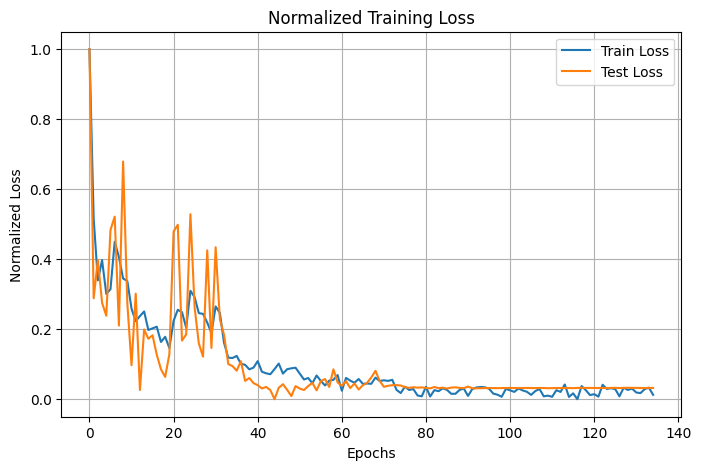

Fold 3
Epoch 0 | Loss train: 0.921566 | Loss test: 1.075397 | lr = 0.01
Epoch 10 | Loss train: 0.760207 | Loss test: 0.848024 | lr = 0.01
Epoch 20 | Loss train: 0.704661 | Loss test: 0.810916 | lr = 0.01
Epoch 30 | Loss train: 0.713505 | Loss test: 0.810883 | lr = 0.01
Epoch 40 | Loss train: 0.707125 | Loss test: 0.834232 | lr = 0.01
Epoch 50 | Loss train: 0.722558 | Loss test: 0.795857 | lr = 0.001
Epoch 60 | Loss train: 0.662834 | Loss test: 0.809252 | lr = 0.001
Epoch 70 | Loss train: 0.655176 | Loss test: 0.805360 | lr = 0.001
Epoch 80 | Loss train: 0.654529 | Loss test: 0.808435 | lr = 0.001
Epoch 90 | Loss train: 0.643178 | Loss test: 0.807698 | lr = 0.001
Epoch 100 | Loss train: 0.634887 | Loss test: 0.800433 | lr = 0.001
Epoch 110 | Loss train: 0.624004 | Loss test: 0.797001 | lr = 0.001
Epoch 120 | Loss train: 0.602973 | Loss test: 0.778052 | lr = 0.001
Early stopping at epoch 128
Loaded best model from temp_model.pth


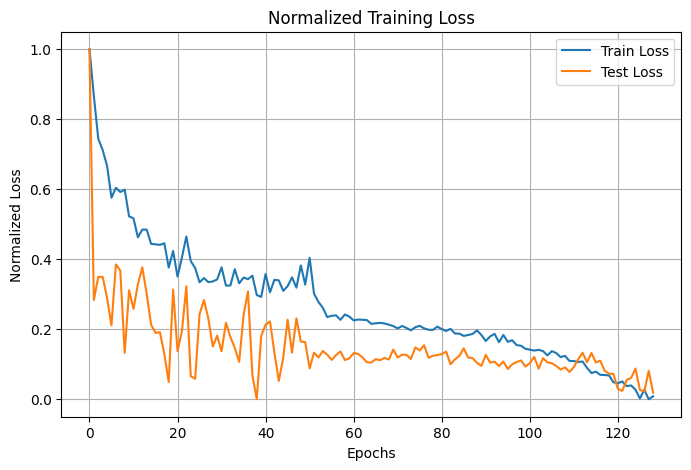

Fold 4
Epoch 0 | Loss train: 1.021671 | Loss test: 0.836299 | lr = 0.01
Epoch 10 | Loss train: 0.799977 | Loss test: 0.759386 | lr = 0.01
Epoch 20 | Loss train: 0.724969 | Loss test: 0.756627 | lr = 0.01
Epoch 30 | Loss train: 0.704151 | Loss test: 0.742193 | lr = 0.01
Epoch 40 | Loss train: 0.690617 | Loss test: 0.716572 | lr = 0.01
Epoch 50 | Loss train: 0.678627 | Loss test: 0.709819 | lr = 0.01
Epoch 60 | Loss train: 0.701523 | Loss test: 0.756774 | lr = 0.01
Epoch 70 | Loss train: 0.633970 | Loss test: 0.709575 | lr = 0.001
Epoch 80 | Loss train: 0.609094 | Loss test: 0.711679 | lr = 0.001
Epoch 90 | Loss train: 0.614610 | Loss test: 0.705414 | lr = 0.001
Epoch 100 | Loss train: 0.607015 | Loss test: 0.706020 | lr = 0.001
Epoch 110 | Loss train: 0.606925 | Loss test: 0.697007 | lr = 0.001
Epoch 120 | Loss train: 0.605512 | Loss test: 0.694109 | lr = 0.001
Epoch 130 | Loss train: 0.599415 | Loss test: 0.702096 | lr = 0.001
Epoch 140 | Loss train: 0.600264 | Loss test: 0.705420 | lr

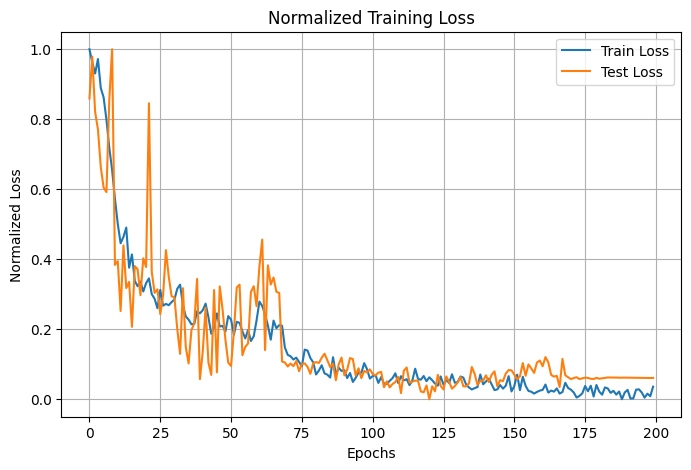

Fold 5
Epoch 0 | Loss train: 1.005216 | Loss test: 0.871909 | lr = 0.01
Epoch 10 | Loss train: 0.749916 | Loss test: 0.757494 | lr = 0.01
Epoch 20 | Loss train: 0.731100 | Loss test: 0.774357 | lr = 0.01
Epoch 30 | Loss train: 0.707487 | Loss test: 0.735084 | lr = 0.01
Epoch 40 | Loss train: 0.676197 | Loss test: 0.667111 | lr = 0.01
Epoch 50 | Loss train: 0.665146 | Loss test: 0.693728 | lr = 0.01
Epoch 60 | Loss train: 0.647098 | Loss test: 0.704992 | lr = 0.001
Epoch 70 | Loss train: 0.634272 | Loss test: 0.684980 | lr = 0.001
Epoch 80 | Loss train: 0.629601 | Loss test: 0.692026 | lr = 0.001
Epoch 90 | Loss train: 0.627463 | Loss test: 0.676716 | lr = 0.001
Epoch 100 | Loss train: 0.623235 | Loss test: 0.672100 | lr = 0.001
Epoch 110 | Loss train: 0.623053 | Loss test: 0.668424 | lr = 0.001
Epoch 120 | Loss train: 0.621969 | Loss test: 0.676020 | lr = 0.001
Epoch 130 | Loss train: 0.609202 | Loss test: 0.673077 | lr = 0.001
Early stopping at epoch 139
Loaded best model from temp_mo

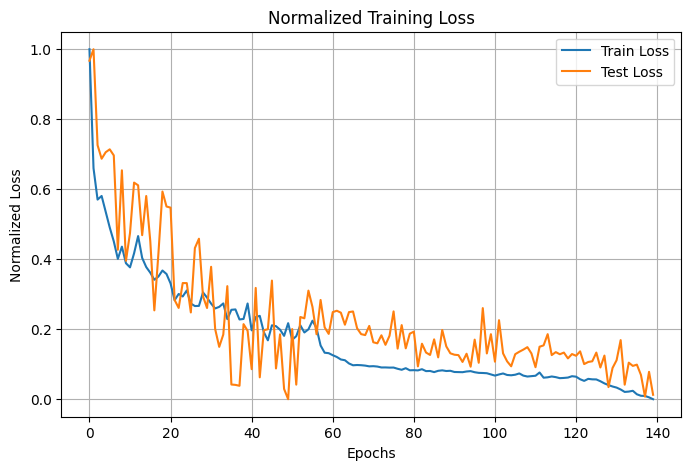

Cross-Validation finished with mean error across 5 subsets = 0.7612798536107653, evaluating final model...
Epoch 0 | Loss train: 1.029971 | lr = 0.01
Epoch 10 | Loss train: 1.000528 | lr = 0.01
Epoch 20 | Loss train: 0.848091 | lr = 0.01
Epoch 30 | Loss train: 0.831705 | lr = 0.01
Epoch 40 | Loss train: 0.823365 | lr = 0.01
Epoch 50 | Loss train: 0.823154 | lr = 0.01
Epoch 60 | Loss train: 0.800240 | lr = 0.01
Epoch 70 | Loss train: 0.796832 | lr = 0.01
Epoch 80 | Loss train: 0.780430 | lr = 0.001
Epoch 90 | Loss train: 0.759865 | lr = 0.001
Epoch 100 | Loss train: 0.680558 | lr = 0.001
Epoch 110 | Loss train: 0.650228 | lr = 0.001
Epoch 120 | Loss train: 0.635971 | lr = 0.001
Epoch 130 | Loss train: 0.619391 | lr = 0.001
Epoch 140 | Loss train: 0.609303 | lr = 0.001
Epoch 150 | Loss train: 0.598121 | lr = 0.001
Epoch 160 | Loss train: 0.584130 | lr = 0.001
Epoch 170 | Loss train: 0.553629 | lr = 0.001
Epoch 180 | Loss train: 0.498857 | lr = 0.001
Epoch 190 | Loss train: 0.456420 | lr 

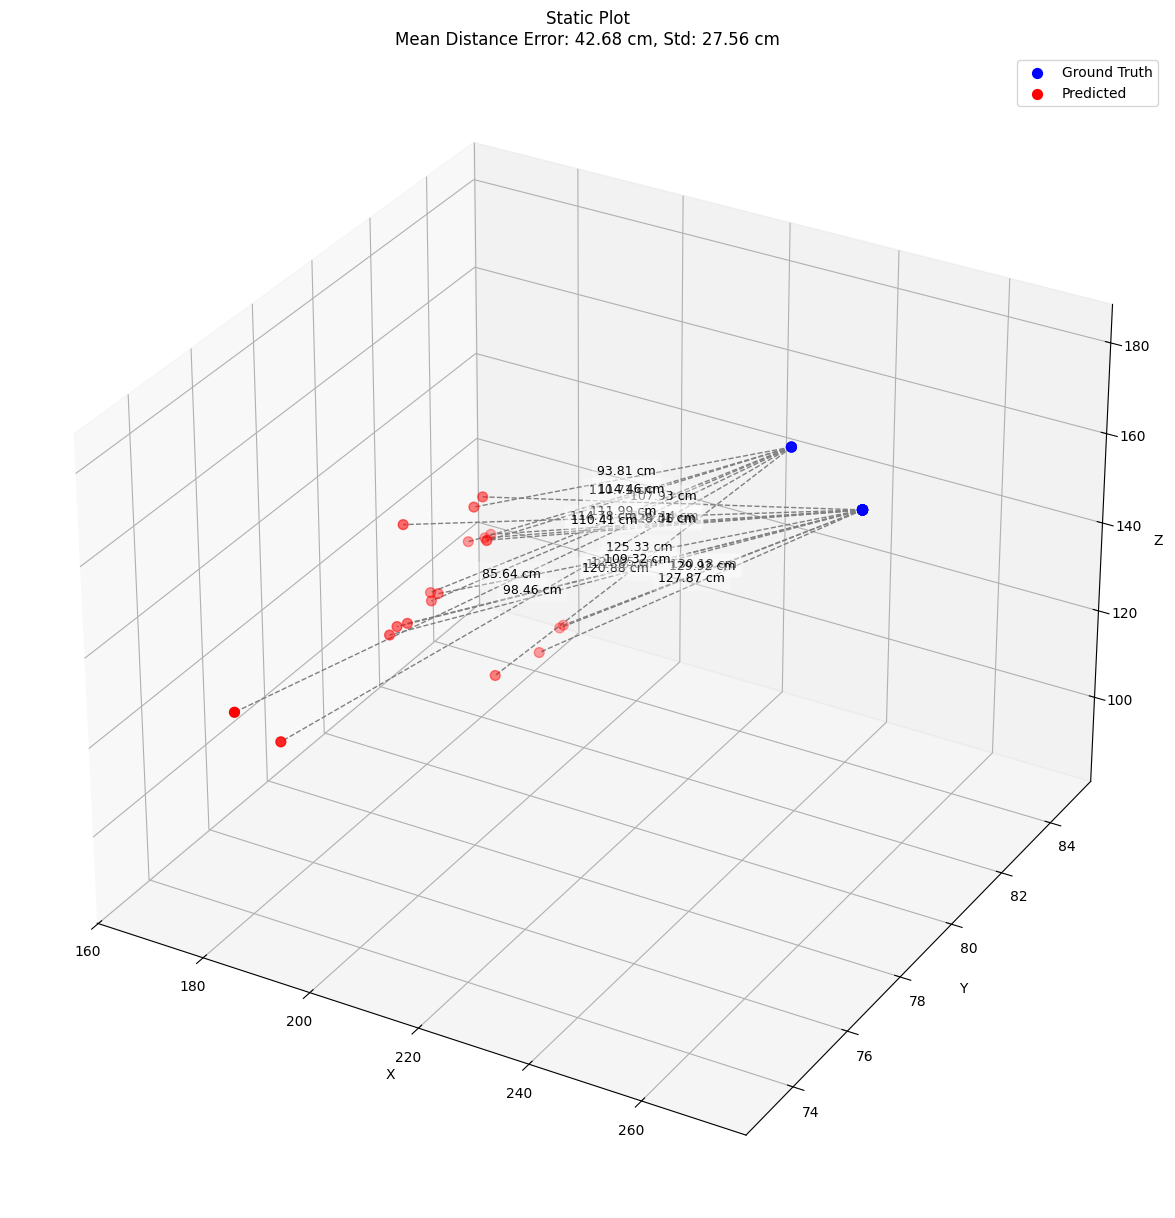

In [36]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

sigmoid_model = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= sigmoidModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [37]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.953859 | Loss test: 0.860552 | lr = 0.01
Epoch 10 | Loss train: 0.521172 | Loss test: 0.646248 | lr = 0.01
Epoch 20 | Loss train: 0.444914 | Loss test: 0.453077 | lr = 0.01
Epoch 30 | Loss train: 0.408514 | Loss test: 0.546199 | lr = 0.01
Epoch 40 | Loss train: 0.356238 | Loss test: 0.498732 | lr = 0.01
Epoch 50 | Loss train: 0.313001 | Loss test: 0.342994 | lr = 0.01
Epoch 60 | Loss train: 0.274677 | Loss test: 0.407232 | lr = 0.01
Epoch 70 | Loss train: 0.284398 | Loss test: 0.293777 | lr = 0.01
Epoch 80 | Loss train: 0.151316 | Loss test: 0.257736 | lr = 0.001
Epoch 90 | Loss train: 0.128000 | Loss test: 0.349875 | lr = 0.001
Epoch 100 | Loss train: 0.102546 | Loss test: 0.390160 | lr = 0.001
Epoch 110 | Loss train: 0.089960 | Loss test: 0.408788 | lr = 0.001
Epoch 120 | Loss train: 0.078684 | Loss test: 0.469235 | lr = 0.001
Epoch 130 | Loss train: 0.071565 | Loss test: 0.413820 | lr = 0.001
Epoch 140 | Loss train: 0.065443 | Loss test: 0.379575 | lr 

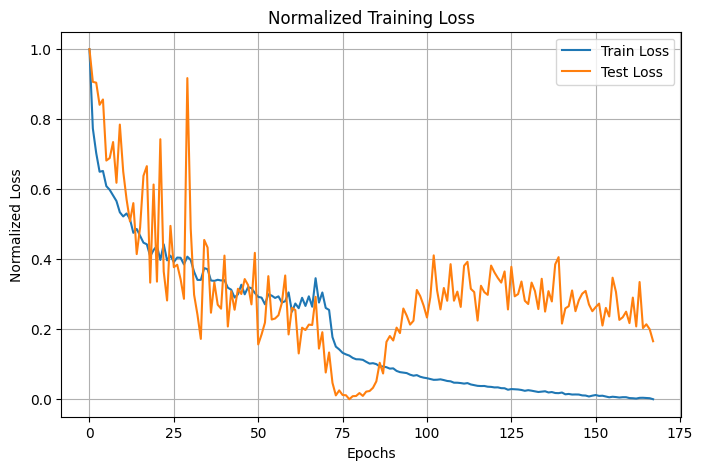

Fold 2
Epoch 0 | Loss train: 0.942466 | Loss test: 0.792105 | lr = 0.01
Epoch 10 | Loss train: 0.510681 | Loss test: 0.613704 | lr = 0.01
Epoch 20 | Loss train: 0.423509 | Loss test: 0.488763 | lr = 0.01
Epoch 30 | Loss train: 0.346688 | Loss test: 0.603724 | lr = 0.01
Epoch 40 | Loss train: 0.295306 | Loss test: 0.426079 | lr = 0.01
Epoch 50 | Loss train: 0.306204 | Loss test: 0.449853 | lr = 0.01
Epoch 60 | Loss train: 0.294790 | Loss test: 0.389254 | lr = 0.01
Epoch 70 | Loss train: 0.250476 | Loss test: 0.447924 | lr = 0.01
Epoch 80 | Loss train: 0.130608 | Loss test: 0.312132 | lr = 0.001
Epoch 90 | Loss train: 0.106155 | Loss test: 0.344793 | lr = 0.001
Epoch 100 | Loss train: 0.090351 | Loss test: 0.315288 | lr = 0.001
Epoch 110 | Loss train: 0.074912 | Loss test: 0.324889 | lr = 0.001
Epoch 120 | Loss train: 0.062279 | Loss test: 0.335164 | lr = 0.001
Epoch 130 | Loss train: 0.053374 | Loss test: 0.332822 | lr = 0.001
Epoch 140 | Loss train: 0.048675 | Loss test: 0.330508 | lr 

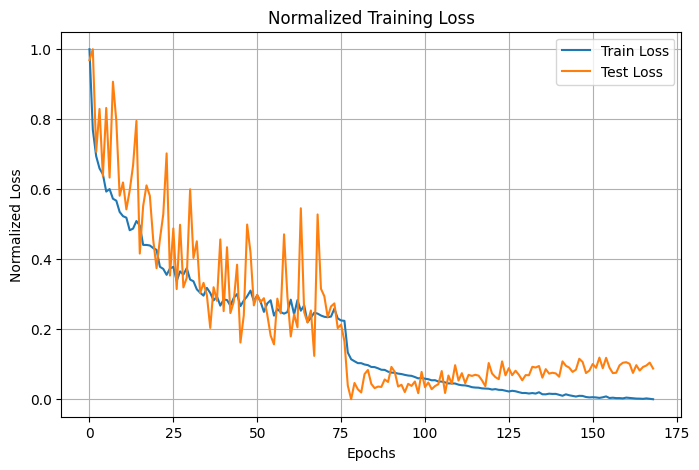

Fold 3
Epoch 0 | Loss train: 0.945547 | Loss test: 0.928076 | lr = 0.01
Epoch 10 | Loss train: 0.537268 | Loss test: 0.550660 | lr = 0.01
Epoch 20 | Loss train: 0.419728 | Loss test: 0.451458 | lr = 0.01
Epoch 30 | Loss train: 0.356738 | Loss test: 0.388064 | lr = 0.01
Epoch 40 | Loss train: 0.341889 | Loss test: 0.472435 | lr = 0.01
Epoch 50 | Loss train: 0.311838 | Loss test: 0.286638 | lr = 0.01
Epoch 60 | Loss train: 0.294996 | Loss test: 0.369312 | lr = 0.01
Epoch 70 | Loss train: 0.303705 | Loss test: 0.307150 | lr = 0.01
Epoch 80 | Loss train: 0.263090 | Loss test: 0.397265 | lr = 0.01
Epoch 90 | Loss train: 0.241971 | Loss test: 0.331240 | lr = 0.01
Epoch 100 | Loss train: 0.286736 | Loss test: 0.274852 | lr = 0.01
Epoch 110 | Loss train: 0.121494 | Loss test: 0.256026 | lr = 0.001
Epoch 120 | Loss train: 0.098979 | Loss test: 0.233481 | lr = 0.001
Epoch 130 | Loss train: 0.081424 | Loss test: 0.213574 | lr = 0.001
Epoch 140 | Loss train: 0.071618 | Loss test: 0.224693 | lr = 0

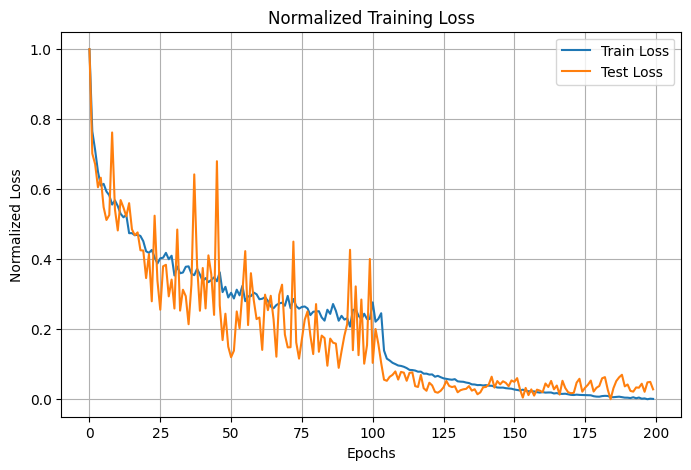

Fold 4
Epoch 0 | Loss train: 1.415565 | Loss test: 0.832537 | lr = 0.01
Epoch 10 | Loss train: 0.479696 | Loss test: 0.624297 | lr = 0.01
Epoch 20 | Loss train: 0.393574 | Loss test: 0.531985 | lr = 0.01
Epoch 30 | Loss train: 0.331378 | Loss test: 0.487039 | lr = 0.01
Epoch 40 | Loss train: 0.272785 | Loss test: 0.473285 | lr = 0.01
Epoch 50 | Loss train: 0.288206 | Loss test: 0.449502 | lr = 0.01
Epoch 60 | Loss train: 0.197521 | Loss test: 0.346592 | lr = 0.001
Epoch 70 | Loss train: 0.125275 | Loss test: 0.325362 | lr = 0.001
Epoch 80 | Loss train: 0.102485 | Loss test: 0.319931 | lr = 0.001
Epoch 90 | Loss train: 0.086736 | Loss test: 0.353959 | lr = 0.001
Epoch 100 | Loss train: 0.074811 | Loss test: 0.318004 | lr = 0.001
Epoch 110 | Loss train: 0.063291 | Loss test: 0.325851 | lr = 0.001
Epoch 120 | Loss train: 0.057657 | Loss test: 0.327530 | lr = 0.001
Epoch 130 | Loss train: 0.054063 | Loss test: 0.335622 | lr = 0.001
Epoch 140 | Loss train: 0.046461 | Loss test: 0.334872 | l

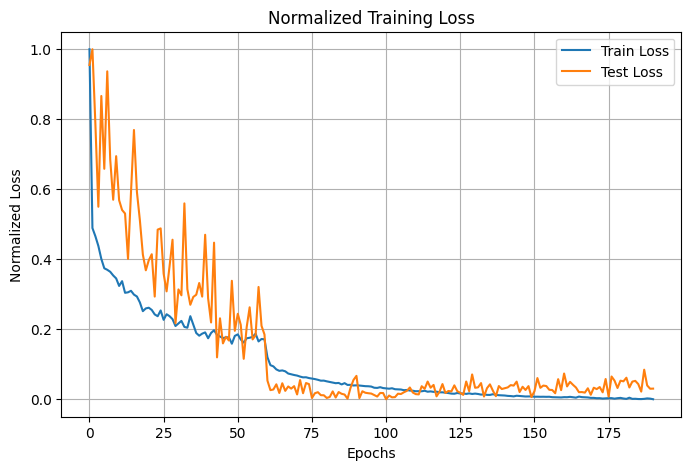

Fold 5
Epoch 0 | Loss train: 1.044446 | Loss test: 1.145921 | lr = 0.01
Epoch 10 | Loss train: 0.543921 | Loss test: 0.622684 | lr = 0.01
Epoch 20 | Loss train: 0.441946 | Loss test: 0.578359 | lr = 0.01
Epoch 30 | Loss train: 0.374322 | Loss test: 0.412882 | lr = 0.01
Epoch 40 | Loss train: 0.309061 | Loss test: 0.470971 | lr = 0.01
Epoch 50 | Loss train: 0.276009 | Loss test: 1.512320 | lr = 0.01
Epoch 60 | Loss train: 0.291461 | Loss test: 0.413143 | lr = 0.01
Epoch 70 | Loss train: 0.240570 | Loss test: 0.431082 | lr = 0.01
Epoch 80 | Loss train: 0.221236 | Loss test: 0.408431 | lr = 0.01
Epoch 90 | Loss train: 0.229955 | Loss test: 1.058157 | lr = 0.01
Epoch 100 | Loss train: 0.219476 | Loss test: 0.503379 | lr = 0.01
Epoch 110 | Loss train: 0.116106 | Loss test: 0.871109 | lr = 0.001
Epoch 120 | Loss train: 0.097404 | Loss test: 1.733676 | lr = 0.001
Epoch 130 | Loss train: 0.084134 | Loss test: 1.518268 | lr = 0.001
Epoch 140 | Loss train: 0.071458 | Loss test: 1.666996 | lr = 0

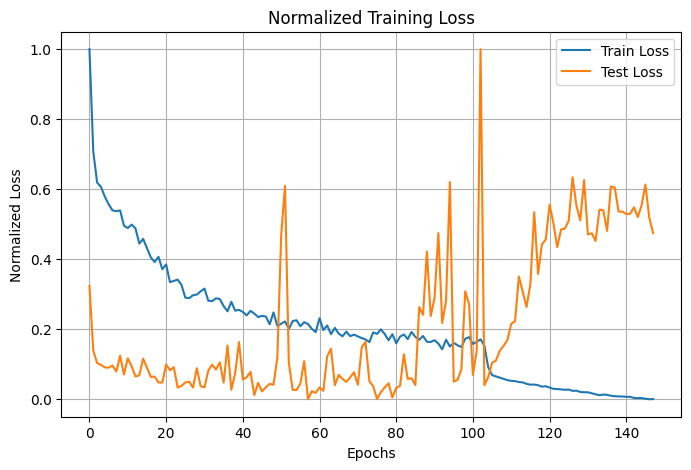

Cross-Validation finished with mean error across 5 subsets = 0.2777550125547818, evaluating final model...
Epoch 0 | Loss train: 0.872566 | lr = 0.01
Epoch 10 | Loss train: 0.510605 | lr = 0.01
Epoch 20 | Loss train: 0.402035 | lr = 0.01
Epoch 30 | Loss train: 0.343953 | lr = 0.01
Epoch 40 | Loss train: 0.345865 | lr = 0.01
Epoch 50 | Loss train: 0.302394 | lr = 0.01
Epoch 60 | Loss train: 0.265731 | lr = 0.01
Epoch 70 | Loss train: 0.267493 | lr = 0.01
Epoch 80 | Loss train: 0.258126 | lr = 0.01
Epoch 90 | Loss train: 0.138217 | lr = 0.001
Epoch 100 | Loss train: 0.110793 | lr = 0.001
Epoch 110 | Loss train: 0.089731 | lr = 0.001
Epoch 120 | Loss train: 0.075668 | lr = 0.001
Epoch 130 | Loss train: 0.066538 | lr = 0.001
Epoch 140 | Loss train: 0.056979 | lr = 0.001
Epoch 150 | Loss train: 0.051313 | lr = 0.001
Epoch 160 | Loss train: 0.047605 | lr = 0.001
Epoch 170 | Loss train: 0.045775 | lr = 0.001
Epoch 180 | Loss train: 0.041033 | lr = 0.001
Epoch 190 | Loss train: 0.038618 | lr =

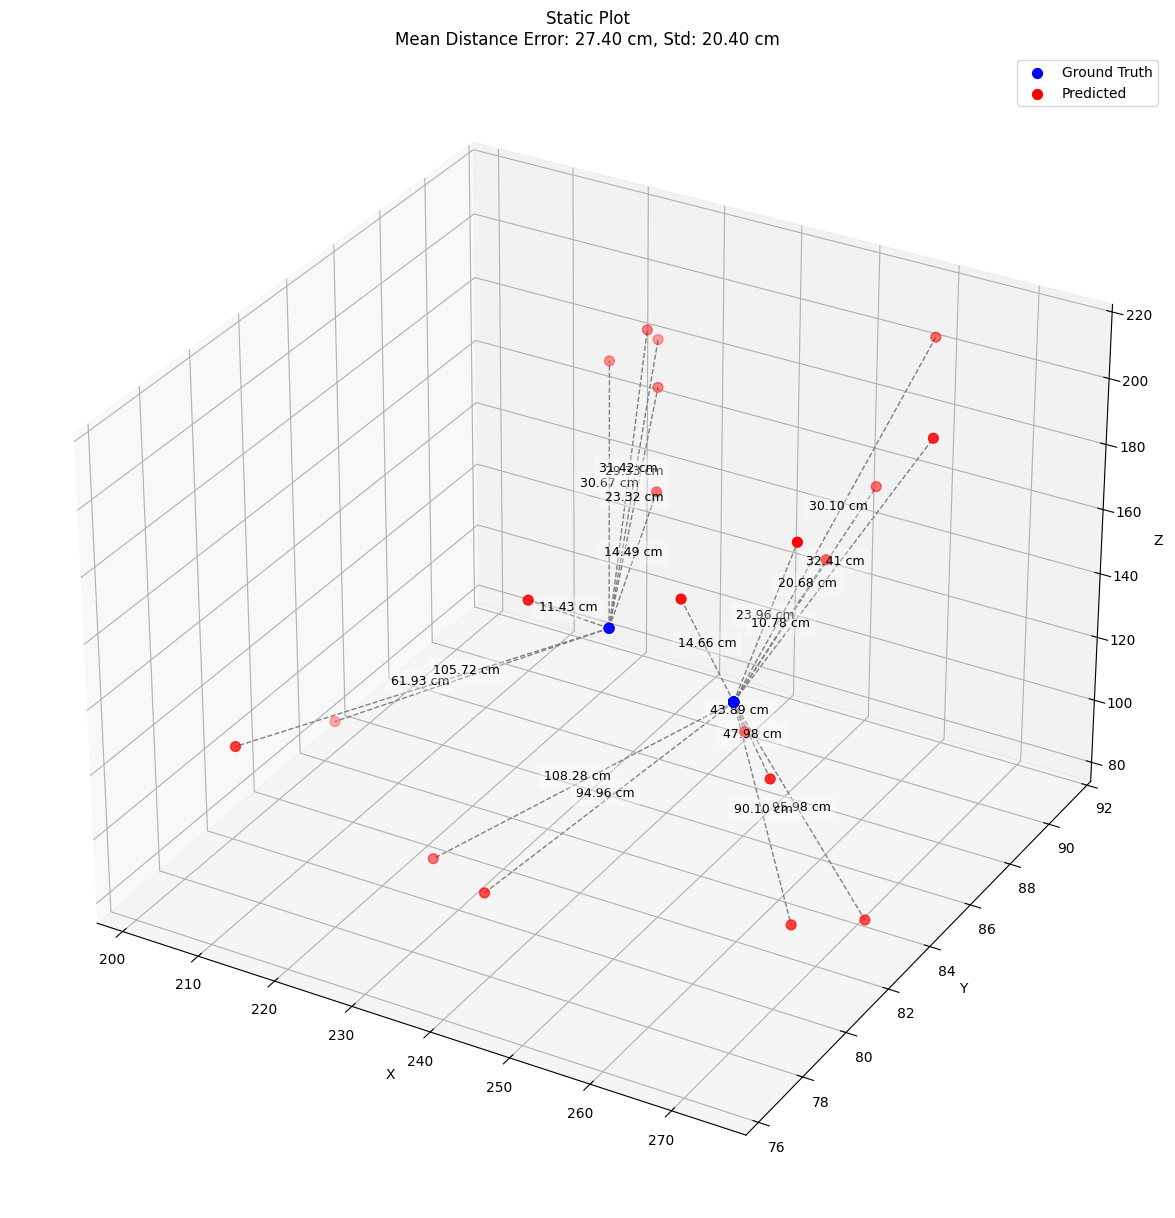

In [38]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_4 = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= LeakyReLUModel4, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [39]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 4.029215 | Loss test: 1.496939 | lr = 0.01
Epoch 10 | Loss train: 0.579584 | Loss test: 0.644893 | lr = 0.01
Epoch 20 | Loss train: 0.528936 | Loss test: 0.613542 | lr = 0.01
Epoch 30 | Loss train: 0.500644 | Loss test: 0.532473 | lr = 0.01
Epoch 40 | Loss train: 0.429424 | Loss test: 0.468826 | lr = 0.01
Epoch 50 | Loss train: 0.445630 | Loss test: 0.388171 | lr = 0.01
Epoch 60 | Loss train: 0.401344 | Loss test: 0.497188 | lr = 0.01
Epoch 70 | Loss train: 0.417901 | Loss test: 0.651388 | lr = 0.01
Epoch 80 | Loss train: 0.259205 | Loss test: 0.359574 | lr = 0.001
Epoch 90 | Loss train: 0.232894 | Loss test: 0.378252 | lr = 0.001
Epoch 100 | Loss train: 0.219133 | Loss test: 0.345658 | lr = 0.001
Epoch 110 | Loss train: 0.204181 | Loss test: 0.327332 | lr = 0.001
Epoch 120 | Loss train: 0.195869 | Loss test: 0.346067 | lr = 0.001
Epoch 130 | Loss train: 0.186358 | Loss test: 0.346936 | lr = 0.001
Epoch 140 | Loss train: 0.173653 | Loss test: 0.320519 | lr 

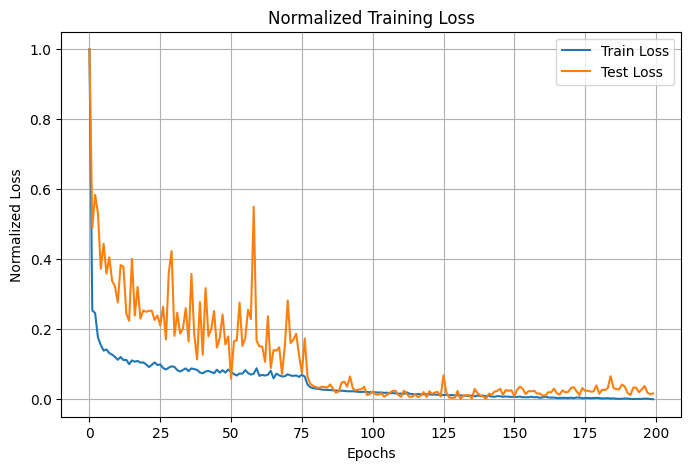

Fold 2
Epoch 0 | Loss train: 6.106947 | Loss test: 1.375032 | lr = 0.01
Epoch 10 | Loss train: 0.594621 | Loss test: 0.645825 | lr = 0.01
Epoch 20 | Loss train: 0.559074 | Loss test: 0.637638 | lr = 0.01
Epoch 30 | Loss train: 0.462730 | Loss test: 0.538021 | lr = 0.01
Epoch 40 | Loss train: 0.418949 | Loss test: 0.532074 | lr = 0.01
Epoch 50 | Loss train: 0.434268 | Loss test: 0.630842 | lr = 0.01
Epoch 60 | Loss train: 0.417742 | Loss test: 0.623851 | lr = 0.01
Epoch 70 | Loss train: 0.369653 | Loss test: 0.505235 | lr = 0.01
Epoch 80 | Loss train: 0.360998 | Loss test: 0.503796 | lr = 0.01
Epoch 90 | Loss train: 0.374309 | Loss test: 0.615182 | lr = 0.01
Epoch 100 | Loss train: 0.222132 | Loss test: 0.375898 | lr = 0.001
Epoch 110 | Loss train: 0.205647 | Loss test: 0.362334 | lr = 0.001
Epoch 120 | Loss train: 0.189805 | Loss test: 0.344391 | lr = 0.001
Epoch 130 | Loss train: 0.179304 | Loss test: 0.360793 | lr = 0.001
Epoch 140 | Loss train: 0.168957 | Loss test: 0.347974 | lr = 

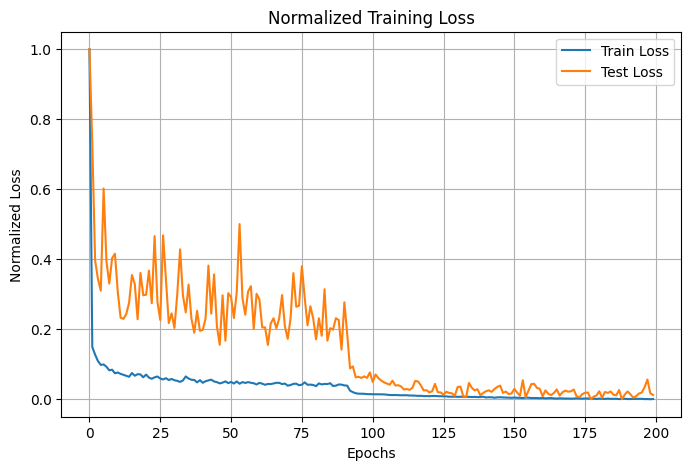

Fold 3
Epoch 0 | Loss train: 5.694727 | Loss test: 0.789404 | lr = 0.01
Epoch 10 | Loss train: 0.605930 | Loss test: 0.704300 | lr = 0.01
Epoch 20 | Loss train: 0.540122 | Loss test: 0.872876 | lr = 0.01
Epoch 30 | Loss train: 0.473849 | Loss test: 0.555491 | lr = 0.01
Epoch 40 | Loss train: 0.447901 | Loss test: 0.461142 | lr = 0.01
Epoch 50 | Loss train: 0.436069 | Loss test: 0.454570 | lr = 0.01
Epoch 60 | Loss train: 0.430645 | Loss test: 0.487787 | lr = 0.01
Epoch 70 | Loss train: 0.396337 | Loss test: 0.409978 | lr = 0.01
Epoch 80 | Loss train: 0.400310 | Loss test: 0.595836 | lr = 0.01
Epoch 90 | Loss train: 0.386053 | Loss test: 0.432305 | lr = 0.01
Epoch 100 | Loss train: 0.248511 | Loss test: 0.314014 | lr = 0.001
Epoch 110 | Loss train: 0.215892 | Loss test: 0.290204 | lr = 0.001
Epoch 120 | Loss train: 0.200889 | Loss test: 0.292606 | lr = 0.001
Epoch 130 | Loss train: 0.186873 | Loss test: 0.270985 | lr = 0.001
Epoch 140 | Loss train: 0.177374 | Loss test: 0.289669 | lr = 

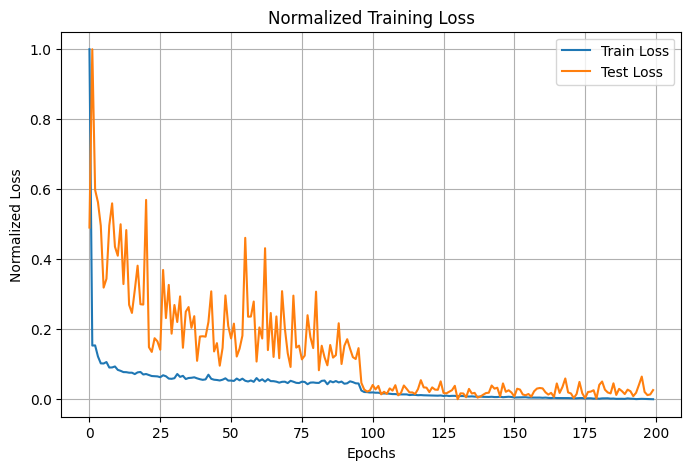

Fold 4
Epoch 0 | Loss train: 8.968163 | Loss test: 1.494154 | lr = 0.01
Epoch 10 | Loss train: 0.560109 | Loss test: 0.978461 | lr = 0.01
Epoch 20 | Loss train: 0.523068 | Loss test: 0.615347 | lr = 0.01
Epoch 30 | Loss train: 0.461991 | Loss test: 0.775026 | lr = 0.01
Epoch 40 | Loss train: 0.444804 | Loss test: 0.506469 | lr = 0.01
Epoch 50 | Loss train: 0.418698 | Loss test: 0.627859 | lr = 0.01
Epoch 60 | Loss train: 0.421722 | Loss test: 0.461922 | lr = 0.01
Epoch 70 | Loss train: 0.412018 | Loss test: 0.592024 | lr = 0.01
Epoch 80 | Loss train: 0.245236 | Loss test: 0.356516 | lr = 0.001
Epoch 90 | Loss train: 0.223426 | Loss test: 0.335855 | lr = 0.001
Epoch 100 | Loss train: 0.207375 | Loss test: 0.337597 | lr = 0.001
Epoch 110 | Loss train: 0.194648 | Loss test: 0.341269 | lr = 0.001
Epoch 120 | Loss train: 0.182508 | Loss test: 0.328900 | lr = 0.001
Epoch 130 | Loss train: 0.169378 | Loss test: 0.329525 | lr = 0.001
Epoch 140 | Loss train: 0.163572 | Loss test: 0.337723 | lr 

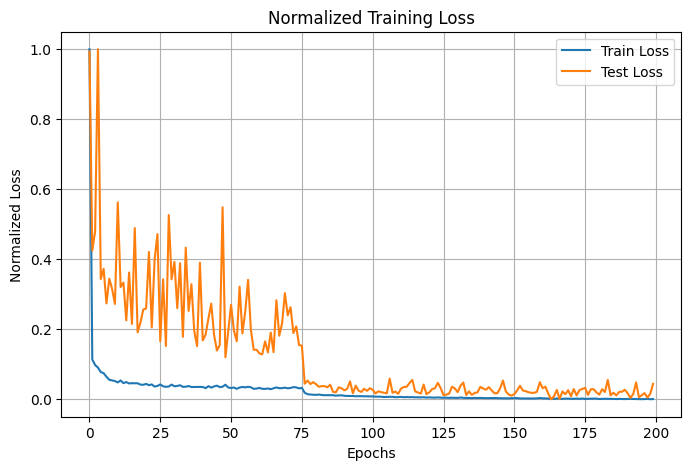

Fold 5
Epoch 0 | Loss train: 9.843959 | Loss test: 1.848036 | lr = 0.01
Epoch 10 | Loss train: 0.619629 | Loss test: 0.570674 | lr = 0.01
Epoch 20 | Loss train: 0.560034 | Loss test: 0.559749 | lr = 0.01
Epoch 30 | Loss train: 0.468306 | Loss test: 0.496386 | lr = 0.01
Epoch 40 | Loss train: 0.438072 | Loss test: 0.505256 | lr = 0.01
Epoch 50 | Loss train: 0.434607 | Loss test: 0.446615 | lr = 0.01
Epoch 60 | Loss train: 0.390292 | Loss test: 0.419852 | lr = 0.01
Epoch 70 | Loss train: 0.413584 | Loss test: 0.504599 | lr = 0.01
Epoch 80 | Loss train: 0.236717 | Loss test: 0.329205 | lr = 0.001
Epoch 90 | Loss train: 0.212715 | Loss test: 0.324512 | lr = 0.001
Epoch 100 | Loss train: 0.198511 | Loss test: 0.346726 | lr = 0.001
Epoch 110 | Loss train: 0.185817 | Loss test: 0.298674 | lr = 0.001
Epoch 120 | Loss train: 0.172506 | Loss test: 0.315066 | lr = 0.001
Epoch 130 | Loss train: 0.166954 | Loss test: 0.301091 | lr = 0.001
Epoch 140 | Loss train: 0.158937 | Loss test: 0.325647 | lr 

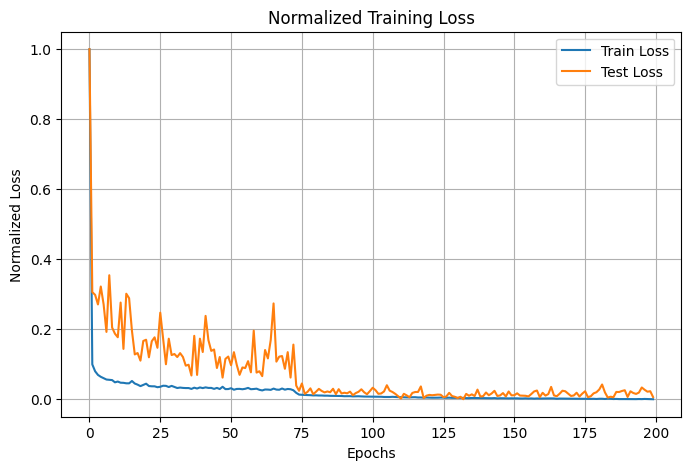

Cross-Validation finished with mean error across 5 subsets = 0.3030562972241924, evaluating final model...
Epoch 0 | Loss train: 4.410634 | lr = 0.01
Epoch 10 | Loss train: 0.543755 | lr = 0.01
Epoch 20 | Loss train: 0.497363 | lr = 0.01
Epoch 30 | Loss train: 0.462684 | lr = 0.01
Epoch 40 | Loss train: 0.416629 | lr = 0.01
Epoch 50 | Loss train: 0.276272 | lr = 0.001
Epoch 60 | Loss train: 0.240538 | lr = 0.001
Epoch 70 | Loss train: 0.221441 | lr = 0.001
Epoch 80 | Loss train: 0.209617 | lr = 0.001
Epoch 90 | Loss train: 0.201692 | lr = 0.001
Epoch 100 | Loss train: 0.193340 | lr = 0.001
Epoch 110 | Loss train: 0.187000 | lr = 0.001
Epoch 120 | Loss train: 0.184959 | lr = 0.001
Epoch 130 | Loss train: 0.175256 | lr = 0.001
Epoch 140 | Loss train: 0.167747 | lr = 0.001
Epoch 150 | Loss train: 0.165111 | lr = 0.001
Epoch 160 | Loss train: 0.163613 | lr = 0.001
Epoch 170 | Loss train: 0.156284 | lr = 0.001
Epoch 180 | Loss train: 0.150985 | lr = 0.001
Epoch 190 | Loss train: 0.150231 | 

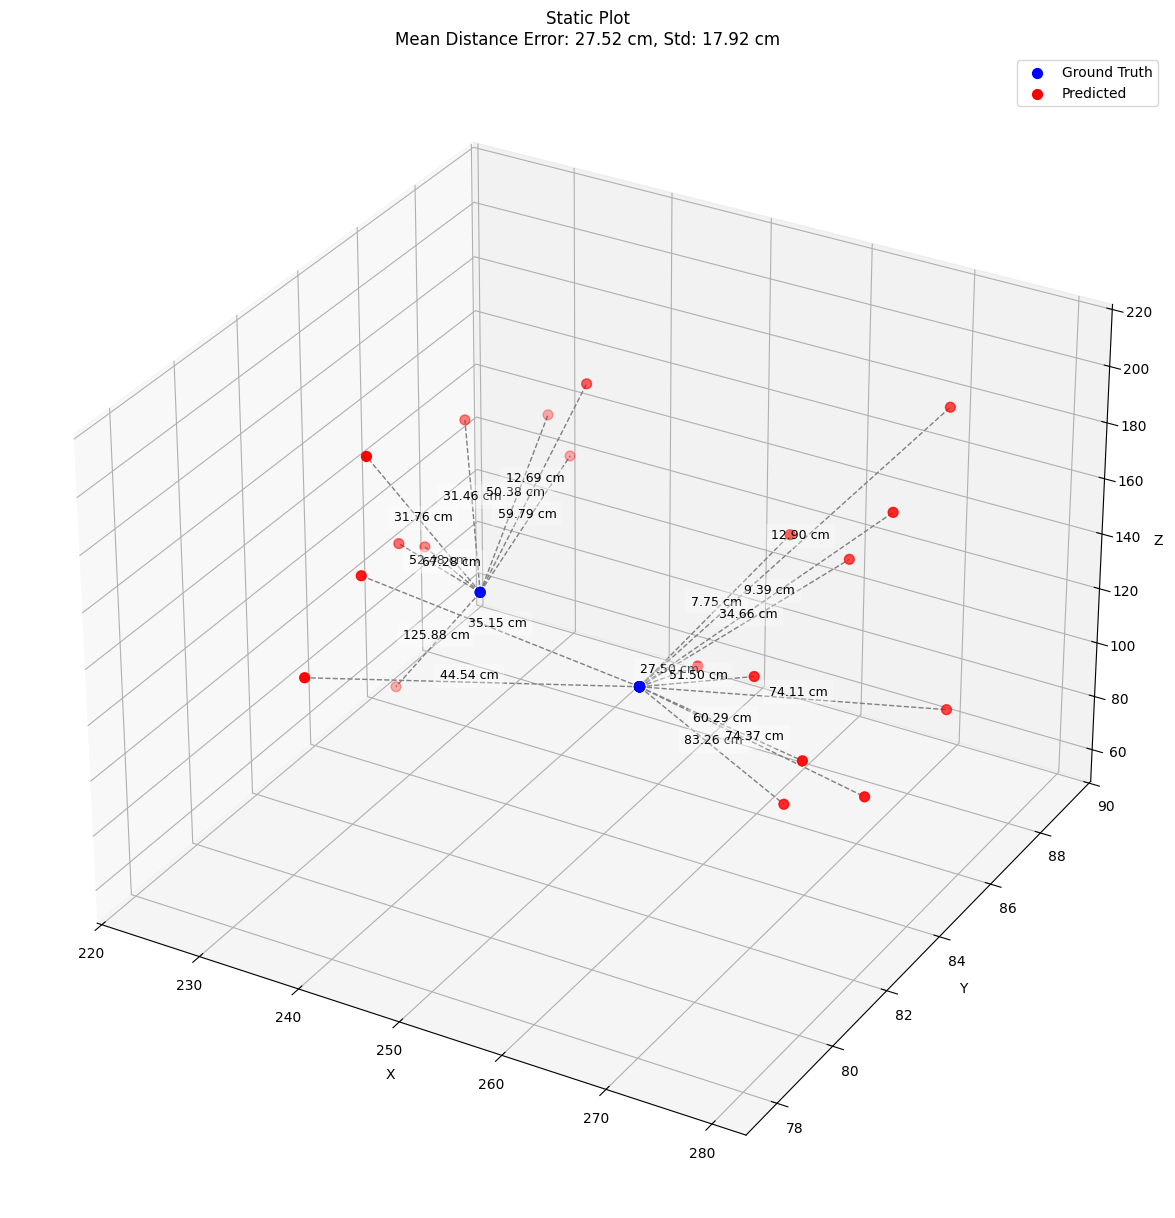

In [40]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2 = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= LeakyReLUModel2, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

#### -1 Layer rmsprop

In [41]:
class LeakyReLUModel2_RMS(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2_RMS, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 570.790126 | Loss test: 2.752533 | lr = 0.01
Epoch 10 | Loss train: 1.398218 | Loss test: 1.096355 | lr = 0.01
Epoch 20 | Loss train: 1.373011 | Loss test: 1.156278 | lr = 0.01
Epoch 30 | Loss train: 1.182481 | Loss test: 1.511487 | lr = 0.01
Epoch 40 | Loss train: 1.170813 | Loss test: 3.056243 | lr = 0.01
Epoch 50 | Loss train: 1.147543 | Loss test: 2.754282 | lr = 0.01
Epoch 60 | Loss train: 0.355374 | Loss test: 0.450072 | lr = 0.001
Epoch 70 | Loss train: 0.310845 | Loss test: 0.377658 | lr = 0.001
Epoch 80 | Loss train: 0.282646 | Loss test: 0.375289 | lr = 0.001
Epoch 90 | Loss train: 0.266386 | Loss test: 0.335858 | lr = 0.001
Epoch 100 | Loss train: 0.257183 | Loss test: 0.415108 | lr = 0.001
Epoch 110 | Loss train: 0.240748 | Loss test: 0.330040 | lr = 0.001
Epoch 120 | Loss train: 0.227369 | Loss test: 0.331878 | lr = 0.001
Epoch 130 | Loss train: 0.227140 | Loss test: 0.333740 | lr = 0.001
Epoch 140 | Loss train: 0.219367 | Loss test: 0.331902 |

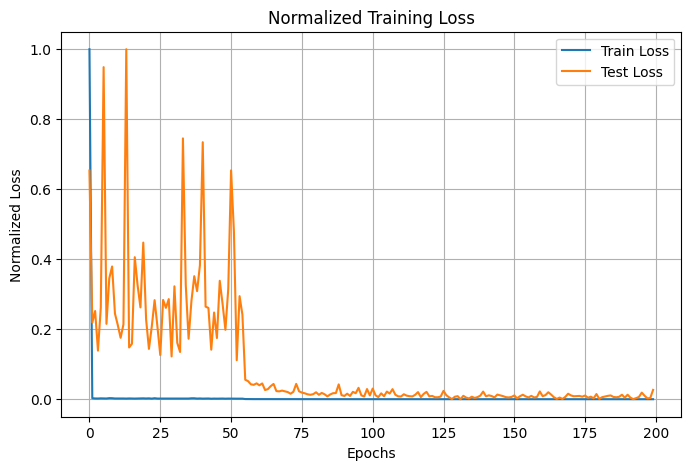

Fold 2
Epoch 0 | Loss train: 1762.312429 | Loss test: 27.937732 | lr = 0.01
Epoch 10 | Loss train: 1.315979 | Loss test: 1.304025 | lr = 0.01
Epoch 20 | Loss train: 1.383984 | Loss test: 2.067760 | lr = 0.01
Epoch 30 | Loss train: 1.362164 | Loss test: 0.923675 | lr = 0.01
Epoch 40 | Loss train: 1.335303 | Loss test: 0.911302 | lr = 0.01
Epoch 50 | Loss train: 0.368307 | Loss test: 0.487667 | lr = 0.001
Epoch 60 | Loss train: 0.309769 | Loss test: 0.470283 | lr = 0.001
Epoch 70 | Loss train: 0.281750 | Loss test: 0.415749 | lr = 0.001
Epoch 80 | Loss train: 0.267693 | Loss test: 0.413079 | lr = 0.001
Epoch 90 | Loss train: 0.251171 | Loss test: 0.420476 | lr = 0.001
Epoch 100 | Loss train: 0.236949 | Loss test: 0.405021 | lr = 0.001
Epoch 110 | Loss train: 0.234327 | Loss test: 0.425200 | lr = 0.001
Epoch 120 | Loss train: 0.217249 | Loss test: 0.404279 | lr = 0.001
Epoch 130 | Loss train: 0.213274 | Loss test: 0.427223 | lr = 0.001
Epoch 140 | Loss train: 0.211095 | Loss test: 0.41611

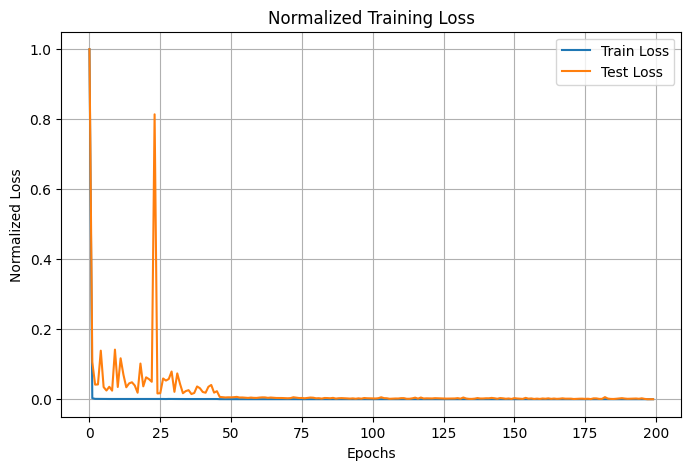

Fold 3
Epoch 0 | Loss train: 1417.331369 | Loss test: 11.138884 | lr = 0.01
Epoch 10 | Loss train: 1.328798 | Loss test: 2.669623 | lr = 0.01
Epoch 20 | Loss train: 2.346715 | Loss test: 2.510175 | lr = 0.01
Epoch 30 | Loss train: 1.304842 | Loss test: 1.624084 | lr = 0.01
Epoch 40 | Loss train: 1.332795 | Loss test: 2.035961 | lr = 0.001
Epoch 50 | Loss train: 0.360835 | Loss test: 0.394162 | lr = 0.001
Epoch 60 | Loss train: 0.314643 | Loss test: 0.392599 | lr = 0.001
Epoch 70 | Loss train: 0.285711 | Loss test: 0.412522 | lr = 0.001
Epoch 80 | Loss train: 0.276160 | Loss test: 0.439388 | lr = 0.001
Epoch 90 | Loss train: 0.250953 | Loss test: 0.424992 | lr = 0.001
Epoch 100 | Loss train: 0.246014 | Loss test: 0.387078 | lr = 0.001
Epoch 110 | Loss train: 0.239051 | Loss test: 0.427232 | lr = 0.001
Epoch 120 | Loss train: 0.233278 | Loss test: 0.382205 | lr = 0.001
Epoch 130 | Loss train: 0.225145 | Loss test: 0.443545 | lr = 0.001
Epoch 140 | Loss train: 0.223706 | Loss test: 0.3554

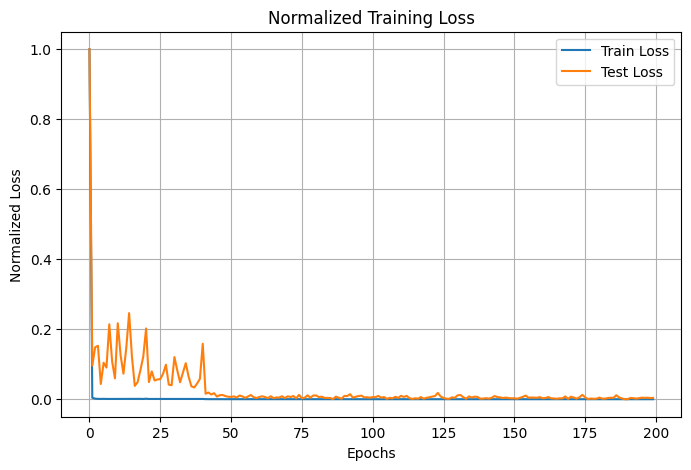

Fold 4
Epoch 0 | Loss train: 2381.601071 | Loss test: 31.824491 | lr = 0.01
Epoch 10 | Loss train: 1.373320 | Loss test: 1.170230 | lr = 0.01
Epoch 20 | Loss train: 1.208466 | Loss test: 2.988783 | lr = 0.01
Epoch 30 | Loss train: 2.027971 | Loss test: 2.757957 | lr = 0.01
Epoch 40 | Loss train: 1.280145 | Loss test: 1.099662 | lr = 0.01
Epoch 50 | Loss train: 1.195103 | Loss test: 3.721328 | lr = 0.01
Epoch 60 | Loss train: 0.338305 | Loss test: 0.480599 | lr = 0.001
Epoch 70 | Loss train: 0.293853 | Loss test: 0.434948 | lr = 0.001
Epoch 80 | Loss train: 0.275919 | Loss test: 0.400197 | lr = 0.001
Epoch 90 | Loss train: 0.251467 | Loss test: 0.365169 | lr = 0.001
Epoch 100 | Loss train: 0.237734 | Loss test: 0.445708 | lr = 0.001
Epoch 110 | Loss train: 0.229600 | Loss test: 0.375703 | lr = 0.001
Epoch 120 | Loss train: 0.224689 | Loss test: 0.408219 | lr = 0.001
Epoch 130 | Loss train: 0.167470 | Loss test: 0.341743 | lr = 0.0001
Epoch 140 | Loss train: 0.166229 | Loss test: 0.34226

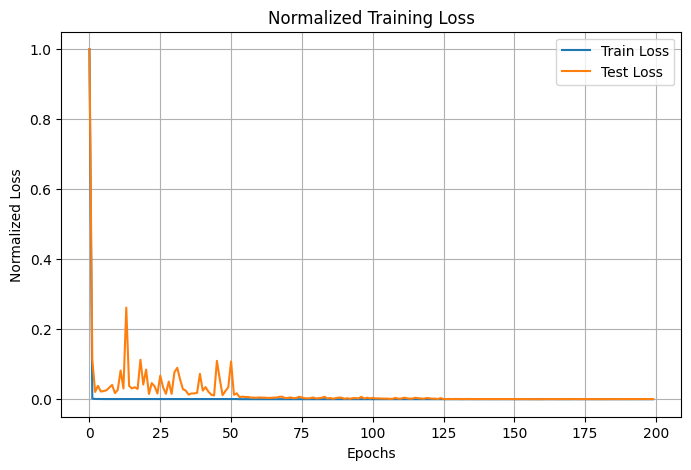

Fold 5
Epoch 0 | Loss train: 1483.124493 | Loss test: 1.686003 | lr = 0.01
Epoch 10 | Loss train: 1.274747 | Loss test: 1.182846 | lr = 0.01
Epoch 20 | Loss train: 1.265031 | Loss test: 0.744375 | lr = 0.01
Epoch 30 | Loss train: 1.360967 | Loss test: 1.002425 | lr = 0.01
Epoch 40 | Loss train: 0.429847 | Loss test: 0.452344 | lr = 0.001
Epoch 50 | Loss train: 0.333223 | Loss test: 0.472302 | lr = 0.001
Epoch 60 | Loss train: 0.302760 | Loss test: 0.386786 | lr = 0.001
Epoch 70 | Loss train: 0.277285 | Loss test: 0.367279 | lr = 0.001
Epoch 80 | Loss train: 0.259346 | Loss test: 0.350965 | lr = 0.001
Epoch 90 | Loss train: 0.253834 | Loss test: 0.347207 | lr = 0.001
Epoch 100 | Loss train: 0.239445 | Loss test: 0.357771 | lr = 0.001
Epoch 110 | Loss train: 0.231577 | Loss test: 0.363799 | lr = 0.001
Epoch 120 | Loss train: 0.222368 | Loss test: 0.358848 | lr = 0.001
Epoch 130 | Loss train: 0.224855 | Loss test: 0.380970 | lr = 0.001
Epoch 140 | Loss train: 0.215018 | Loss test: 0.40149

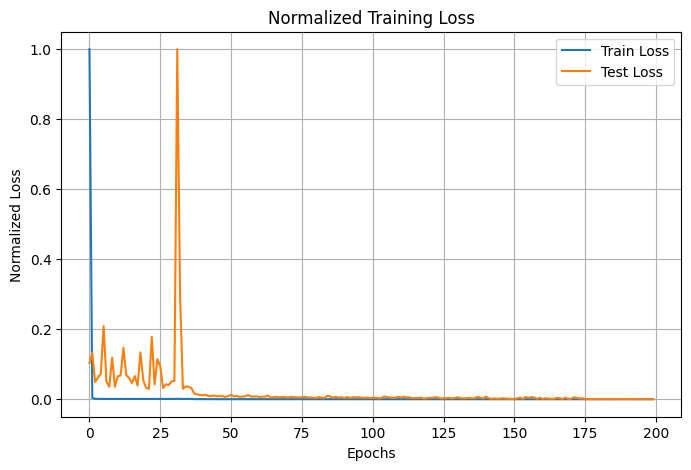

Cross-Validation finished with mean error across 5 subsets = 0.31785805084166074, evaluating final model...
Epoch 0 | Loss train: 935.221558 | lr = 0.01
Epoch 10 | Loss train: 1.637331 | lr = 0.01
Epoch 20 | Loss train: 0.474497 | lr = 0.001
Epoch 30 | Loss train: 0.355562 | lr = 0.001
Epoch 40 | Loss train: 0.308873 | lr = 0.001
Epoch 50 | Loss train: 0.288692 | lr = 0.001
Epoch 60 | Loss train: 0.274467 | lr = 0.001
Epoch 70 | Loss train: 0.263532 | lr = 0.001
Epoch 80 | Loss train: 0.253902 | lr = 0.001
Epoch 90 | Loss train: 0.241657 | lr = 0.001
Epoch 100 | Loss train: 0.234289 | lr = 0.001
Epoch 110 | Loss train: 0.225431 | lr = 0.001
Epoch 120 | Loss train: 0.220201 | lr = 0.001
Epoch 130 | Loss train: 0.216004 | lr = 0.001
Epoch 140 | Loss train: 0.208553 | lr = 0.001
Epoch 150 | Loss train: 0.206964 | lr = 0.001
Epoch 160 | Loss train: 0.204415 | lr = 0.001
Epoch 170 | Loss train: 0.201039 | lr = 0.001
Epoch 180 | Loss train: 0.197922 | lr = 0.001
Epoch 190 | Loss train: 0.151

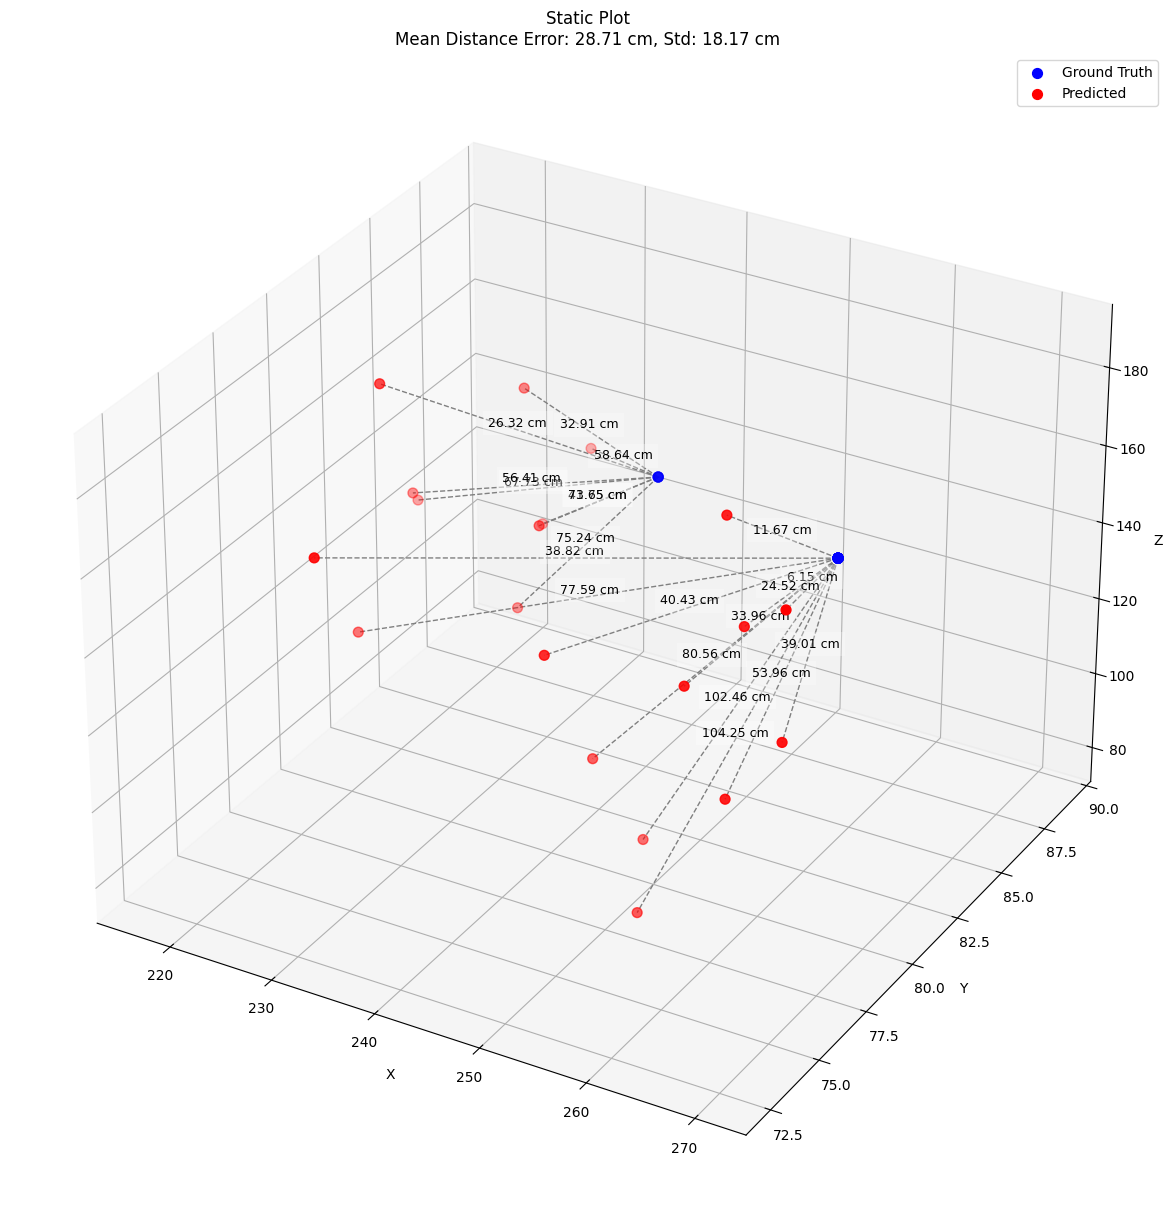

In [42]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2_rms = cross_validation_dat(Main_Data= main_data, Holdout_Data= holdout_data, n_splits= num_splits, model= LeakyReLUModel2_RMS, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = True)

### Αρχιτεκτονική 4

#### Dropout LeakyReLU

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [36]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.796038 | Loss test: 0.901601 | lr = 0.01
Epoch 10 | Loss train: 0.784770 | Loss test: 0.741374 | lr = 0.01
Epoch 20 | Loss train: 0.733560 | Loss test: 0.629369 | lr = 0.01
Epoch 30 | Loss train: 0.620138 | Loss test: 0.573457 | lr = 0.001
Epoch 40 | Loss train: 0.542830 | Loss test: 0.507709 | lr = 0.001
Epoch 50 | Loss train: 0.487745 | Loss test: 0.419675 | lr = 0.001
Epoch 60 | Loss train: 0.442852 | Loss test: 0.422528 | lr = 0.001
Epoch 70 | Loss train: 0.420136 | Loss test: 0.365702 | lr = 0.001
Epoch 80 | Loss train: 0.390805 | Loss test: 0.338982 | lr = 0.001
Epoch 90 | Loss train: 0.381346 | Loss test: 0.338468 | lr = 0.001
Epoch 100 | Loss train: 0.375185 | Loss test: 0.352068 | lr = 0.001
Epoch 110 | Loss train: 0.364415 | Loss test: 0.321625 | lr = 0.001
Epoch 120 | Loss train: 0.349516 | Loss test: 0.309080 | lr = 0.001
Epoch 130 | Loss train: 0.346623 | Loss test: 0.305844 | lr = 0.001
Epoch 140 | Loss train: 0.313107 | Loss test: 0.278772 

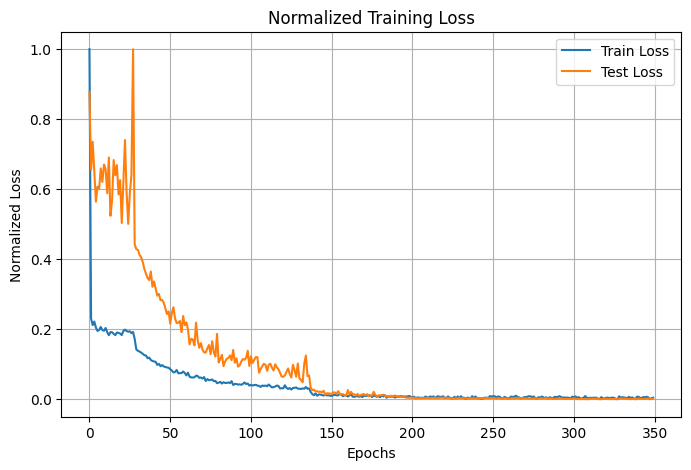

Fold 2
Epoch 0 | Loss train: 1.767898 | Loss test: 1.218697 | lr = 0.01
Epoch 10 | Loss train: 0.764129 | Loss test: 0.740890 | lr = 0.01
Epoch 20 | Loss train: 0.722313 | Loss test: 0.712496 | lr = 0.01
Epoch 30 | Loss train: 0.605328 | Loss test: 0.562808 | lr = 0.001
Epoch 40 | Loss train: 0.507398 | Loss test: 0.512454 | lr = 0.001
Epoch 50 | Loss train: 0.454034 | Loss test: 0.446386 | lr = 0.001
Epoch 60 | Loss train: 0.426649 | Loss test: 0.403696 | lr = 0.001
Epoch 70 | Loss train: 0.409161 | Loss test: 0.386176 | lr = 0.001
Epoch 80 | Loss train: 0.387495 | Loss test: 0.365919 | lr = 0.001
Epoch 90 | Loss train: 0.370794 | Loss test: 0.368965 | lr = 0.001
Epoch 100 | Loss train: 0.358216 | Loss test: 0.370694 | lr = 0.001
Epoch 110 | Loss train: 0.323706 | Loss test: 0.304641 | lr = 0.0001
Epoch 120 | Loss train: 0.315088 | Loss test: 0.300807 | lr = 0.0001
Epoch 130 | Loss train: 0.318117 | Loss test: 0.291806 | lr = 0.0001
Epoch 140 | Loss train: 0.303332 | Loss test: 0.2902

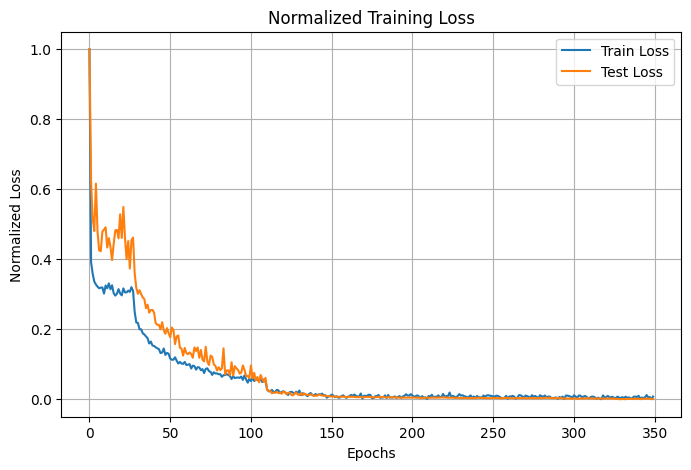

Fold 3
Epoch 0 | Loss train: 1.805858 | Loss test: 0.862667 | lr = 0.01
Epoch 10 | Loss train: 0.741704 | Loss test: 0.674254 | lr = 0.01
Epoch 20 | Loss train: 0.718991 | Loss test: 0.625782 | lr = 0.01
Epoch 30 | Loss train: 0.707097 | Loss test: 0.667435 | lr = 0.01
Epoch 40 | Loss train: 0.740433 | Loss test: 0.747108 | lr = 0.01
Epoch 50 | Loss train: 0.561655 | Loss test: 0.529558 | lr = 0.001
Epoch 60 | Loss train: 0.515950 | Loss test: 0.516263 | lr = 0.001
Epoch 70 | Loss train: 0.477502 | Loss test: 0.416642 | lr = 0.001
Epoch 80 | Loss train: 0.437063 | Loss test: 0.404934 | lr = 0.001
Epoch 90 | Loss train: 0.439113 | Loss test: 0.390586 | lr = 0.001
Epoch 100 | Loss train: 0.404695 | Loss test: 0.380897 | lr = 0.001
Epoch 110 | Loss train: 0.390645 | Loss test: 0.334245 | lr = 0.001
Epoch 120 | Loss train: 0.395017 | Loss test: 0.331851 | lr = 0.001
Epoch 130 | Loss train: 0.386151 | Loss test: 0.344552 | lr = 0.001
Epoch 140 | Loss train: 0.369089 | Loss test: 0.314526 | 

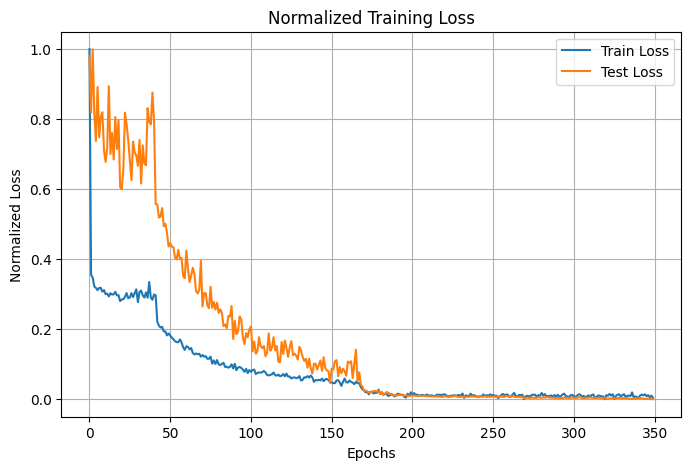

Fold 4
Epoch 0 | Loss train: 1.936482 | Loss test: 0.925225 | lr = 0.01
Epoch 10 | Loss train: 0.759543 | Loss test: 0.700457 | lr = 0.01
Epoch 20 | Loss train: 0.745082 | Loss test: 0.865090 | lr = 0.01
Epoch 30 | Loss train: 0.738248 | Loss test: 0.791669 | lr = 0.001
Epoch 40 | Loss train: 0.535299 | Loss test: 0.514301 | lr = 0.001
Epoch 50 | Loss train: 0.489274 | Loss test: 0.466572 | lr = 0.001
Epoch 60 | Loss train: 0.438808 | Loss test: 0.414159 | lr = 0.001
Epoch 70 | Loss train: 0.425186 | Loss test: 0.412721 | lr = 0.001
Epoch 80 | Loss train: 0.411921 | Loss test: 0.365524 | lr = 0.001
Epoch 90 | Loss train: 0.409365 | Loss test: 0.416526 | lr = 0.001
Epoch 100 | Loss train: 0.405013 | Loss test: 0.388298 | lr = 0.001
Epoch 110 | Loss train: 0.376366 | Loss test: 0.351629 | lr = 0.001
Epoch 120 | Loss train: 0.383475 | Loss test: 0.337048 | lr = 0.001
Epoch 130 | Loss train: 0.366626 | Loss test: 0.336744 | lr = 0.001
Epoch 140 | Loss train: 0.360076 | Loss test: 0.340649 

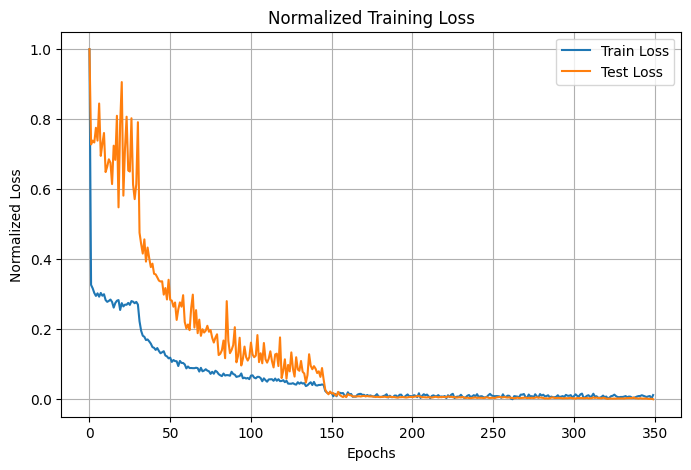

Fold 5
Epoch 0 | Loss train: 2.896465 | Loss test: 0.761272 | lr = 0.01
Epoch 10 | Loss train: 0.754984 | Loss test: 0.692867 | lr = 0.01
Epoch 20 | Loss train: 0.746163 | Loss test: 0.608530 | lr = 0.01
Epoch 30 | Loss train: 0.767236 | Loss test: 0.644643 | lr = 0.001
Epoch 40 | Loss train: 0.548040 | Loss test: 0.464560 | lr = 0.001
Epoch 50 | Loss train: 0.483346 | Loss test: 0.415672 | lr = 0.001
Epoch 60 | Loss train: 0.449520 | Loss test: 0.374725 | lr = 0.001
Epoch 70 | Loss train: 0.421234 | Loss test: 0.358192 | lr = 0.001
Epoch 80 | Loss train: 0.396224 | Loss test: 0.337938 | lr = 0.001
Epoch 90 | Loss train: 0.386011 | Loss test: 0.321761 | lr = 0.001
Epoch 100 | Loss train: 0.378840 | Loss test: 0.364218 | lr = 0.001
Epoch 110 | Loss train: 0.376206 | Loss test: 0.310443 | lr = 0.001
Epoch 120 | Loss train: 0.350758 | Loss test: 0.304404 | lr = 0.001
Epoch 130 | Loss train: 0.359994 | Loss test: 0.294128 | lr = 0.001
Epoch 140 | Loss train: 0.330264 | Loss test: 0.312060 

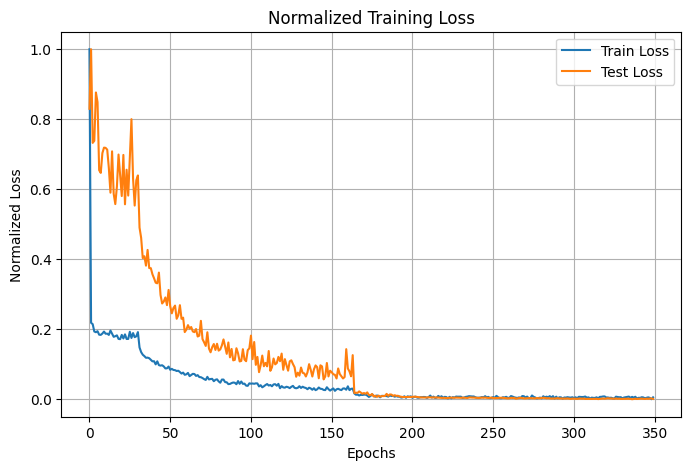

Cross-Validation finished with mean error across 5 subsets = 0.2662814404567083, evaluating final model...
Epoch 0 | Loss train: 1.643079 | lr = 0.01
Epoch 10 | Loss train: 0.780793 | lr = 0.01
Epoch 20 | Loss train: 0.733766 | lr = 0.01
Epoch 30 | Loss train: 0.742763 | lr = 0.01
Epoch 40 | Loss train: 0.753662 | lr = 0.01
Epoch 50 | Loss train: 0.572478 | lr = 0.001
Epoch 60 | Loss train: 0.516125 | lr = 0.001
Epoch 70 | Loss train: 0.463012 | lr = 0.001
Epoch 80 | Loss train: 0.444274 | lr = 0.001
Epoch 90 | Loss train: 0.424934 | lr = 0.001
Epoch 100 | Loss train: 0.388200 | lr = 0.001
Epoch 110 | Loss train: 0.390073 | lr = 0.001
Epoch 120 | Loss train: 0.370347 | lr = 0.001
Epoch 130 | Loss train: 0.374168 | lr = 0.001
Epoch 140 | Loss train: 0.374891 | lr = 0.001
Epoch 150 | Loss train: 0.319420 | lr = 0.0001
Epoch 160 | Loss train: 0.320515 | lr = 0.0001
Epoch 170 | Loss train: 0.312930 | lr = 1e-05
Epoch 180 | Loss train: 0.314304 | lr = 1e-05
Epoch 190 | Loss train: 0.305664 

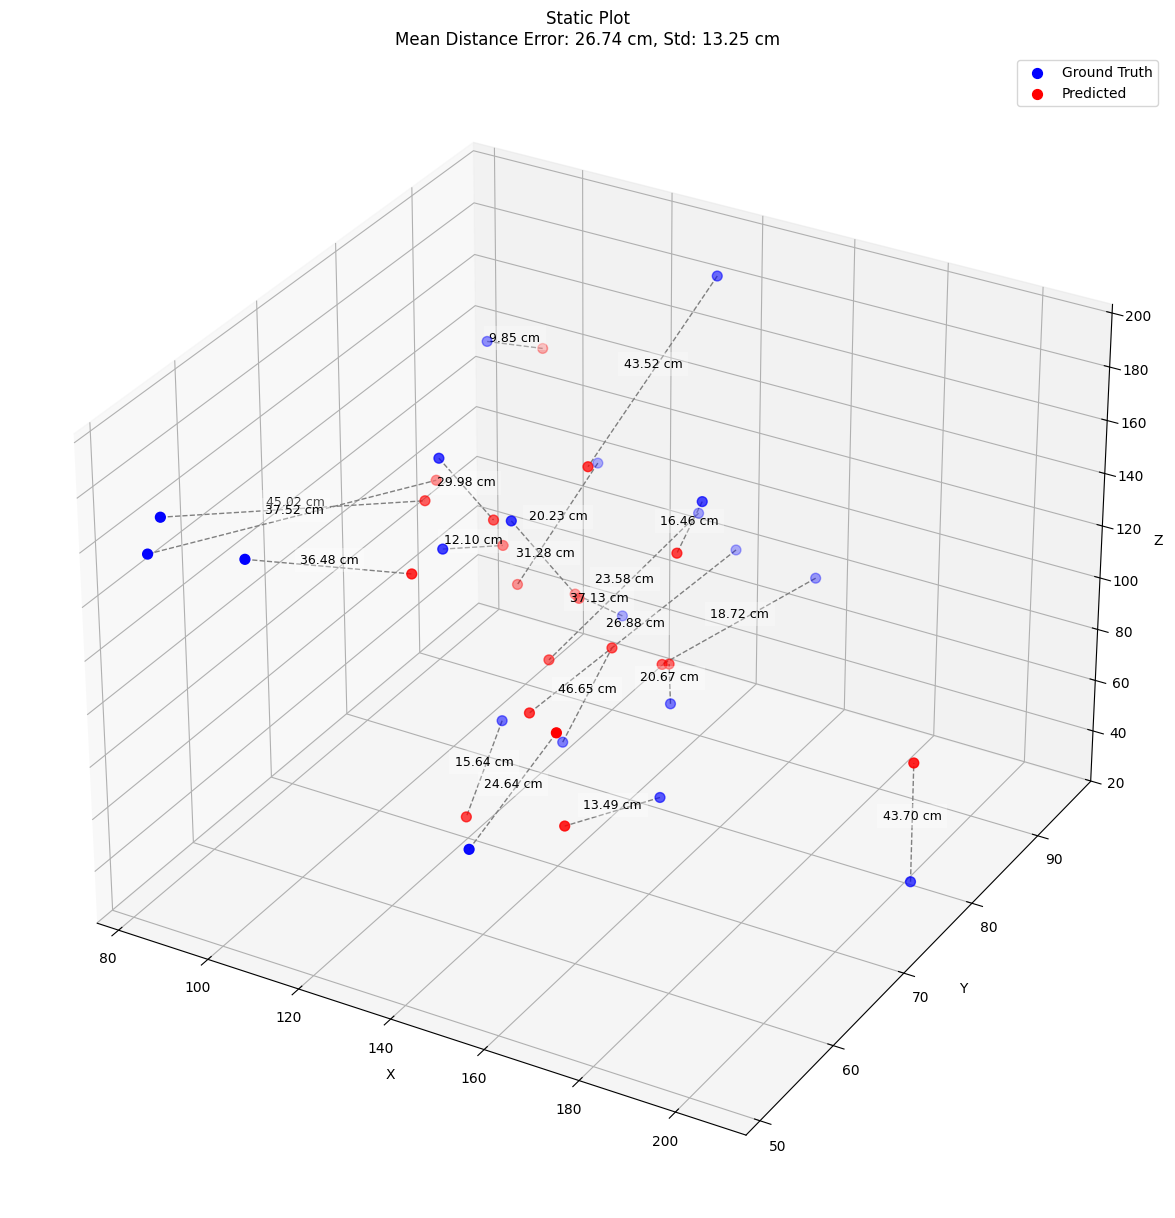

In [37]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2, 'weight_decay': 1e-4}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

dropout_model = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= LeakyReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [38]:
dropout_model

{'model_name': 'LeakyReLUModelDropout',
 'mean_distance_error_cm': 26.739221572875977,
 'std': 13.249455451965332}

#### Dropout ReLU

In [39]:
class ReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(ReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 9.211943 | Loss test: 0.849559 | lr = 0.01
Epoch 10 | Loss train: 0.807484 | Loss test: 0.749249 | lr = 0.01
Epoch 20 | Loss train: 0.807120 | Loss test: 0.739501 | lr = 0.01
Epoch 30 | Loss train: 0.765821 | Loss test: 0.715985 | lr = 0.001
Epoch 40 | Loss train: 0.775113 | Loss test: 0.715528 | lr = 0.0001
Epoch 50 | Loss train: 0.765816 | Loss test: 0.714310 | lr = 0.0001
Epoch 60 | Loss train: 0.774872 | Loss test: 0.713908 | lr = 0.0001
Epoch 70 | Loss train: 0.764606 | Loss test: 0.714229 | lr = 1e-05
Epoch 80 | Loss train: 0.755650 | Loss test: 0.714094 | lr = 1e-05
Epoch 90 | Loss train: 0.756597 | Loss test: 0.714107 | lr = 1e-05
Epoch 100 | Loss train: 0.763819 | Loss test: 0.714122 | lr = 1e-05
Epoch 110 | Loss train: 0.769684 | Loss test: 0.713943 | lr = 1e-05
Epoch 120 | Loss train: 0.749732 | Loss test: 0.713767 | lr = 1e-05
Early stopping at epoch 129
Loaded best model from temp_model.pth


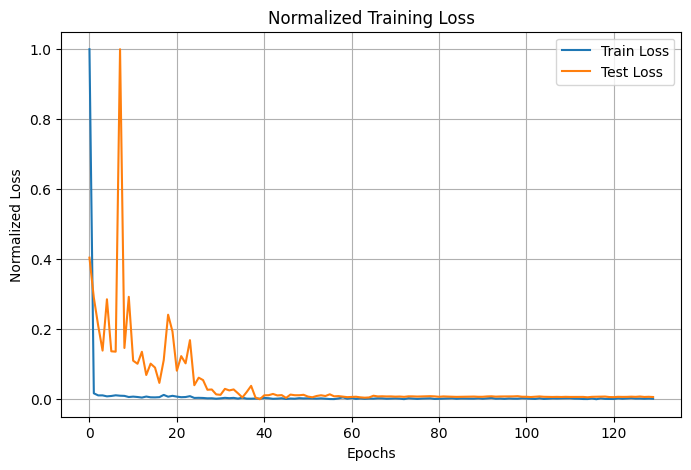

Fold 2
Epoch 0 | Loss train: 7.949273 | Loss test: 0.770487 | lr = 0.01
Epoch 10 | Loss train: 0.659242 | Loss test: 0.608974 | lr = 0.01
Epoch 20 | Loss train: 0.626497 | Loss test: 0.648657 | lr = 0.01
Epoch 30 | Loss train: 0.619968 | Loss test: 0.591085 | lr = 0.01
Epoch 40 | Loss train: 0.607613 | Loss test: 0.619693 | lr = 0.01
Epoch 50 | Loss train: 0.559192 | Loss test: 0.554942 | lr = 0.001
Epoch 60 | Loss train: 0.564259 | Loss test: 0.540463 | lr = 0.001
Epoch 70 | Loss train: 0.549476 | Loss test: 0.540819 | lr = 0.001
Epoch 80 | Loss train: 0.554010 | Loss test: 0.533880 | lr = 0.0001
Epoch 90 | Loss train: 0.560051 | Loss test: 0.534544 | lr = 0.0001
Epoch 100 | Loss train: 0.551970 | Loss test: 0.533642 | lr = 1e-05
Epoch 110 | Loss train: 0.555605 | Loss test: 0.533375 | lr = 1e-05
Epoch 120 | Loss train: 0.547334 | Loss test: 0.533465 | lr = 1e-05
Epoch 130 | Loss train: 0.550314 | Loss test: 0.533444 | lr = 1e-05
Epoch 140 | Loss train: 0.537377 | Loss test: 0.533159 

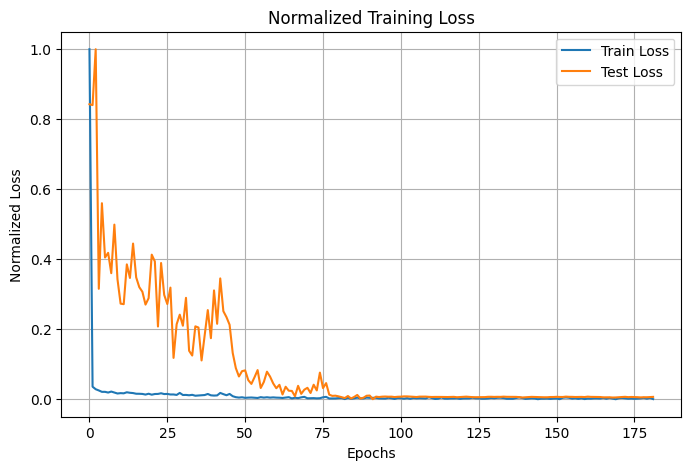

Fold 3
Epoch 0 | Loss train: 4.334519 | Loss test: 0.810899 | lr = 0.01
Epoch 10 | Loss train: 0.624297 | Loss test: 0.615085 | lr = 0.01
Epoch 20 | Loss train: 0.624006 | Loss test: 0.562672 | lr = 0.01
Epoch 30 | Loss train: 0.574940 | Loss test: 0.530425 | lr = 0.01
Epoch 40 | Loss train: 0.573770 | Loss test: 0.511066 | lr = 0.01
Epoch 50 | Loss train: 0.506805 | Loss test: 0.483811 | lr = 0.01
Epoch 60 | Loss train: 0.489167 | Loss test: 0.422619 | lr = 0.01
Epoch 70 | Loss train: 0.462740 | Loss test: 0.400155 | lr = 0.01
Epoch 80 | Loss train: 0.474407 | Loss test: 0.396283 | lr = 0.01
Epoch 90 | Loss train: 0.398724 | Loss test: 0.336401 | lr = 0.001
Epoch 100 | Loss train: 0.381834 | Loss test: 0.321062 | lr = 0.001
Epoch 110 | Loss train: 0.365994 | Loss test: 0.321623 | lr = 0.001
Epoch 120 | Loss train: 0.366522 | Loss test: 0.308896 | lr = 0.0001
Epoch 130 | Loss train: 0.331972 | Loss test: 0.310718 | lr = 0.0001
Epoch 140 | Loss train: 0.344743 | Loss test: 0.312217 | lr

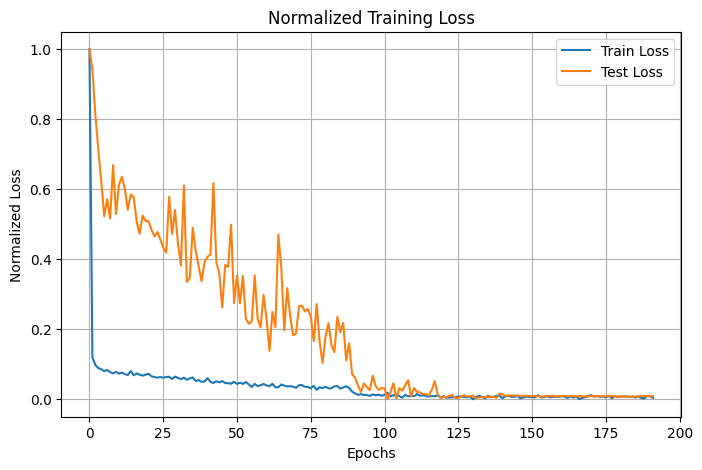

Fold 4
Epoch 0 | Loss train: 6.130855 | Loss test: 0.998109 | lr = 0.01
Epoch 10 | Loss train: 0.793045 | Loss test: 0.786515 | lr = 0.01
Epoch 20 | Loss train: 0.802093 | Loss test: 0.772351 | lr = 0.01
Epoch 30 | Loss train: 0.798038 | Loss test: 0.748152 | lr = 0.01
Epoch 40 | Loss train: 0.759114 | Loss test: 0.717482 | lr = 0.001
Epoch 50 | Loss train: 0.744285 | Loss test: 0.715150 | lr = 0.001
Epoch 60 | Loss train: 0.636973 | Loss test: 0.604310 | lr = 0.001
Epoch 70 | Loss train: 0.569071 | Loss test: 0.570374 | lr = 0.001
Epoch 80 | Loss train: 0.559834 | Loss test: 0.538228 | lr = 0.001
Epoch 90 | Loss train: 0.550522 | Loss test: 0.535264 | lr = 0.001
Epoch 100 | Loss train: 0.524605 | Loss test: 0.528981 | lr = 0.001
Epoch 110 | Loss train: 0.533225 | Loss test: 0.528633 | lr = 0.001
Epoch 120 | Loss train: 0.508246 | Loss test: 0.514001 | lr = 0.0001
Epoch 130 | Loss train: 0.522076 | Loss test: 0.512721 | lr = 0.0001
Epoch 140 | Loss train: 0.503772 | Loss test: 0.512636

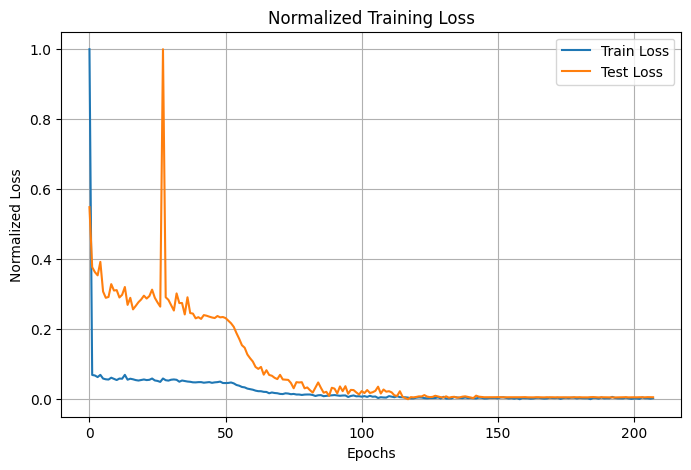

Fold 5
Epoch 0 | Loss train: 4.820779 | Loss test: 0.766788 | lr = 0.01
Epoch 10 | Loss train: 0.860793 | Loss test: 0.704574 | lr = 0.01
Epoch 20 | Loss train: 0.826278 | Loss test: 0.791880 | lr = 0.01
Epoch 30 | Loss train: 0.821338 | Loss test: 0.671832 | lr = 0.01
Epoch 40 | Loss train: 0.774504 | Loss test: 0.696478 | lr = 0.01
Epoch 50 | Loss train: 0.762484 | Loss test: 0.674166 | lr = 0.01
Epoch 60 | Loss train: 0.762891 | Loss test: 0.666664 | lr = 0.01
Epoch 70 | Loss train: 0.758182 | Loss test: 0.680566 | lr = 0.001
Epoch 80 | Loss train: 0.741954 | Loss test: 0.666365 | lr = 0.001
Epoch 90 | Loss train: 0.747855 | Loss test: 0.658165 | lr = 0.0001
Epoch 100 | Loss train: 0.743171 | Loss test: 0.658352 | lr = 0.0001
Epoch 110 | Loss train: 0.747193 | Loss test: 0.658112 | lr = 0.0001
Epoch 120 | Loss train: 0.748052 | Loss test: 0.658858 | lr = 1e-05
Epoch 130 | Loss train: 0.746984 | Loss test: 0.658617 | lr = 1e-05
Epoch 140 | Loss train: 0.743657 | Loss test: 0.658601 |

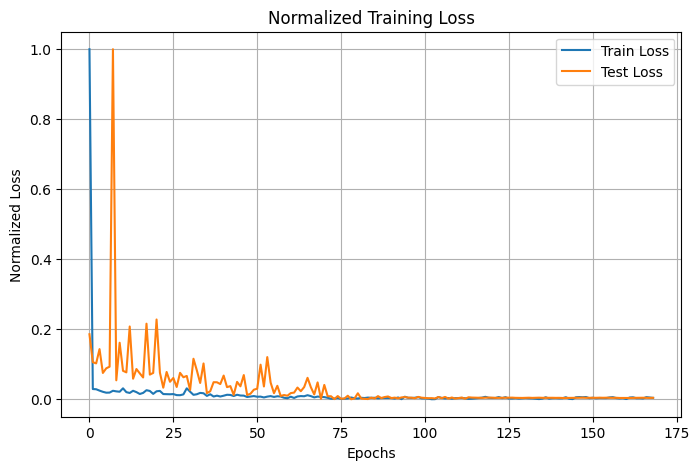

Cross-Validation finished with mean error across 5 subsets = 0.5426377824942271, evaluating final model...
Epoch 0 | Loss train: 3.059620 | lr = 0.01
Epoch 10 | Loss train: 0.694843 | lr = 0.01
Epoch 20 | Loss train: 0.650628 | lr = 0.01
Epoch 30 | Loss train: 0.643080 | lr = 0.01
Epoch 40 | Loss train: 0.589126 | lr = 0.001
Epoch 50 | Loss train: 0.560134 | lr = 0.001
Epoch 60 | Loss train: 0.559743 | lr = 0.001
Epoch 70 | Loss train: 0.563013 | lr = 0.001
Epoch 80 | Loss train: 0.533744 | lr = 0.001
Epoch 90 | Loss train: 0.519483 | lr = 0.001
Epoch 100 | Loss train: 0.496082 | lr = 0.001
Epoch 110 | Loss train: 0.453482 | lr = 0.001
Epoch 120 | Loss train: 0.441970 | lr = 0.001
Epoch 130 | Loss train: 0.408870 | lr = 0.001
Epoch 140 | Loss train: 0.413267 | lr = 0.001
Epoch 150 | Loss train: 0.411430 | lr = 0.001
Epoch 160 | Loss train: 0.400341 | lr = 0.001
Epoch 170 | Loss train: 0.383787 | lr = 0.001
Epoch 180 | Loss train: 0.364614 | lr = 0.0001
Epoch 190 | Loss train: 0.368913 

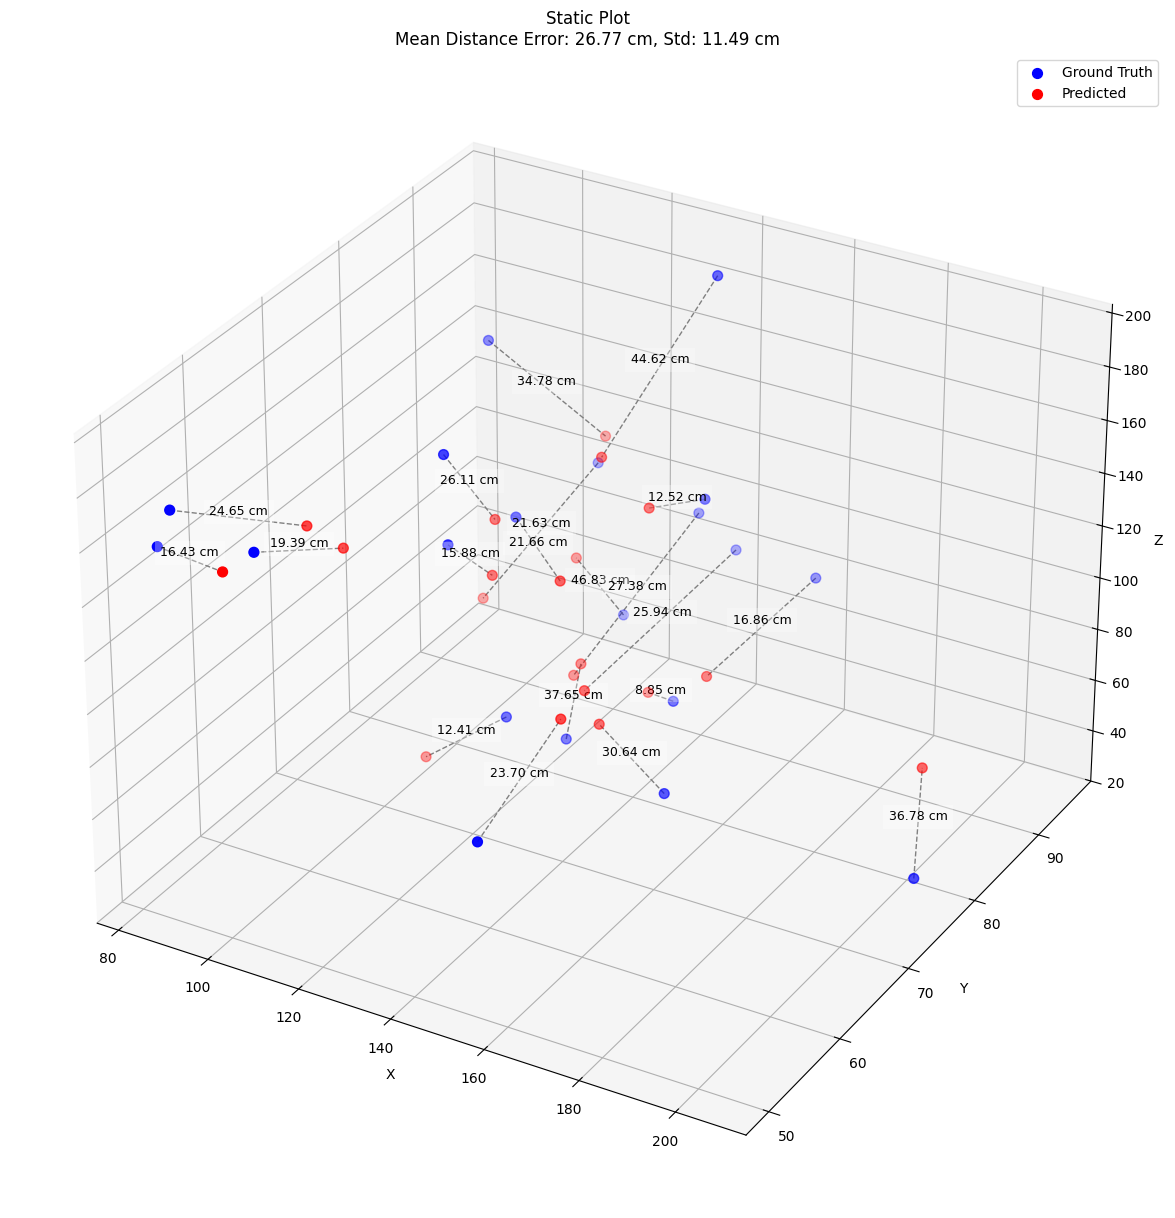

In [40]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 256}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 350

relu_dropout_model = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= ReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [41]:
relu_dropout_model

{'model_name': 'ReLUModelDropout',
 'mean_distance_error_cm': 26.767059326171875,
 'std': 11.488499641418457}

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [27]:
all_permutations_main = []
for sublist in main_data:
    sublist_permutations = list(permutations(sublist,2))
    all_permutations_main.append(sublist_permutations)

main_data_t = []
main_labels_t = []
for perms in all_permutations_main:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            main_data_t.append(paths)
            main_labels_t.append(perm[0]['tag_pos'])

main_data_t = np.array(main_data_t)
main_labels_t = np.array(main_labels_t)

all_permutations_holdout = []
for sublist in holdout_data:
    sublist_permutations = list(permutations(sublist,2))
    all_permutations_holdout.append(sublist_permutations)

holdout_data_t = []
holdout_labels_t = []
for perms in all_permutations_holdout:
    for perm in perms:
        connected_paths = []
        for i in range(len(perm)):
            connected_paths.append(perm[i]['path'])
        if(connected_paths!=[]):
            paths = np.hstack(connected_paths)
            holdout_data_t.append(paths)
            holdout_labels_t.append(perm[0]['tag_pos'])

holdout_data_t = np.array(holdout_data_t)
holdout_labels_t = np.array(holdout_labels_t)

# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = main_data_t, holdout_data_t, main_labels_t, holdout_labels_t

# Compute abs max PER FEATURE on training data
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [44]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:22:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.

c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:22:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.

c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.

c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.

c:\Users\House\AppData\Local\Programs\Python\Pyt

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [45]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr = 1e-5)

In [46]:
# Train-test split BEFORE reshaping
X_train_raw, X_test_raw, y_train, y_test = main_data_t, holdout_data_t, main_labels_t, holdout_labels_t

# Compute abs max PER FEATURE on training data
abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

# Prevent division by zero
abs_max[abs_max == 0] = 1.0

# Normalize per feature
X_train_norm = X_train_raw / abs_max  # shape (N_train, 500, 4)
X_test_norm = X_test_raw / abs_max    # shape (N_test, 500, 4)

# Now reshape for linear model
X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)

In [47]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.00785 | Test Loss: 4.51594
Epoch: 100 | Train Loss: 0.56803 | Test Loss: 0.59127
Epoch: 200 | Train Loss: 0.56667 | Test Loss: 0.59016
Epoch: 300 | Train Loss: 0.56508 | Test Loss: 0.58901
Epoch: 400 | Train Loss: 0.56332 | Test Loss: 0.58777
Epoch: 500 | Train Loss: 0.56143 | Test Loss: 0.58644
Epoch: 600 | Train Loss: 0.55942 | Test Loss: 0.58531
Epoch: 700 | Train Loss: 0.55726 | Test Loss: 0.58312
Epoch: 800 | Train Loss: 0.55500 | Test Loss: 0.58160
Epoch: 900 | Train Loss: 0.55260 | Test Loss: 0.58049
Epoch: 1000 | Train Loss: 0.55010 | Test Loss: 0.57826


***

### Αρχιτεκτονική 7

#### 1D CNN

In [48]:
class CNN1DModel(nn.Module):
    def __init__(self, input_channels=8, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(1),  # Output shape: (batch_size, 128, 1)
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, output_size)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # (batch, 500, 4) → (batch, 4, 500)
        x = self.conv_stack(x)  # (batch, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 128)
        return self.fc(self.dropout(x))

In [2]:
def data_func_cnn(X_train,X_test,y_train,y_test, batch_size=32, test_size=0.2):

    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  # shape (N_train, 500, 4)
    X_test_scaled = X_test / abs_max    # shape (N_test, 500, 4)
    

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [3]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(main_data_t, holdout_data_t, main_labels_t, holdout_labels_t)

NameError: name 'main_data_t' is not defined

Epoch 0 | Loss train: 0.730539 | Loss test: 0.450585 | lr = 0.01
Epoch 10 | Loss train: 0.481529 | Loss test: 0.423141 | lr = 0.01
Epoch 20 | Loss train: 0.446014 | Loss test: 0.411304 | lr = 0.01
Epoch 30 | Loss train: 0.419206 | Loss test: 0.337776 | lr = 0.01
Epoch 40 | Loss train: 0.413437 | Loss test: 0.351346 | lr = 0.01
Epoch 50 | Loss train: 0.392345 | Loss test: 0.366823 | lr = 0.01
Epoch 60 | Loss train: 0.380995 | Loss test: 0.396543 | lr = 0.01
Epoch 70 | Loss train: 0.377618 | Loss test: 0.345416 | lr = 0.01
Epoch 80 | Loss train: 0.314494 | Loss test: 0.312609 | lr = 0.001
Epoch 90 | Loss train: 0.305061 | Loss test: 0.315215 | lr = 0.001
Epoch 100 | Loss train: 0.303169 | Loss test: 0.321290 | lr = 0.001
Epoch 110 | Loss train: 0.303763 | Loss test: 0.311055 | lr = 0.0001
Epoch 120 | Loss train: 0.299751 | Loss test: 0.315502 | lr = 0.0001
Epoch 130 | Loss train: 0.295082 | Loss test: 0.315346 | lr = 0.0001
Early stopping at epoch 133
Loaded best model from temp_model.pt

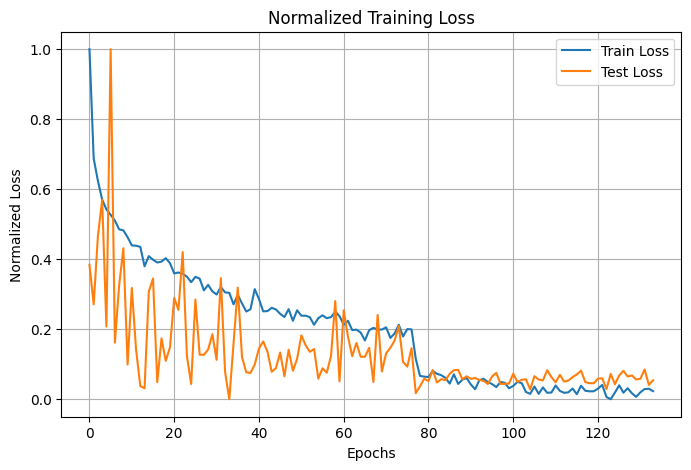

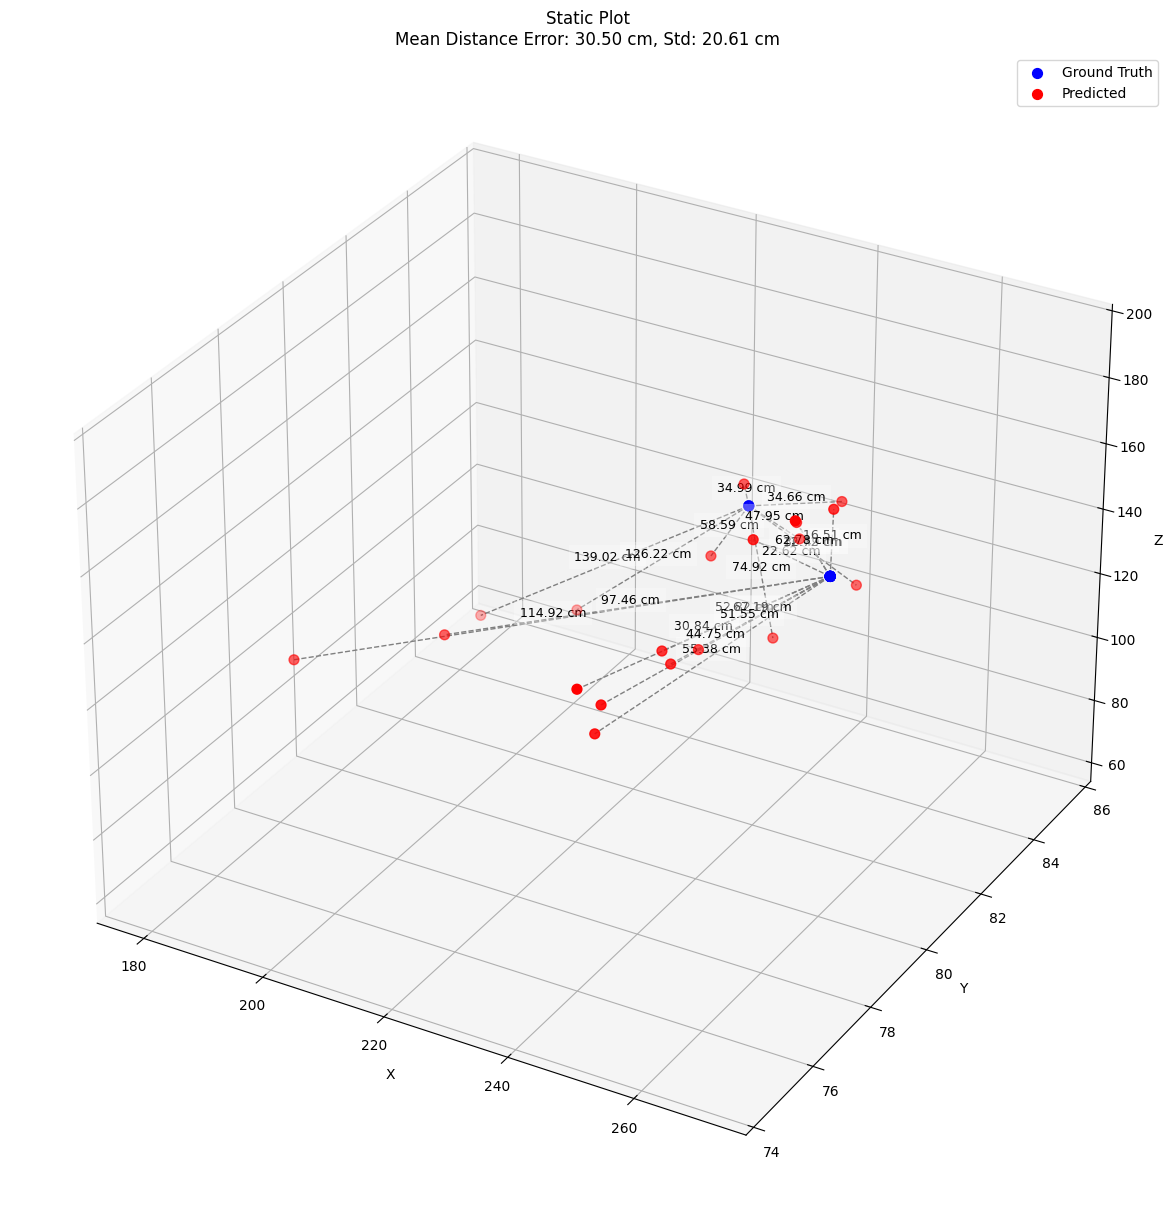

In [51]:
# Instantiate the model
model_16 = CNN1DModel(input_channels=8, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 200,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn_model = eval_model_3d_interactive(model_16, test_loader_cnn, scaler_rev_cnn, device)

In [1]:
cnn_model

NameError: name 'cnn_model' is not defined

***

### Αρχιτεκτονική 8

#### RNN

In [53]:
def data_func_cv_rnn(X_train_raw, X_test_raw, y_train, y_test, batch_size=32):
    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


In [54]:
def data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [55]:
def cross_validation_rnn(Main_Data, Holdout_Data, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    ####################################################

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(range(len(Main_Data)))):
        
        print(f"Fold {fold_idx + 1}")

        train = [Main_Data[i] for i in train_idx]
        test = [Main_Data[i] for i in val_idx]
        
        all_permutations_train = []
        for sublist in train:
            sublist_permutations = list(permutations(sublist,2))
            all_permutations_train.append(sublist_permutations)

        train_data = []
        train_labels = []
        for perms in all_permutations_train:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    train_data.append(paths)
                    train_labels.append(perm[0]['tag_pos'])

        train_data = np.array(train_data)
        train_labels = np.array(train_labels)
        all_permutations_test = []
        for sublist in test:
            sublist_permutations = list(permutations(sublist,2))
            all_permutations_test.append(sublist_permutations)
        
        test_data = []
        test_labels = []
        for perms in all_permutations_test:
            for perm in perms:
                connected_paths = []
                for i in range(len(perm)):
                    connected_paths.append(perm[i]['path'])
                if(connected_paths!=[]):
                    paths = np.hstack(connected_paths)
                    test_data.append(paths)
                    test_labels.append(perm[0]['tag_pos'])

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        train_loader, test_loader, _ = data_func_cv_rnn(train_data, test_data, train_labels, test_labels, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    

    all_permutations_main = []
    for sublist in Main_Data:
        sublist_permutations = list(permutations(sublist,2))
        all_permutations_main.append(sublist_permutations)
    
    main_data = []
    main_labels = []
    for perms in all_permutations_main:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                main_data.append(paths)
                main_labels.append(perm[0]['tag_pos'])

    main_data = np.array(main_data)
    main_labels = np.array(main_labels)

    all_permutations_holdout = []
    for sublist in Holdout_Data:
        sublist_permutations = list(permutations(sublist,2))
        all_permutations_holdout.append(sublist_permutations)
    
    holdout_data = []
    holdout_labels = []
    for perms in all_permutations_holdout:
        for perm in perms:
            connected_paths = []
            for i in range(len(perm)):
                connected_paths.append(perm[i]['path'])
            if(connected_paths!=[]):
                paths = np.hstack(connected_paths)
                holdout_data.append(paths)
                holdout_labels.append(perm[0]['tag_pos'])
    
    holdout_data = np.array(holdout_data)
    holdout_labels = np.array(holdout_labels)

    labels_holdout = holdout_labels
    info_holdout = holdout_data

    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval_rnn(main_data, holdout_data, main_labels, holdout_labels, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d_interactive(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

In [56]:
import torch.nn.functional as F

class EnhancedRNN(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2, output_size=3, dropout=0.3):
        super().__init__()
        # LSTM with independent dropout masks for forward/backward passes
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0 if num_layers == 1 else dropout/2  # Halve dropout for bidir
        )
        
        # Improved normalization scheme
        self.ln1 = nn.LayerNorm(2*hidden_size)
        self.ln2 = nn.LayerNorm(4*hidden_size)
        
        # Revised FC architecture
        self.fc1 = nn.Linear(2*hidden_size, 4*hidden_size)
        self.fc2 = nn.Linear(4*hidden_size, 2*hidden_size)
        self.fc3 = nn.Linear(2*hidden_size, output_size)
        
        # Additional regularization
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout/2)  # Smaller dropout for later layers
        
        self._init_weights()

    def _init_weights(self):
        # LSTM initialization
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1 (improves LSTM performance)
                if 'bias_ih' in name or 'bias_hh' in name:
                    n = param.size(0)
                    param.data[n//4:n//2].fill_(1)
        
        # FC layer initialization
        for fc in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_normal_(fc.weight)
            nn.init.constant_(fc.bias, 0.1)

    def forward(self, x):
        # LSTM with separate dropout for sequence and features
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        lstm_out = self.ln1(lstm_out)
        
        # Enhanced feature transformation
        out = F.selu(self.fc1(lstm_out))  # Self-normalizing activation
        out = self.dropout2(out)
        out = self.ln2(out)
        
        out = F.selu(self.fc2(out))
        out = self.dropout2(out)
        
        return self.fc3(out)

Fold 1


c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch 0 | Loss train: 0.915051 | Loss test: 0.766580 | lr = 0.0002807099556512022
Epoch 10 | Loss train: 0.535124 | Loss test: 0.540001 | lr = 0.0006873108651790013
Epoch 20 | Loss train: 0.414677 | Loss test: 0.492709 | lr = 0.00080292758812537
Epoch 30 | Loss train: 0.360282 | Loss test: 0.425921 | lr = 0.0008485824395239583
Epoch 40 | Loss train: 0.325210 | Loss test: 0.427597 | lr = 0.0008753786886230311
Epoch 50 | Loss train: 0.293348 | Loss test: 0.448618 | lr = 0.0008977629387826315
Epoch 60 | Loss train: 0.271741 | Loss test: 0.435791 | lr = 0.0009118209779535677
Epoch 70 | Loss train: 0.255525 | Loss test: 0.434784 | lr = 0.0009217526530745544
Epoch 80 | Loss train: 0.248774 | Loss test: 0.446417 | lr = 0.0009257271117211306
Epoch 90 | Loss train: 0.238717 | Loss test: 0.483679 | lr = 0.0009314711987273959
Epoch 100 | Loss train: 0.220725 | Loss test: 0.466822 | lr = 0.0009412098144823154
Epoch 110 | Loss train: 0.192126 | Loss test: 0.425049 | lr = 0.0009552380156631845
Epoch

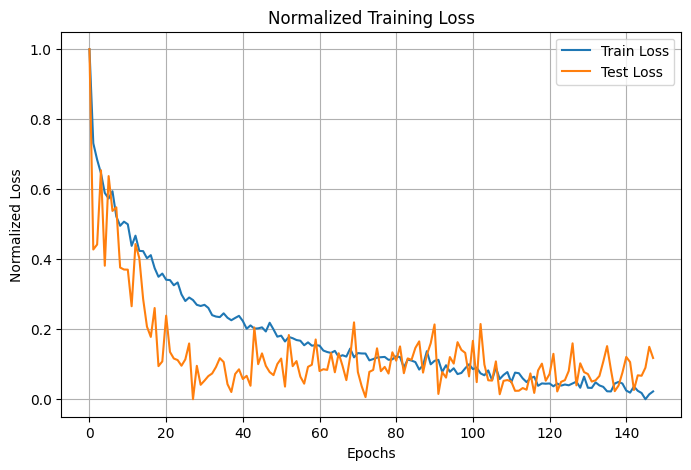

Fold 2


c:\Users\House\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch 0 | Loss train: 0.926706 | Loss test: 0.551922 | lr = 0.0002322433246645333
Epoch 10 | Loss train: 0.499855 | Loss test: 0.405394 | lr = 0.0007017416514863808
Epoch 20 | Loss train: 0.381594 | Loss test: 0.395775 | lr = 0.0008176652881323143
Epoch 30 | Loss train: 0.341736 | Loss test: 0.366816 | lr = 0.0008518315116162145
Epoch 40 | Loss train: 0.293520 | Loss test: 0.411438 | lr = 0.000889159841652212
Epoch 50 | Loss train: 0.294763 | Loss test: 0.380211 | lr = 0.0008882562317029124
Epoch 60 | Loss train: 0.271427 | Loss test: 0.388033 | lr = 0.0009046794921992897
Epoch 70 | Loss train: 0.253537 | Loss test: 0.396767 | lr = 0.000916475883761171
Epoch 80 | Loss train: 0.226785 | Loss test: 0.401056 | lr = 0.0009327822871238036
Epoch 90 | Loss train: 0.236027 | Loss test: 0.388796 | lr = 0.0009273329659622312
Epoch 100 | Loss train: 0.230428 | Loss test: 0.400782 | lr = 0.0009306578014246766
Epoch 110 | Loss train: 0.196530 | Loss test: 0.382374 | lr = 0.0009492277196571238


KeyboardInterrupt: 

In [57]:
#loss_fn = nn.MSELoss()
loss_fn = nn.SmoothL1Loss(beta=0.5)  # Better than Huber for this case
optim = torch.optim.Adam
optimizer_params = {
    'lr': 1e-3,
    'weight_decay': 1e-4,  # L2 regularization
    'amsgrad': True  # Adam variant
}
scheduler_params = {
    'T_max' : 100,
    'eta_min': 1e-5
}
model_params = {'input_size': 8, 'output_size': output_len}
early_stop_params = {
    'patience': 120,  # Increased patience
    'min_delta': 1e-6,  # Smaller delta
    'verbose': False,
    'path':'temp_model.pth'
}
num_splits = 2
epoch = 300
BATCH_SIZE = 16

rnn = cross_validation_rnn(main_data, holdout_data, n_splits=num_splits, model= EnhancedRNN, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

***

## Results

Results for interpolation size = 385

In [ ]:
#compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64])
compare_results = pd.DataFrame([rnn, leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64])
#compare_results = compare_results._append(xgb_res, ignore_index = True)
#compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

NameError: name 'dropout_model' is not defined

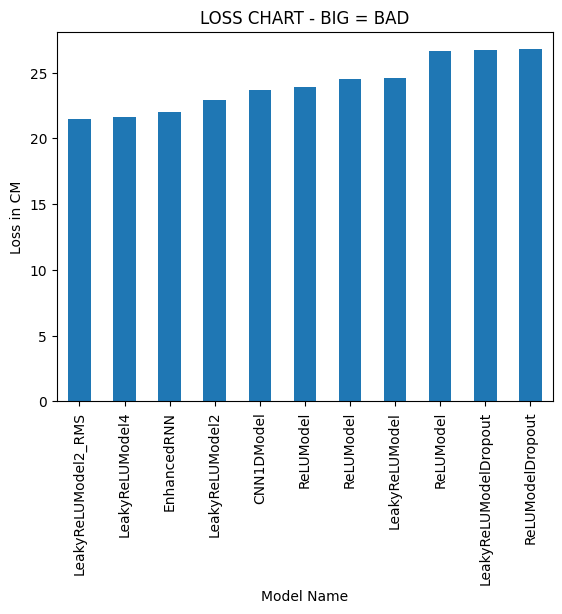

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***

***

# Hyperparameter Tuning

Θα μελετήσουμε ποιες είναι οι βέλτιστες παράμετροι για το μοντέλο LeakyReLU με dropout.

In [60]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Θα πειράξουμε lr , optimizer, batch_size

In [ ]:
import time

# Loss function and static model settings
loss_fn = nn.MSELoss()
model_params = {'input_size': input_len, 'output_size': output_len}
num_splits = 5
epochs = 300

scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 10,
    'min_lr': 1e-5
}

early_stop_params = {
    'patience': 90,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Hyperparameter grids
optimizers = [torch.optim.Adam, torch.optim.AdamW]
learning_rates = [1e-2, 1e-3]
batch_sizes = [16, 32, 64]

# Store results here: each key is a descriptive string, value is result dict
grid_search_results = {}

# Grid search loop
for optimizer_class in optimizers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            config_name = f"{optimizer_class.__name__}_lr{lr}_batch{batch_size}"
            print(f"\nTesting Config: {config_name}")

            optimizer_params = {'lr': lr}
            start_time = time.time()

            result = cross_validation_dat(
                Main_Data=main_data,
                Holdout_Data=holdout_data,
                n_splits=num_splits,
                model=LeakyReLUModel,
                model_param=model_params,
                loss_fn=loss_fn,
                optimizer_1=optimizer_class,
                optimizer_param=optimizer_params,
                scheduler_param=scheduler_params,
                early_stopper_param=early_stop_params,
                epochs=epochs,
                device=device,
                verbose=False
            )

            duration = time.time() - start_time
            print(f"Finished {config_name} in {duration:.2f}s | Result: Mean Error = {result['mean_distance_error_cm']:.4f}, Std = {result['std']:.4f}")

            # Save results
            grid_search_results[config_name] = {
                'result': result,
                'duration': duration,
                'optimizer': optimizer_class.__name__,
                'learning_rate': lr,
                'batch_size': batch_size
            }



Testing Config: Adam_lr0.01_batch16
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2780922741674755, evaluating final model...


In [67]:
# Find config with lowest mean_distance_error_cm error
best_config = min(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])
print(f"\nBest Config: {best_config[0]} | mean_distance_error_cm Error: {best_config[1]['result']['mean_distance_error_cm']:.4f} | Std: {best_config[1]['result']['std']:.4f}")



Best Config: AdamW_lr0.001_batch16 | mean_distance_error_cm Error: 25.1537 | Std: 19.1210


***

# Phase ReLock

In [30]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 0.841448 | Loss test: 0.759886 | lr = 0.001
Epoch 10 | Loss train: 0.532659 | Loss test: 0.561737 | lr = 0.001
Epoch 20 | Loss train: 0.443686 | Loss test: 0.514987 | lr = 0.001
Epoch 30 | Loss train: 0.397691 | Loss test: 0.462384 | lr = 0.001
Loaded best model from temp_model.pth


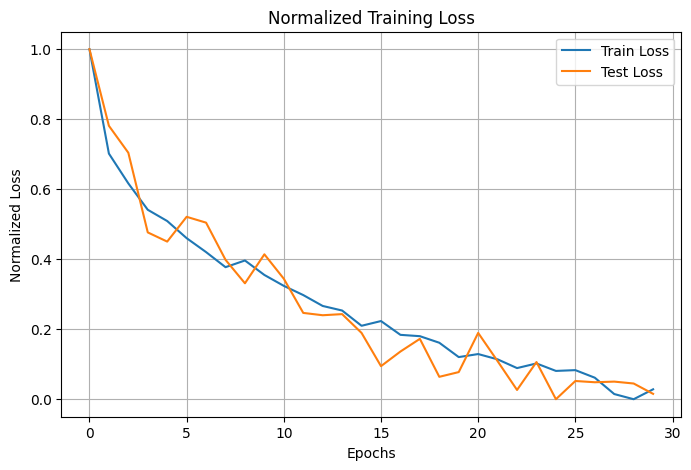

Fold 2
Epoch 0 | Loss train: 0.887582 | Loss test: 0.920814 | lr = 0.001
Epoch 10 | Loss train: 0.505052 | Loss test: 0.594661 | lr = 0.001
Epoch 20 | Loss train: 0.420407 | Loss test: 0.535604 | lr = 0.001
Epoch 30 | Loss train: 0.361760 | Loss test: 0.539956 | lr = 0.001
Loaded best model from temp_model.pth


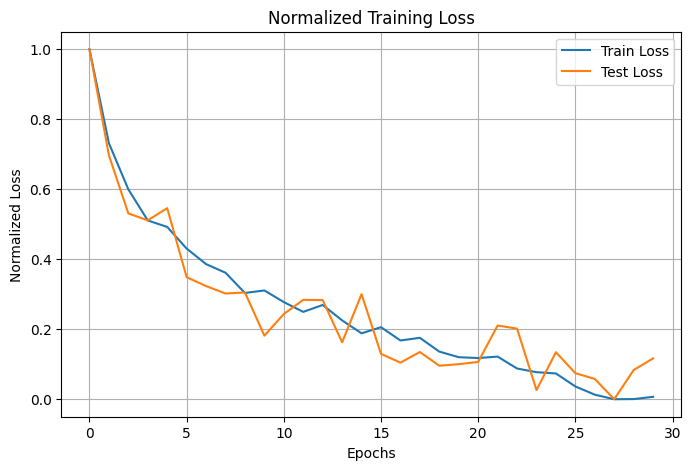

Cross-Validation finished with mean error across 2 subsets = 0.4737087058732723, evaluating final model...
Epoch 0 | Loss train: 0.815828 | lr = 0.001
Epoch 10 | Loss train: 0.484404 | lr = 0.001
Epoch 20 | Loss train: 0.381546 | lr = 0.001
Epoch 29 | Loss train: 0.349471 | lr = 0.001


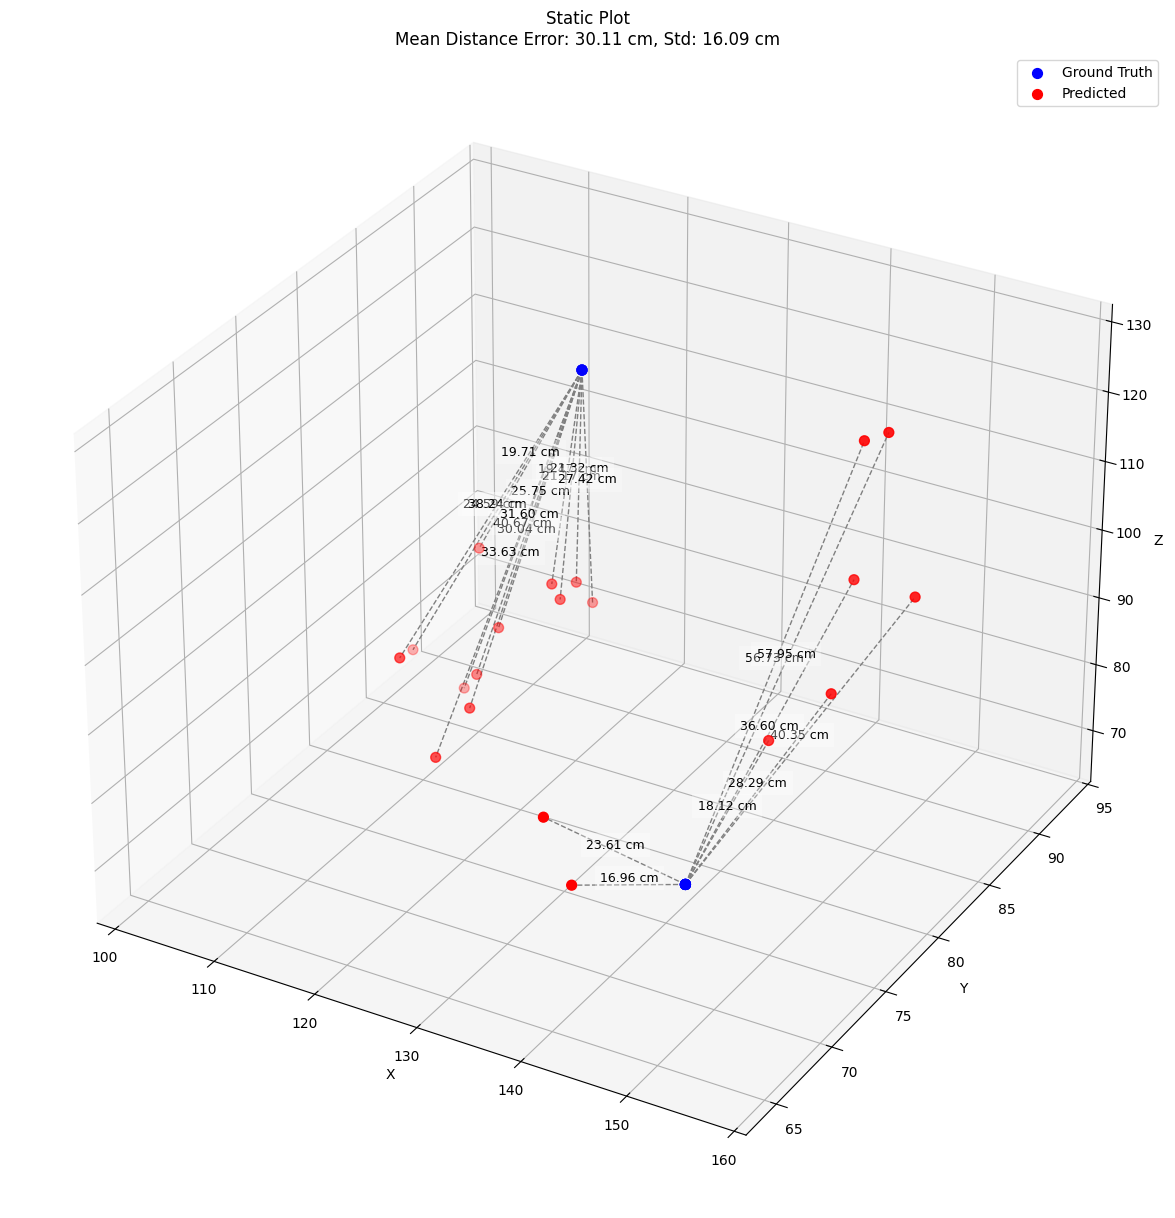

In [31]:
loss_fn = nn.MSELoss()
optim = torch.optim.AdamW
optimizer_params = {'lr':1e-3, 'weight_decay': 1e-4}    
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 2
epoch = 30

dropout_model = cross_validation_dat(main_data, holdout_data, n_splits=num_splits, model= LeakyReLUModelDropout, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Ορίζουμε την συνάρτηση κόστους

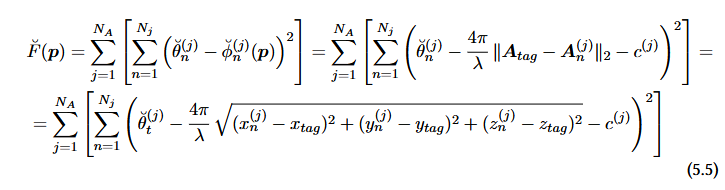

In [32]:
def theoretical_3D(x, x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2, lamda):
    # x[0] = x_tag
    # x[1] = y_tag
    # x[2] = irrelevant c (phase offset)
    F = 0
    F += (phase1 - x[3] - (4*np.pi/lamda) * np.sqrt((x1_antenna - x[0])**2 + (y1_antenna - x[1])**2 + (z1_antenna - x[2])**2))**2
    F += (phase2 - x[4] - (4*np.pi/lamda) * np.sqrt((x2_antenna - x[0])**2 + (y2_antenna - x[1])**2 + (z2_antenna - x[2])**2))**2

    return F

Και στην συνέχεια την συνάρτηση βελτιστοποίησης.

In [33]:
from scipy.optimize import least_squares

def nonlinear_fit_3D(x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2, lamda, start):
    start = np.asarray(start, dtype=float)  
    
    # Perform nonlinear least squares optimization
    param = least_squares(theoretical_3D, start, args=(x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2, lamda), method='trf', bounds=([0, .5, .35,-10000,-10000], [3, 1, 2, 10000, 10000]))
    

    return param.x[:3]  # Return the optimized parameters

Η ```phase_relock``` δέχεται σαν ορίσματα το set (info, labels) που κρατιέται έξω από το training.

Κάνει optimize πάνω στα tags του holdout set.

Τέλος τυπώνει ένα παρόμοιο δίαγραμμα όπως και στα μοντέλα.

In [34]:
def phase_relock(info_holdout, labels_holdout):
    """
    Performs 3D localization optimization for RFID tags using phase measurements from two antennas.
    """
    # Constants
    FREQ = 866e6  # RFID tag frequency (Hz)
    C = 299792458.0  # Speed of light (m/s)
    METERS_TO_CM = 100  # Conversion factor (100 = meters, 1 = cm)
    LAMBDA_SIGNAL = C / FREQ  # Wavelength of the signal
    
    # Storage arrays
    results, errors = [], []
    
    # Optimization loop
    for i in range(len(info_holdout)):
        # Extract features and normalize
        x1, y1, z1 = info_holdout[i][:, 0:3].T / METERS_TO_CM
        phase1 = info_holdout[i][:,3]
        x2, y2, z2 = info_holdout[i][:, 4:7].T / METERS_TO_CM
        phase2 = info_holdout[i][:,7]
        
        # Perform non-linear optimization
        optimized_result = nonlinear_fit_3D(x1, y1, z1, phase1, x2, y2, z2, phase2, LAMBDA_SIGNAL, start=[1, 1, 1, -50, -50])
        results.append(optimized_result)
        
        # Compute error (Euclidean distance)
        gt_x, gt_y, gt_z = labels_holdout[i] / METERS_TO_CM
        err = np.sqrt((gt_x - optimized_result[0])**2 + (gt_y - optimized_result[1])**2 + (gt_z - optimized_result[2])**2)
        errors.append(err)
    
    # Convert results to numpy arrays and scale back to cm
    results = np.array(results) * METERS_TO_CM
    errors = np.array(errors) * METERS_TO_CM
    
    # Visualization
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    num_points = 20  # Number of points to display
    
    # Plot ground truth and predicted points
    ax.scatter(*labels_holdout[:num_points].T, color='blue', label='Ground Truth', s=100)
    ax.scatter(*results[:num_points].T, color='red', label='Predicted', s=100)
    
    # Draw connecting lines and annotate errors
    for i, (gt, pred) in enumerate(zip(labels_holdout[:num_points], results[:num_points])):
        ax.plot(*zip(gt, pred), color='gray', linestyle='--', linewidth=1)
        mid_point = (gt + pred) / 2
        ax.text(*mid_point, f'{errors[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
    
    # Formatting
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {np.mean(errors):.2f} cm, Std: {np.std(errors):.2f} cm')
    ax.legend()
    ax.grid(True)
    plt.show()


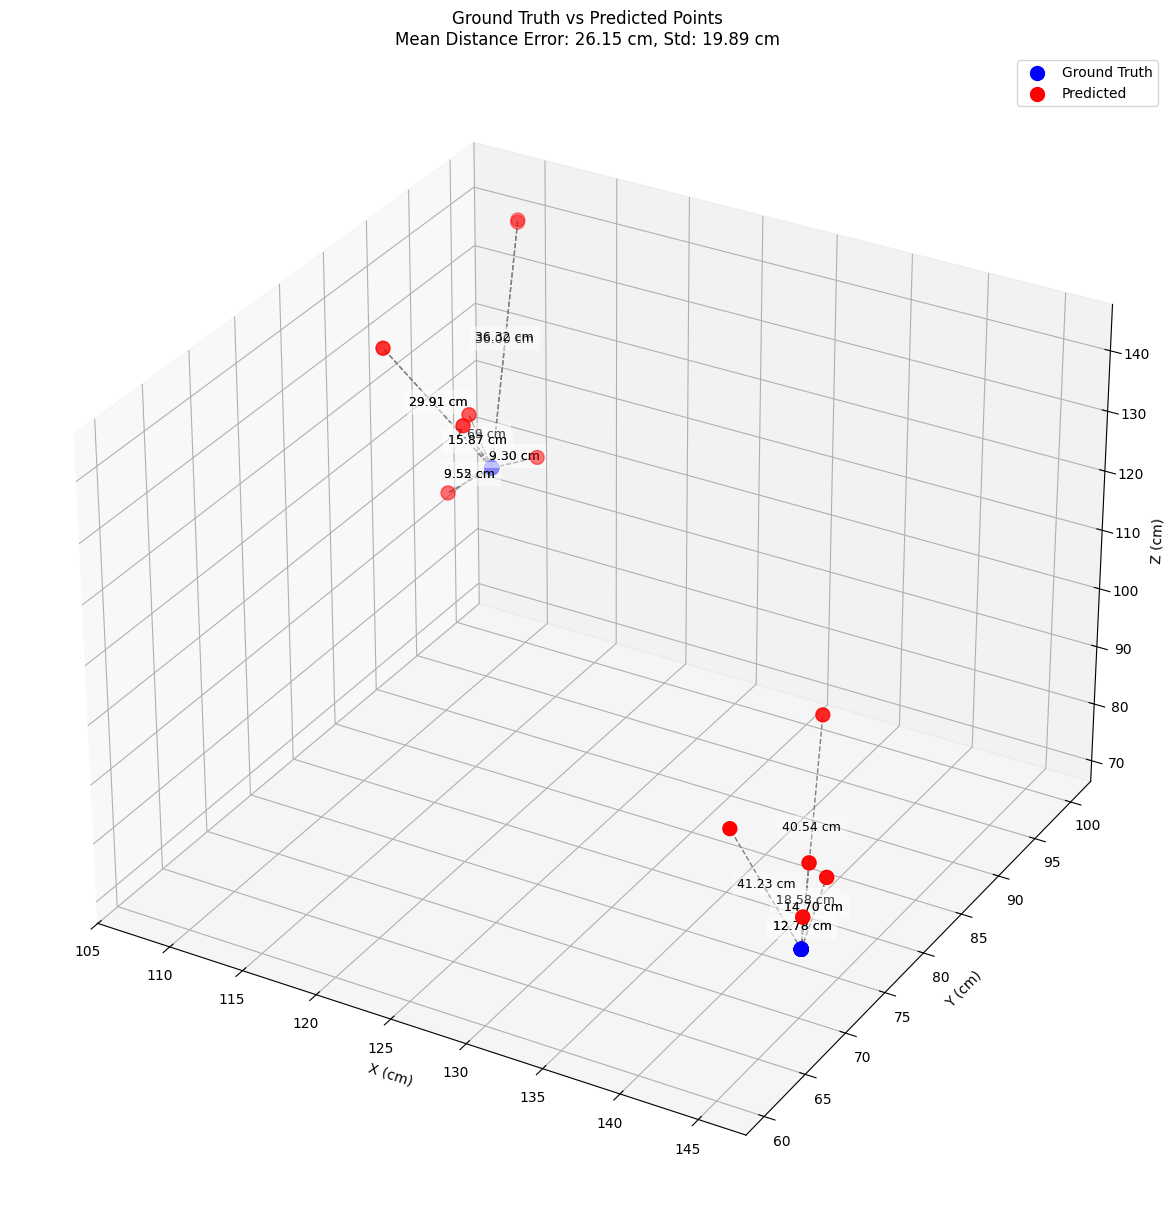

In [35]:
phase_relock(holdout_data_t, holdout_labels_t)